# Collate all of the FROC data into a single file

In [411]:
from pathlib import Path
import pandas as pd
import json
import matplotlib.pyplot as plt

fontsize = 15

In [300]:

fpps_recode = {
    0 : 0.125,
    1 : 0.25,
    2 : 0.5,
    3 : 1,
    4 : 2,
    5 : 4,
    6 : 8
}

froc_paths = Path('results').rglob('*_froc.json')
froc_data = pd.concat([
    (
        pd.DataFrame(category_data)
        .reset_index()
        .rename(columns={'index': 'fpps'})
        .assign(fpps=lambda df: df['fpps'].map(fpps_recode))
        .assign(category=category_json)
        .assign(path=froc_path.as_posix())
    )
    for froc_path in froc_paths
    for category_json, category_data in json.load(froc_path.open()).items()
])

froc_data[['a','dataset','filename']] = froc_data.path.str.split('/', expand=True)
froc_data['model']=froc_data.filename.str.split('_').str[0]
froc_data['flavour']=froc_data.filename.str.split('_').str[1].str.cat(froc_data.filename.str.split('_').str[2], sep='_')
froc_data['error']=froc_data['high_sens'] - froc_data['low_sens']
froc_data.drop(columns=['path','a','filename'], inplace=True)
froc_data.to_csv('froc_data.csv', index=False)
froc_data.query("flavour == 'test_balanced' and category.str.lower() in ['male','female']")

fpps  mean_sens  low_sens  high_sens category dataset   model  \
0   0.125      0.173     0.098      0.253     MALE  summit  grt123   
1   0.250      0.218     0.133      0.310     MALE  summit  grt123   
2   0.500      0.309     0.210      0.415     MALE  summit  grt123   
3   1.000      0.392     0.285      0.504     MALE  summit  grt123   
4   2.000      0.456     0.351      0.560     MALE  summit  grt123   
..    ...        ...       ...        ...      ...     ...     ...   
2   0.500      0.451     0.311      0.614   Female    lsut  ticnet   
3   1.000      0.538     0.423      0.676   Female    lsut  ticnet   
4   2.000      0.644     0.516      0.787   Female    lsut  ticnet   
5   4.000      0.708     0.568      0.850   Female    lsut  ticnet   
6   8.000      0.815     0.681      0.947   Female    lsut  ticnet   

          flavour  error  
0   test_balanced  0.155  
1   test_balanced  0.177  
2   test_balanced  0.205  
3   test_balanced  0.219  
4   test_balanced  0.209  
..            ...    ...  
2   test_balanced  0.303  
3   test_balanced  0.253  
4   test_balanced  0.271  
5   test_balanced  0.282  
6   test_balanced  0.266  

[84 rows x 9 columns]

# Collate CI

In [301]:
import json
import numpy as np

# Collate the mAP scores
CI_paths = Path('results').rglob('*_ci.json')
CI_paths = pd.concat([
    (
        pd.DataFrame.from_dict(json.load(p.open()), orient='index')
        .reset_index()
        .rename(columns={'index':'category', 0:'ci_lower', 1:'ci_upper'})
        .assign(ci=lambda df: np.round(df['ci_lower'],2).astype(str).str.cat(np.round(df['ci_upper'],2).astype(str), sep=' - '))
        .assign(path=p.as_posix())
    )
    for p in CI_paths
])

CI_paths['dataset'] = CI_paths.path.str.split('/').str[1]
CI_paths['x'] = CI_paths.path.str.split('/').str[-1]
CI_paths[['model','p1','p2','d1']] = CI_paths.x.str.split('_', expand=True)
CI_paths['flavour'] = CI_paths.p1.str.cat(CI_paths.p2, sep='_')

ci_data = CI_paths.filter(['dataset', 'model','flavour','category','iou','ci_lower','ci_upper'])
ci_data.to_csv('results/cis.csv', index=False)

ci_data.query('dataset == "summit" and flavour == "white_only"')

dataset      model     flavour        category  ci_lower  ci_upper
0  summit  detection  white_only  MALE_vs_FEMALE -1.156879  0.298947
0  summit     grt123  white_only  MALE_vs_FEMALE -0.756381  0.789223
0  summit     ticnet  white_only  MALE_vs_FEMALE -1.368538  0.190327

# Plot the Error Bar

********************************************************************************
Flavour: test_balanced


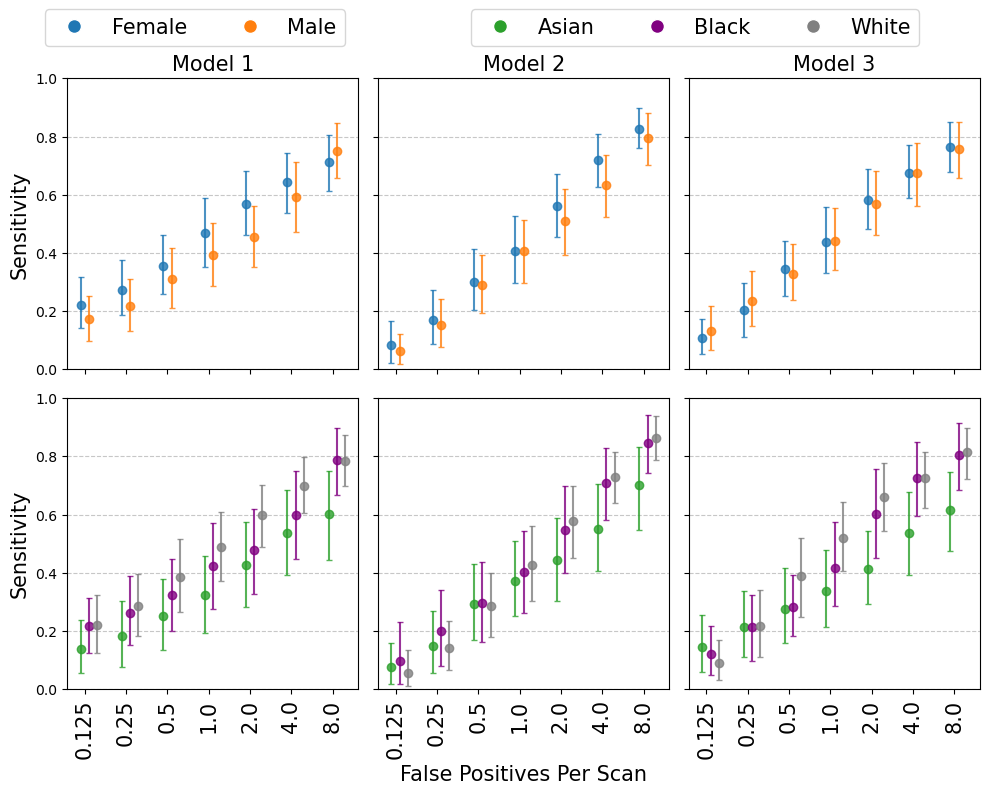

********************************************************************************
Flavour: male_only


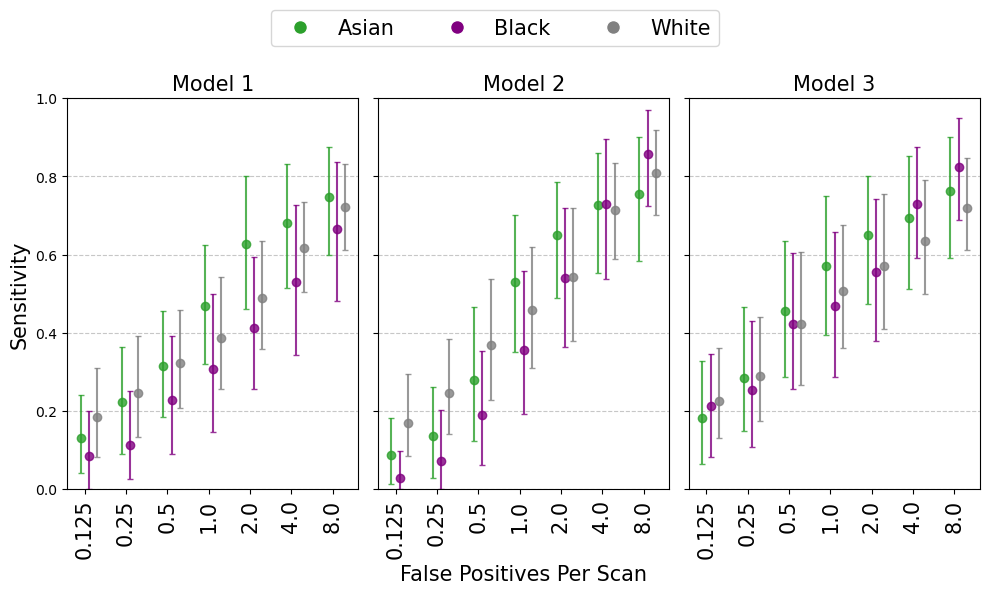

********************************************************************************
Flavour: white_only


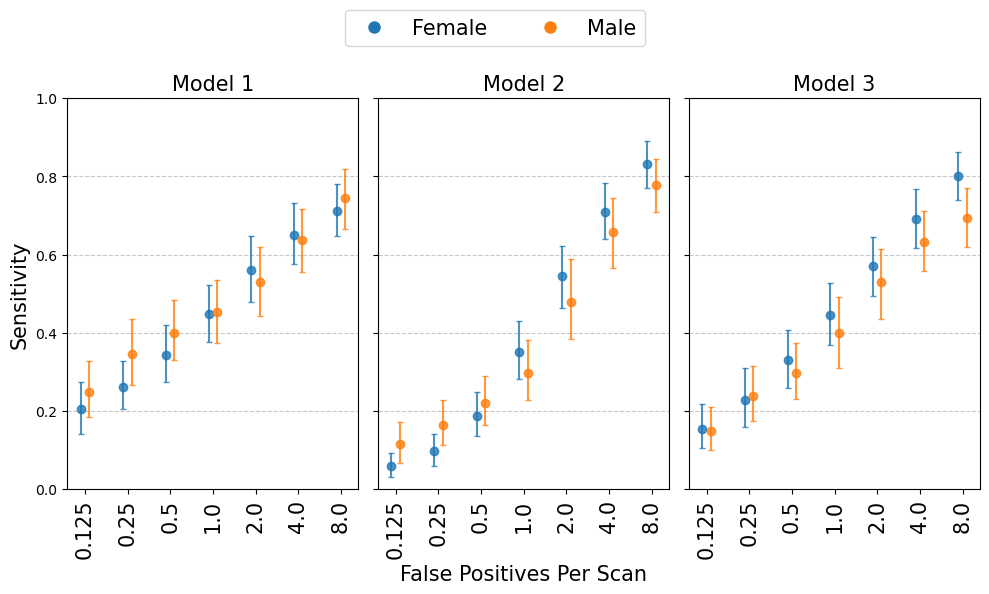

********************************************************************************
Flavour: test_balanced


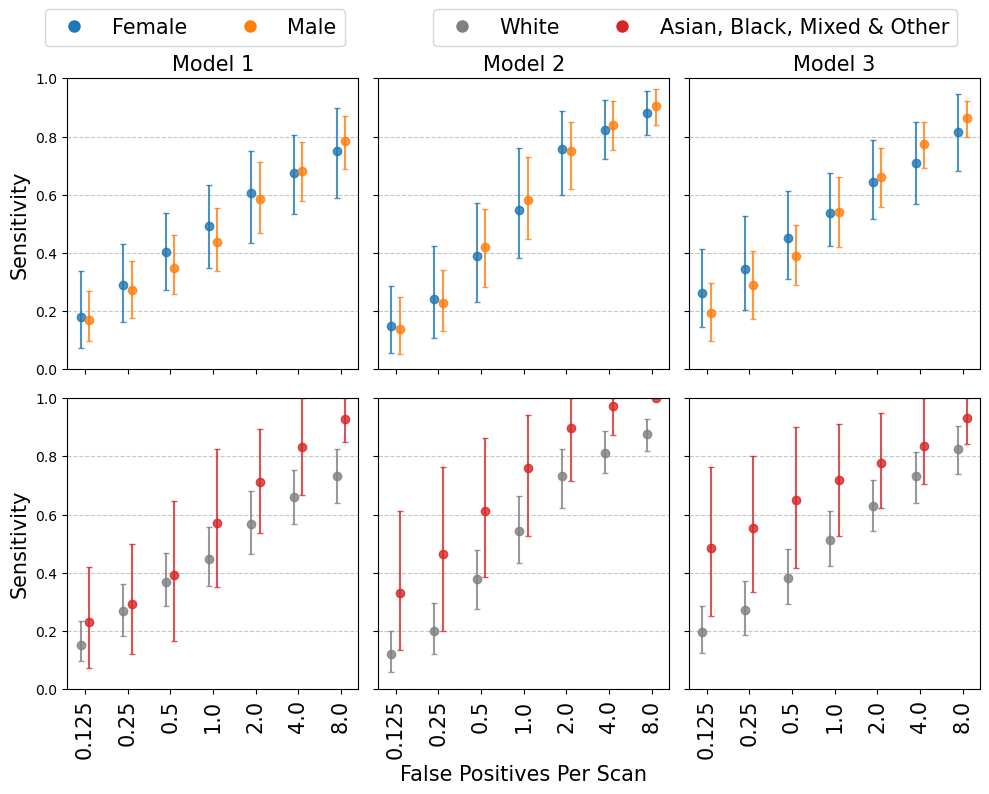

In [302]:
from matplotlib.lines import Line2D

def plot_frocs(dataset, map_data, flavour):
      df = map_data.query('dataset == @dataset and flavour == @flavour')

      if flavour == 'male_only':
            fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(10, 6), sharey=True, sharex=True)
      elif flavour == 'white_only':
            fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(10, 6), sharey=True, sharex=True)
      else:
            fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(10, 8), sharey=True, sharex=True)

      bar_width = 0.2
      categories_top = ['FEMALE', 'MALE'] if dataset == 'summit' else ['Female', 'Male']
      categories_bottom = ['Asian or Asian British', 'Black', 'White'] if dataset == 'summit' else ['White', 'Other']

      model_mappings = {
            'grt123': 'Model 1',
            'detection': 'Model 2',
            'ticnet': 'Model 3'
      }


      # Define color-blind-friendly palette
      colors = {
            'Female': '#1f77b4',  # Blue
            'Male': '#ff7f0e',    # Orange
            'Asian': '#2ca02c',   # Green
            'Black': 'purple',   # Yellow
            'White': 'grey',   # Grey
            'Other': '#d62728'    # Red
      }

      for i, model in enumerate(['grt123', 'detection', 'ticnet']):
            df_model = df.query('model == @model')

            if flavour != 'male_only':
                  ax_top = axes[0, i] if flavour != 'white_only' else axes[i]
                  for j, category in enumerate(categories_top):
                        subset = df_model.query('category == @category')
                        positions = np.arange(len(subset['fpps'].unique()))
                        ax_top.errorbar(
                              positions + j * bar_width,
                              subset['mean_sens'],
                              yerr=[
                                    subset['mean_sens'] - subset['low_sens'],
                                    subset['high_sens'] - subset['mean_sens']
                              ],
                              fmt='o',
                              label=category.replace('FEMALE', 'Female').replace('MALE', 'Male'),
                              capsize=2,
                              alpha=0.8,
                              color=colors[category.replace('FEMALE', 'Female').replace('MALE', 'Male')]
                        )
                        ax_top.set_title(f'{model_mappings[model]}', fontsize=fontsize)
                        ax_top.set_xticks(positions + bar_width / 2)
                        ax_top.set_xticklabels(subset['fpps'].unique(), fontsize=fontsize, rotation=90)
                        ax_top.grid(axis="y", linestyle="--", alpha=0.7)
                        ax_top.set_ylim(0, 1)  # Ensure y-axis runs from 0 to 1

                        if i == 0:
                              ax_top.set_ylabel('Sensitivity', fontsize=fontsize)

                        if i == 1 and flavour == 'white_only':
                              ax_top.set_xlabel('False Positives Per Scan', fontsize=fontsize)                              

            if flavour != 'white_only':
                  ax_bottom = axes[1, i] if flavour != 'male_only' else axes[i]
                  for j, category in enumerate(categories_bottom):
                        subset = df_model.query('category == @category')
                        positions = np.arange(len(subset['fpps'].unique()))
                        ax_bottom.errorbar(
                              positions + j * bar_width,
                              subset['mean_sens'],
                              yerr=[
                                    subset['mean_sens'] - subset['low_sens'],
                                    subset['high_sens'] - subset['mean_sens']
                              ],
                              fmt='o',
                              label=category.replace('Asian or Asian British', 'Asian'),
                              capsize=2,
                              alpha=0.8,
                              color=colors[category.replace('Asian or Asian British', 'Asian')]
                        )
                        ax_bottom.set_xticks(positions + bar_width / 2)
                        ax_bottom.set_xticklabels(subset['fpps'].unique(), fontsize=fontsize, rotation=90)
                        ax_bottom.grid(axis="y", linestyle="--", alpha=0.7)
                        ax_bottom.set_ylim(0, 1)  # Ensure y-axis runs from 0 to 1

                  if i == 0:
                        ax_bottom.set_ylabel('Sensitivity', fontsize=fontsize)

                  if i == 1:
                        ax_bottom.set_xlabel('False Positives Per Scan', fontsize=fontsize)

                  if flavour == 'male_only':
                        ax_bottom.set_title(f'{model_mappings[model]}', fontsize=fontsize)

            

      # Create legends for sex and ethnic group
      if flavour in ['test_balanced', 'white_only']:
            legend_elements_sex = [
                  Line2D([0], [0], marker='o', color='w', label='Female', markerfacecolor=colors['Female'], markersize=10),
                  Line2D([0], [0], marker='o', color='w', label='Male', markerfacecolor=colors['Male'], markersize=10)
            ]
            

      if flavour in ['test_balanced', 'male_only']:
            if dataset == 'summit':
                  legend_elements_ethnic = [
                        Line2D([0], [0], marker='o', color='w', label='Asian', markerfacecolor=colors['Asian'], markersize=10),
                        Line2D([0], [0], marker='o', color='w', label='Black', markerfacecolor=colors['Black'], markersize=10),
                        Line2D([0], [0], marker='o', color='w', label='White', markerfacecolor=colors['White'], markersize=10)
                  ]
            else:
                  legend_elements_ethnic = [
                        Line2D([0], [0], marker='o', color='w', label='White', markerfacecolor=colors['White'], markersize=10),
                        Line2D([0], [0], marker='o', color='w', label='Asian, Black, Mixed & Other', markerfacecolor=colors['Other'], markersize=10)                        
                  ]


      if flavour == "test_balanced":
            fig.legend(
                    handles=legend_elements_sex,
                    loc='upper center',
                    ncol=len(legend_elements_sex),
                    bbox_to_anchor=(0.20, 1),
                    fontsize=fontsize,
                    frameon=True
            )

            fig.legend(
                    handles=legend_elements_ethnic,
                    loc='upper center',
                    ncol=len(legend_elements_ethnic),
                    bbox_to_anchor=(0.70, 1),
                    fontsize=fontsize,
                    frameon=True
            )

      elif flavour == 'white_only':
            fig.legend(handles=legend_elements_sex, loc='upper center', ncol=2, fontsize=fontsize, frameon=True)
      
      elif flavour == 'male_only':
            fig.legend(handles=legend_elements_ethnic, loc='upper center', ncol=3, fontsize=fontsize, frameon=True)


      # Adjust layout to make space for the legend and suptitle
      if flavour in ['male_only', 'white_only']:
            plt.tight_layout(rect=[0, 0, 1, 0.9])  # Leave more space at the top
      else:
            plt.tight_layout(rect=[0, 0, 1, 0.95])
      plt.savefig(f'results/extension/images/{dataset}_{flavour}_error_bar_plot.png', bbox_inches='tight')
      plt.show()


for flavour in ['test_balanced', 'male_only', 'white_only']:
      print('*'*80)
      print(f"Flavour: {flavour}")
      plot_frocs('summit', froc_data, flavour)

for flavour in ['test_balanced']:
      print('*'*80)
      print(f"Flavour: {flavour}")
      plot_frocs('lsut', froc_data, flavour)


# Plot the overall performance of SUMMIT vs LSUT models on test_balanced flavour

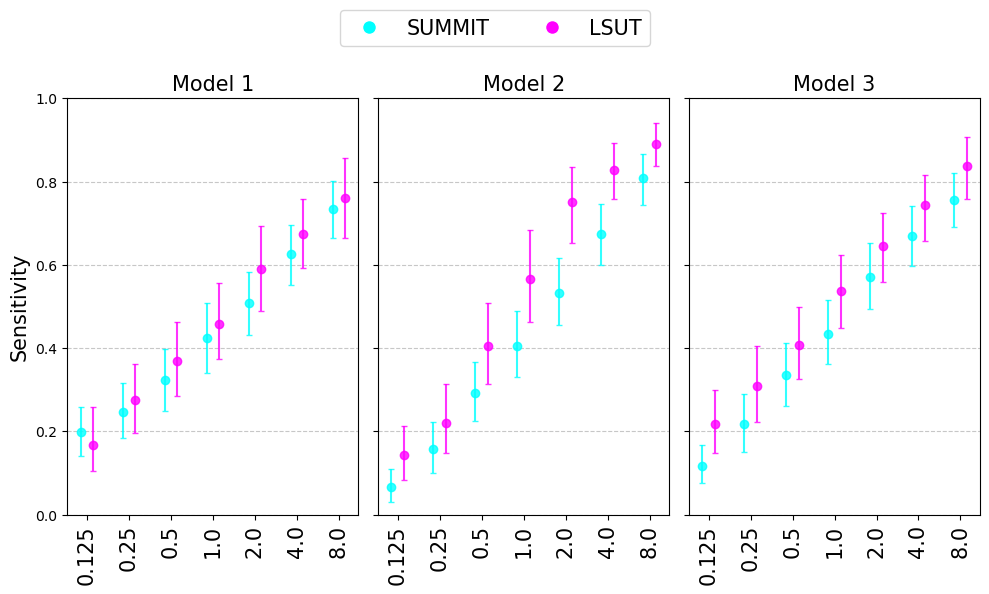

In [303]:
froc_data.head()

bar_width = 0.3
colors = {
    'summit': 'cyan',
    'lsut': 'magenta'
}

model_mappings = {
    'grt123': 'Model 1',
    'detection': 'Model 2',
    'ticnet': 'Model 3'
}

fontsize = 15

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(10, 6), sharey=True)

for ix, model in enumerate(['grt123', 'detection', 'ticnet']):

# for ix, model in enumerate(['detection']):

    df_model = froc_data.query('model == @model and category == "all" and flavour == "test_balanced"')

    for j, dataset in enumerate(['summit', 'lsut']):

        subset = df_model.query('dataset == @dataset')

        # display(subset)

        positions = np.arange(len(subset['fpps'].unique()))
        ax[ix].errorbar(
            positions + j * bar_width,
            subset['mean_sens'],
            yerr=[
                subset['mean_sens'] - subset['low_sens'],
                subset['high_sens'] - subset['mean_sens']
            ],
            fmt='o',
            label=dataset.capitalize(),
            capsize=2,
            alpha=0.8,
            color=colors[dataset]
        )
        ax[ix].set_title(f'{model_mappings[model]}', fontsize=fontsize)
        ax[ix].set_xticks(positions + bar_width / 2)
        ax[ix].set_xticklabels(subset['fpps'].unique(), fontsize=fontsize, rotation=90)
        ax[ix].grid(axis="y", linestyle="--", alpha=0.7)
        ax[ix].set_ylim(0, 1)  # Ensure y-axis runs from 0 to 1

        if ix == 0:
            ax[ix].set_ylabel('Sensitivity', fontsize=fontsize)



legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='SUMMIT', markerfacecolor=colors['summit'], markersize=10),
    Line2D([0], [0], marker='o', color='w', label='LSUT', markerfacecolor=colors['lsut'], markersize=10)                        
]


fig.legend(
        handles=legend_elements,
        loc='upper center',
        ncol=len(legend_elements),
        fontsize=fontsize,
        frameon=True
)

plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.savefig(f'results/extension/images/dataset_comparison_error_bar_plot.png', bbox_inches='tight')
plt.show()

# Collate all of the CMP data into a single file

In [304]:


cpm_summary_paths = Path('results').rglob('cpm_summary.csv')
cpm_summary_paths = pd.concat([
    (
        pd.read_csv(p)
        .assign(path=p.as_posix())
        .rename(columns={'Unnamed: 0':'category', '0' :'CPM'})
    )
    for p in cpm_summary_paths
])

cpm_summary_paths[['a','dataset','model','flavour','c','d','e']] = cpm_summary_paths.path.str.split('/', expand=True)
cpm_data = cpm_summary_paths.filter(['dataset', 'model','flavour','category','CPM']).query('CPM.notnull()')
cpm_data[['cpm_mean', 'cpm_lower', 'cpm_upper']] = cpm_data['CPM'].str.extract(r'(\d+\.\d+)\s+\(95%\s+CI\s+(\d+\.\d+)-(\d+\.\d+)\)').astype(float)
cpm_data.to_csv('results/cpms.csv', index=False)

cpm_data.query('flavour == "male_only" and category != "all"').to_clipboard(index=False)

# Plot CI

********************************************************************************
Dataset: summit
********************************************************************************
Flavour: test_balanced


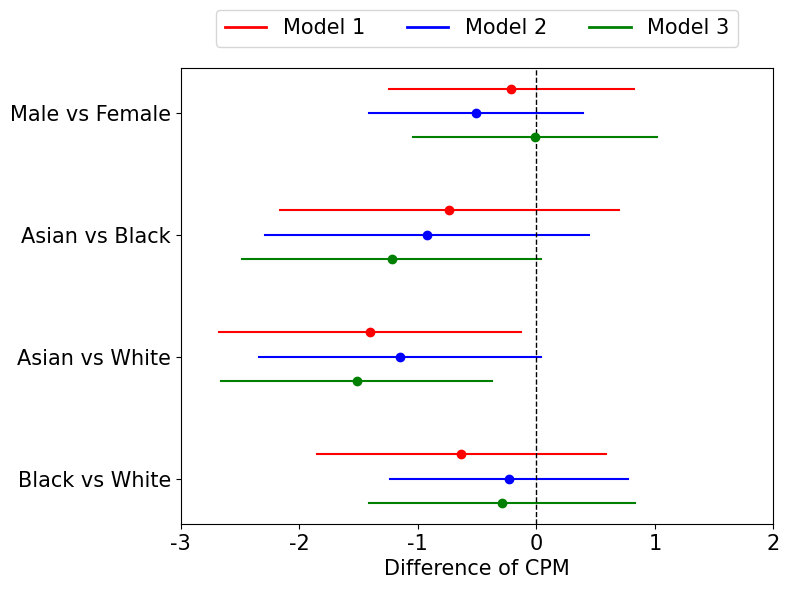

********************************************************************************
Flavour: male_only


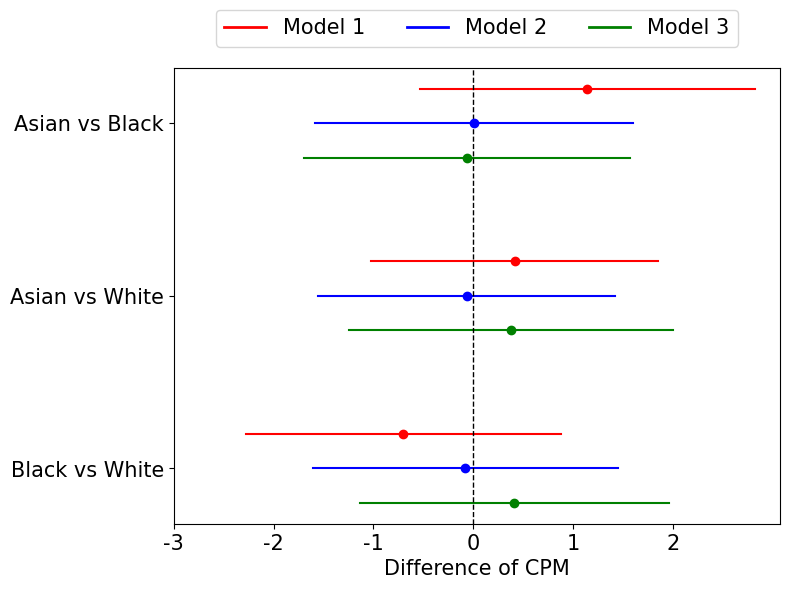

********************************************************************************
Flavour: white_only


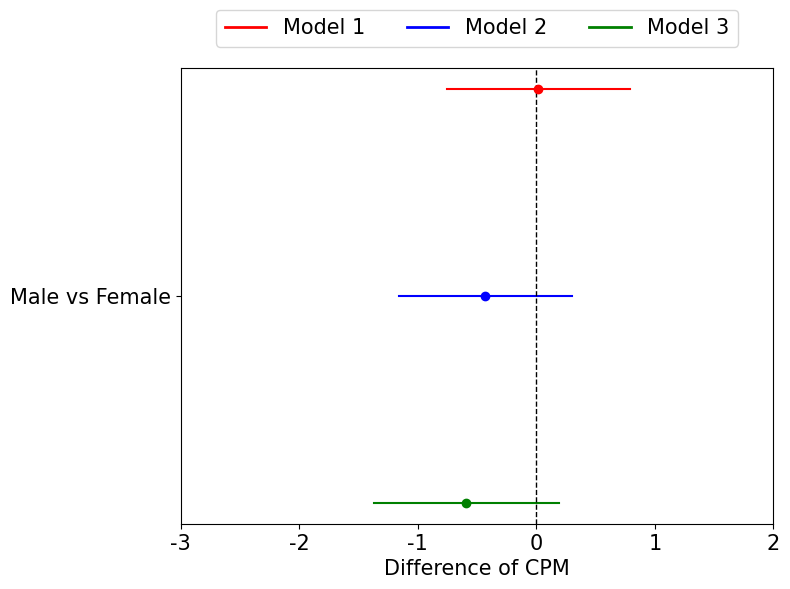

********************************************************************************
Dataset: lsut
********************************************************************************
Flavour: test_balanced


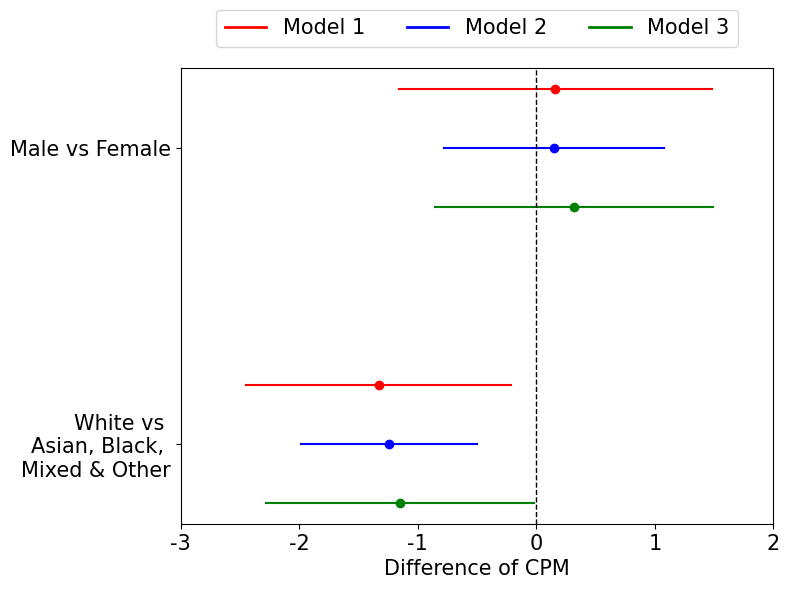

In [335]:

import pandas as pd
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

for dataset in ['summit', 'lsut']:

    print('*' * 80)
    print(f"Dataset: {dataset}")

    for flavour in ['test_balanced', 'male_only', 'white_only'] if dataset == 'summit' else ['test_balanced']:

        print('*' * 80)
        print(f"Flavour: {flavour}")

        df = ci_data.query('dataset == @dataset and flavour == @flavour')

        if dataset == 'summit':        
            mappings = {
                'test_balanced' : {
                    'Black_vs_White': 'Black vs White',
                    'Asian or Asian British_vs_White': 'Asian vs White',
                    'Asian or Asian British_vs_Black': 'Asian vs Black',
                    'MALE_vs_FEMALE': 'Male vs Female'
                },
                'male_only' : {
                    'Black_vs_White': 'Black vs White',
                    'Asian or Asian British_vs_White': 'Asian vs White',
                    'Asian or Asian British_vs_Black': 'Asian vs Black'
                },
                'white_only' : {
                    'MALE_vs_FEMALE': 'Male vs Female'
                },

            }

        else:
            mappings = {
                'test_balanced' : {
                    'White_vs_Other': 'White vs \nAsian, Black, \nMixed & Other',
                    'Male_vs_Female': 'Male vs Female'
                }
            }                

        mappings = mappings[flavour]

        # Update order to align with mappings keys
        order = list(mappings.keys())

        # Filter and sort data for each model
        df_detection = df.query('model == "detection"').sort_values('category', key=lambda x: x.map({k: i for i, k in enumerate(order)}))
        df_grt123 = df.query('model == "grt123"').sort_values('category', key=lambda x: x.map({k: i for i, k in enumerate(order)}))
        df_ticnet = df.query('model == "ticnet"').sort_values('category', key=lambda x: x.map({k: i for i, k in enumerate(order)}))

        # Combine data for all models
        combined_df = pd.concat([
            df_grt123.assign(model_name='Model 1', jitter=0.2, color='red'),
            df_detection.assign(model_name='Model 2', jitter=0, color='blue'),
            df_ticnet.assign(model_name='Model 3', jitter=-0.2, color='green')
        ])

        # Create a single plot
        fig, ax = plt.subplots(figsize=(8, 6))
        # Plot data for each category with tighter jitter for each model
        for i, category in enumerate(order):
            subset = combined_df.query('category == @category')

            if subset.shape[0] > 0:
                for _, row in subset.iterrows():
                    adjusted_jitter = row['jitter'] * 0.5 if flavour == 'white_only' else row['jitter']
                    ax.plot(
                    [row['ci_lower'], row['ci_upper']],
                    [i + adjusted_jitter, i + adjusted_jitter],
                    color=row['color'],
                    lw=1.5
                    )
                    ax.scatter(
                    (row['ci_lower'] + row['ci_upper']) / 2,
                    i + adjusted_jitter,
                    color=row['color'],
                    zorder=3
                    )

        # Add a vertical line at x=0
        ax.axvline(x=0, color='black', linestyle='--', lw=1)

        # Set y-ticks and labels
        ax.set_yticks(range(len(order)))
        ax.set_yticklabels([mappings[category] for category in order], fontsize=fontsize)

        # Set x-ticks and labels
        ax.set_xticks([-3, -2, -1, 0, 1, 2])
        ax.set_xticklabels([-3, -2, -1, 0, 1, 2], fontsize=fontsize)

        # Set labels and title
        ax.set_xlabel("Difference of CPM", fontsize=fontsize)
        # ax.set_title(f"{dataset.capitalize()} - {flavour.replace('_', ' ').capitalize()}", fontsize=fontsize)

        # Add legend above the plot
        legend_elements = [
            Line2D([0], [0], color='red', lw=2, label='Model 1'),
            Line2D([0], [0], color='blue', lw=2, label='Model 2'),
            Line2D([0], [0], color='green', lw=2, label='Model 3')
        ]
        ax.legend(handles=legend_elements, fontsize=fontsize, title_fontsize=fontsize, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)

        # Save and show the plot
        plt.tight_layout()
        plt.savefig(f'results/extension/images/{dataset}_{flavour}_ci_combined_jitter_plot.png', bbox_inches='tight')
        plt.show()


********************************************************************************
Dataset: summit
********************************************************************************
Flavour: male_only


dataset      model    flavour                         category  ci_lower  \
0  summit  detection  male_only  Asian or Asian British_vs_Black -1.584333   
1  summit  detection  male_only  Asian or Asian British_vs_White -1.550521   
2  summit  detection  male_only                   Black_vs_White -1.604079   
0  summit     ticnet  male_only  Asian or Asian British_vs_Black -1.691644   
1  summit     ticnet  male_only  Asian or Asian British_vs_White -1.244991   
2  summit     ticnet  male_only                   Black_vs_White -1.138113   
0  summit     grt123  male_only  Asian or Asian British_vs_Black -0.538683   
1  summit     grt123  male_only  Asian or Asian British_vs_White -1.019931   
2  summit     grt123  male_only                   Black_vs_White -2.278513   

   ci_upper  
0  1.599989  
1  1.421964  
2  1.446506  
0  1.564396  
1  1.997650  
2  1.961479  
0  2.814976  
1  1.847309  
2  0.877502

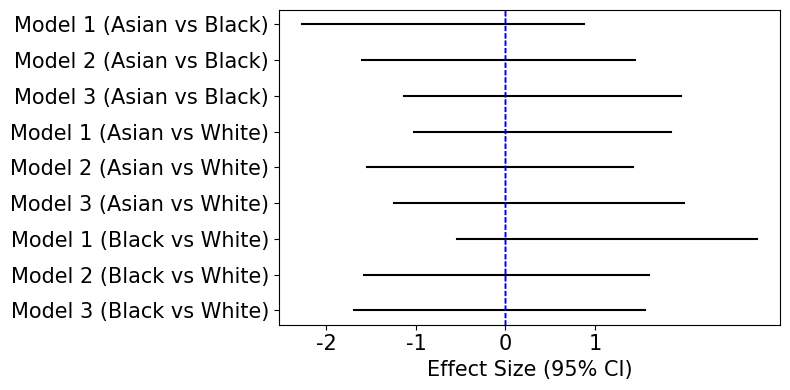

In [306]:
for dataset in ['summit']:

    print('*'*80)
    print(f"Dataset: {dataset}")
    for flavour in ['male_only']:

        print('*'*80)
        print(f"Flavour: {flavour}")

        df = ci_data.query('dataset == @dataset and flavour == @flavour')

        display(df)

        mappings = {
            'Black_vs_White' : 'Black vs White',
            'Asian or Asian British_vs_White' : 'Asian vs White',
            'Asian or Asian British_vs_Black' : 'Asian vs Black',
        }
        # Update order to align with mappings keys
        order = list(mappings.keys())

        # Filter and sort data for each model
        df_detection = df.query('model == "detection"') #.sort_values('category', key=lambda x: x.map({k: i for i, k in enumerate(order)}))
        df_grt123 = df.query('model == "grt123"') #.sort_values('category', key=lambda x: x.map({k: i for i, k in enumerate(order)}))
        df_ticnet = df.query('model == "ticnet"') #.sort_values('category', key=lambda x: x.map({k: i for i, k in enumerate(order)}))

        # Combine data for all models
        combined_df = pd.concat([
                    df_grt123.assign(model_name=lambda df: df['category'] + '_Model 1'),
                    df_detection.assign(model_name=lambda df: df['category'] + '_Model 2'),
                    df_ticnet.assign(model_name=lambda df: df['category'] + '_Model 3')
                ])

        # Create subplots
        fig, ax = plt.subplots(figsize=(8, 4))

        # Plot data for each category
        for i, category in enumerate(['Asian or Asian British_vs_Black', 'Asian or Asian British_vs_White', 'Black_vs_White']):

            subset = combined_df.query('category == @category')


            for _, row in subset.sort_values(by=['model_name'], key=lambda x: x.str.extract(r'Model (\d+)').astype(int)[0], ascending=False).iterrows():
                ax.plot(
                    [
                        row['ci_lower'], 
                        row['ci_upper']
                    ], 
                    [
                        row['model_name'],
                        row['model_name']
                    ],
                    color='black',
                    lw=1.5
                )
            ax.axvline(x=0, color='blue', linestyle='--', lw=1)

        # Set y-ticks and labels
        ax.set_yticks(range(len(order) * 3))
        ytick_labels = [f"{model} ({mappings[category]})" for category in order for model in ['Model 3', 'Model 2', 'Model 1']]
        ax.set_yticklabels(ytick_labels, fontsize=fontsize)  # Reverse the order of labels

        # Set x-ticks and labels
        ax.set_xticks([-2, -1, 0, 1])
        ax.set_xticklabels([-2, -1, 0, 1], fontsize=fontsize)

        ax.set_xlabel("Effect Size (95% CI)", fontsize=fontsize)

        # Save and show the plot
        plt.tight_layout()
        plt.savefig(f'results/extension/images/{dataset}_{flavour}_ci_combined_plot.png', bbox_inches='tight')
        plt.show()


********************************************************************************
Dataset: summit
********************************************************************************
Flavour: white_only


dataset      model     flavour        category  ci_lower  ci_upper
0  summit  detection  white_only  MALE_vs_FEMALE -1.156879  0.298947
0  summit     grt123  white_only  MALE_vs_FEMALE -0.756381  0.789223
0  summit     ticnet  white_only  MALE_vs_FEMALE -1.368538  0.190327

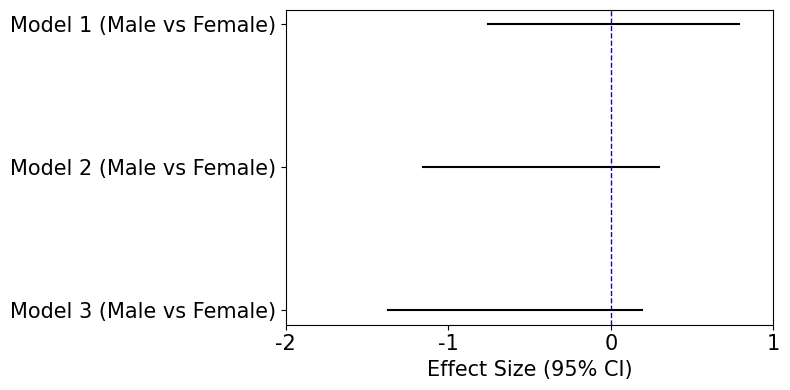

In [307]:

for dataset in ['summit']:

    print('*'*80)
    print(f"Dataset: {dataset}")
    for flavour in ['white_only']:

        print('*'*80)
        print(f"Flavour: {flavour}")

        df = ci_data.query('dataset == @dataset and flavour == @flavour')

        display(df)

        mappings = {
            'MALE_vs_FEMALE': 'Male vs Female'
        }
        # Update order to align with mappings keys
        order = list(mappings.keys())

        # Filter and sort data for each model
        df_detection = df.query('model == "detection"') #.sort_values('category', key=lambda x: x.map({k: i for i, k in enumerate(order)}))
        df_grt123 = df.query('model == "grt123"') #.sort_values('category', key=lambda x: x.map({k: i for i, k in enumerate(order)}))
        df_ticnet = df.query('model == "ticnet"') #.sort_values('category', key=lambda x: x.map({k: i for i, k in enumerate(order)}))

        # Combine data for all models
        combined_df = pd.concat([
                    df_grt123.assign(model_name=lambda df: df['category'] + '_Model 1'),
                    df_detection.assign(model_name=lambda df: df['category'] + '_Model 2'),
                    df_ticnet.assign(model_name=lambda df: df['category'] + '_Model 3')
                ])

        # Create subplots
        fig, ax = plt.subplots(figsize=(8, 4))

        # Plot data for each category
        for i, category in enumerate(['MALE_vs_FEMALE']):

            subset = combined_df.query('category == @category')


            for _, row in subset.sort_values(by=['model_name'], key=lambda x: x.str.extract(r'Model (\d+)').astype(int)[0], ascending=False).iterrows():
                ax.plot(
                    [
                        row['ci_lower'], 
                        row['ci_upper']
                    ], 
                    [
                        row['model_name'],
                        row['model_name']
                    ],
                    color='black',
                    lw=1.5
                )
            ax.axvline(x=0, color='blue', linestyle='--', lw=1)

        # Set y-ticks and labels
        ax.set_yticks(range(len(order) * 3))
        ytick_labels = [f"{model} ({mappings[category]})" for category in order for model in ['Model 3', 'Model 2', 'Model 1']]
        ax.set_yticklabels(ytick_labels, fontsize=fontsize)  # Reverse the order of labels

        # Set x-ticks and labels
        ax.set_xticks([-2, -1, 0, 1])
        ax.set_xticklabels([-2, -1, 0, 1], fontsize=fontsize)

        ax.set_xlabel("Effect Size (95% CI)", fontsize=fontsize)

        # Save and show the plot
        plt.tight_layout()
        plt.savefig(f'results/extension/images/{dataset}_{flavour}_ci_combined_plot.png', bbox_inches='tight')
        plt.show()


********************************************************************************
Dataset: lsut
********************************************************************************
Flavour: test_balanced


dataset      model        flavour        category  ci_lower  ci_upper
0    lsut     grt123  test_balanced  Male_vs_Female -1.158060  1.478897
1    lsut     grt123  test_balanced  White_vs_Other -2.452926 -0.209365
0    lsut     ticnet  test_balanced  Male_vs_Female -0.856522  1.488370
1    lsut     ticnet  test_balanced  White_vs_Other -2.282711 -0.020176
0    lsut  detection  test_balanced  Male_vs_Female -0.782410  1.081249
1    lsut  detection  test_balanced  White_vs_Other -1.981095 -0.499802

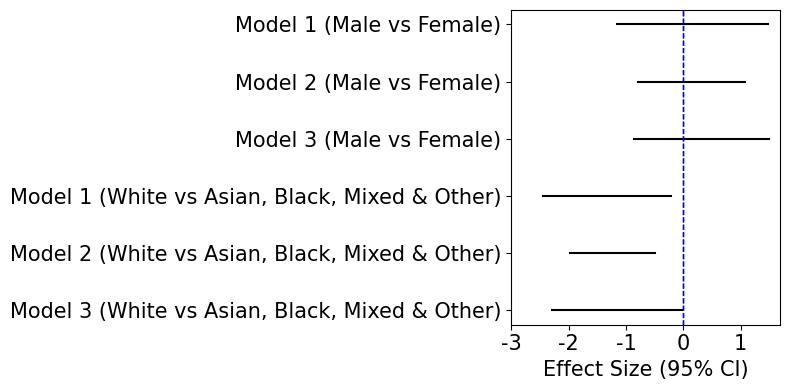

In [308]:

for dataset in ['lsut']:

    print('*'*80)
    print(f"Dataset: {dataset}")
    for flavour in ['test_balanced']:

        print('*'*80)
        print(f"Flavour: {flavour}")

        df = ci_data.query('dataset == @dataset and flavour == @flavour')

        display(df)

        mappings = {
            'White_vs_Other': 'White vs Asian, Black, Mixed & Other',
            'Male_vs_Female': 'Male vs Female'
        }
        # Update order to align with mappings keys
        order = list(mappings.keys())

        # Filter and sort data for each model
        df_detection = df.query('model == "detection"') #.sort_values('category', key=lambda x: x.map({k: i for i, k in enumerate(order)}))
        df_grt123 = df.query('model == "grt123"') #.sort_values('category', key=lambda x: x.map({k: i for i, k in enumerate(order)}))
        df_ticnet = df.query('model == "ticnet"') #.sort_values('category', key=lambda x: x.map({k: i for i, k in enumerate(order)}))

        # Combine data for all models
        combined_df = pd.concat([
                    df_grt123.assign(model_name=lambda df: df['category'] + '_Model 1'),
                    df_detection.assign(model_name=lambda df: df['category'] + '_Model 2'),
                    df_ticnet.assign(model_name=lambda df: df['category'] + '_Model 3')
                ])

        # Create subplots
        fig, ax = plt.subplots(figsize=(8, 4))

        # Plot data for each category
        for i, category in enumerate(['White_vs_Other','Male_vs_Female']):

            subset = combined_df.query('category == @category')


            for _, row in subset.sort_values(by=['model_name'], key=lambda x: x.str.extract(r'Model (\d+)').astype(int)[0], ascending=False).iterrows():
                ax.plot(
                    [
                        row['ci_lower'], 
                        row['ci_upper']
                    ], 
                    [
                        row['model_name'],
                        row['model_name']
                    ],
                    color='black',
                    lw=1.5
                )
            ax.axvline(x=0, color='blue', linestyle='--', lw=1)

        # Set y-ticks and labels
        ax.set_yticks(range(len(order) * 3))
        ytick_labels = [f"{model} ({mappings[category]})" for category in order for model in ['Model 3', 'Model 2', 'Model 1']]
        ax.set_yticklabels(ytick_labels, fontsize=fontsize)  # Reverse the order of labels

        # Set x-ticks and labels
        ax.set_xticks([-3, -2, -1, 0, 1])
        ax.set_xticklabels([-3, -2, -1, 0, 1], fontsize=fontsize)

        ax.set_xlabel("Effect Size (95% CI)", fontsize=fontsize)

        # Save and show the plot
        plt.tight_layout()
        plt.savefig(f'results/extension/images/{dataset}_{flavour}_ci_combined_plot.png', bbox_inches='tight')
        plt.show()


# Combine mAPs

In [416]:
import json

# Collate the mAP scores
mAP_paths = Path('results').rglob('*mean_mAPs.json')
mAP_paths = pd.concat([
    (
        pd.DataFrame.from_dict(json.load(p.open()), orient='index')
        .reset_index()
        .rename(columns={'index':'category', 0:'mAP'})
        .assign(path=p.as_posix())
    )
    for p in mAP_paths
])

mAP_paths.path.str.split('/', expand=True)

mAP_paths[['d0', 'dataset', 'file_name']] = mAP_paths.path.str.split('/', expand=True)
mAP_paths[['model','p1','p2','iou','d1','d2']] = mAP_paths.file_name.str.split('_', expand=True)
mAP_paths['flavour'] = mAP_paths.p1.str.cat(mAP_paths.p2, sep='_')
mAP_paths['category'] = mAP_paths.category.str.split('_').str[-1]
map_data = mAP_paths.filter(['dataset', 'model','flavour','category','iou', 'mAP'])
# Extract map_mean, lower and upper values
map_data[['map_mean', 'map_lower', 'map_upper']] = map_data['mAP'].str.extract(r'(\d+\.\d+)\s+\(CI\s+95%\s+(\d+\.\d+)-(\d+\.\d+)\)').astype(float)
# Compute error bars (Upper - Mean, Mean - Lower)
map_data["map_error_lower"] = map_data["map_mean"] - map_data["map_lower"]
map_data["map_error_upper"] = map_data["map_upper"] - map_data["map_mean"]

map_data.to_csv('results/mAPs.csv', index=False)
map_data.query('dataset == "lsut" and flavour == "test_balanced" and category not in ["Male","Female", "all"]')[['dataset','model','flavour','category','iou','mAP']].sort_values(['model','category','iou'])

dataset      model        flavour category  iou                      mAP
4    lsut  detection  test_balanced    Other  0.1  0.59 (CI 95% 0.46-0.72)
3    lsut  detection  test_balanced    Other  0.3  0.58 (CI 95% 0.45-0.71)
2    lsut  detection  test_balanced    Other  0.5  0.55 (CI 95% 0.41-0.69)
3    lsut  detection  test_balanced    White  0.1  0.49 (CI 95% 0.44-0.55)
4    lsut  detection  test_balanced    White  0.3  0.48 (CI 95% 0.42-0.54)
0    lsut  detection  test_balanced    White  0.5  0.44 (CI 95% 0.38-0.49)
2    lsut     grt123  test_balanced    Other  0.1  0.45 (CI 95% 0.31-0.59)
1    lsut     grt123  test_balanced    Other  0.3   0.43 (CI 95% 0.3-0.57)
0    lsut     grt123  test_balanced    Other  0.5   0.33 (CI 95% 0.2-0.47)
4    lsut     grt123  test_balanced    White  0.1  0.39 (CI 95% 0.34-0.44)
2    lsut     grt123  test_balanced    White  0.3  0.37 (CI 95% 0.32-0.43)
1    lsut     grt123  test_balanced    White  0.5  0.27 (CI 95% 0.21-0.32)
0    lsut     ticnet  test_balanced    Other  0.1  0.49 (CI 95% 0.36-0.64)
0    lsut     ticnet  test_balanced    Other  0.3  0.33 (CI 95% 0.19-0.47)
2    lsut     ticnet  test_balanced    Other  0.5   0.3 (CI 95% 0.17-0.45)
4    lsut     ticnet  test_balanced    White  0.1  0.47 (CI 95% 0.41-0.52)
3    lsut     ticnet  test_balanced    White  0.3  0.33 (CI 95% 0.27-0.38)
0    lsut     ticnet  test_balanced    White  0.5  0.28 (CI 95% 0.23-0.34)

# Plot mAP

********************************************************************************
Flavour: test_balanced


dataset      model        flavour                category  iou  \
0  summit  detection  test_balanced                    MALE  0.1   
1  summit  detection  test_balanced                   White  0.1   
2  summit  detection  test_balanced                     all  0.1   
3  summit  detection  test_balanced  Asian or Asian British  0.1   
4  summit  detection  test_balanced                   Black  0.1   
5  summit  detection  test_balanced                  FEMALE  0.1   
0  summit  detection  test_balanced                   Black  0.3   
1  summit  detection  test_balanced                     all  0.3   
2  summit  detection  test_balanced                    MALE  0.3   
3  summit  detection  test_balanced                  FEMALE  0.3   
4  summit  detection  test_balanced  Asian or Asian British  0.3   
5  summit  detection  test_balanced                   White  0.3   
0  summit  detection  test_balanced                   Black  0.5   
1  summit  detection  test_balanced                    MALE  0.5   
2  summit  detection  test_balanced                  FEMALE  0.5   
3  summit  detection  test_balanced  Asian or Asian British  0.5   
4  summit  detection  test_balanced                   White  0.5   
5  summit  detection  test_balanced                     all  0.5   
0  summit     grt123  test_balanced                  FEMALE  0.1   
1  summit     grt123  test_balanced                   Black  0.1   
2  summit     grt123  test_balanced                     all  0.1   
3  summit     grt123  test_balanced                   White  0.1   
4  summit     grt123  test_balanced  Asian or Asian British  0.1   
5  summit     grt123  test_balanced                    MALE  0.1   
0  summit     grt123  test_balanced                     all  0.3   
1  summit     grt123  test_balanced  Asian or Asian British  0.3   
2  summit     grt123  test_balanced                  FEMALE  0.3   
3  summit     grt123  test_balanced                   White  0.3   
4  summit     grt123  test_balanced                    MALE  0.3   
5  summit     grt123  test_balanced                   Black  0.3   
0  summit     grt123  test_balanced                  FEMALE  0.5   
1  summit     grt123  test_balanced                   Black  0.5   
2  summit     grt123  test_balanced  Asian or Asian British  0.5   
3  summit     grt123  test_balanced                    MALE  0.5   
4  summit     grt123  test_balanced                   White  0.5   
5  summit     grt123  test_balanced                     all  0.5   
0  summit     ticnet  test_balanced                    MALE  0.1   
1  summit     ticnet  test_balanced                   Black  0.1   
2  summit     ticnet  test_balanced                   White  0.1   
3  summit     ticnet  test_balanced                  FEMALE  0.1   
4  summit     ticnet  test_balanced                     all  0.1   
5  summit     ticnet  test_balanced  Asian or Asian British  0.1   
0  summit     ticnet  test_balanced                   White  0.3   
1  summit     ticnet  test_balanced                     all  0.3   
2  summit     ticnet  test_balanced                    MALE  0.3   
3  summit     ticnet  test_balanced  Asian or Asian British  0.3   
4  summit     ticnet  test_balanced                   Black  0.3   
5  summit     ticnet  test_balanced                  FEMALE  0.3   
0  summit     ticnet  test_balanced                    MALE  0.5   
1  summit     ticnet  test_balanced                   White  0.5   
2  summit     ticnet  test_balanced                   Black  0.5   
3  summit     ticnet  test_balanced                     all  0.5   
4  summit     ticnet  test_balanced  Asian or Asian British  0.5   
5  summit     ticnet  test_balanced                  FEMALE  0.5   

                       mAP  map_mean  map_lower  map_upper  map_error_lower  \
0  0.29 (CI 95% 0.25-0.34)      0.29       0.25       0.34             0.04   
1   0.3 (CI 95% 0.24-0.35)      0.30       0.24       0.35             0.06   
2  0.29 (CI 95% 0.26-0.3

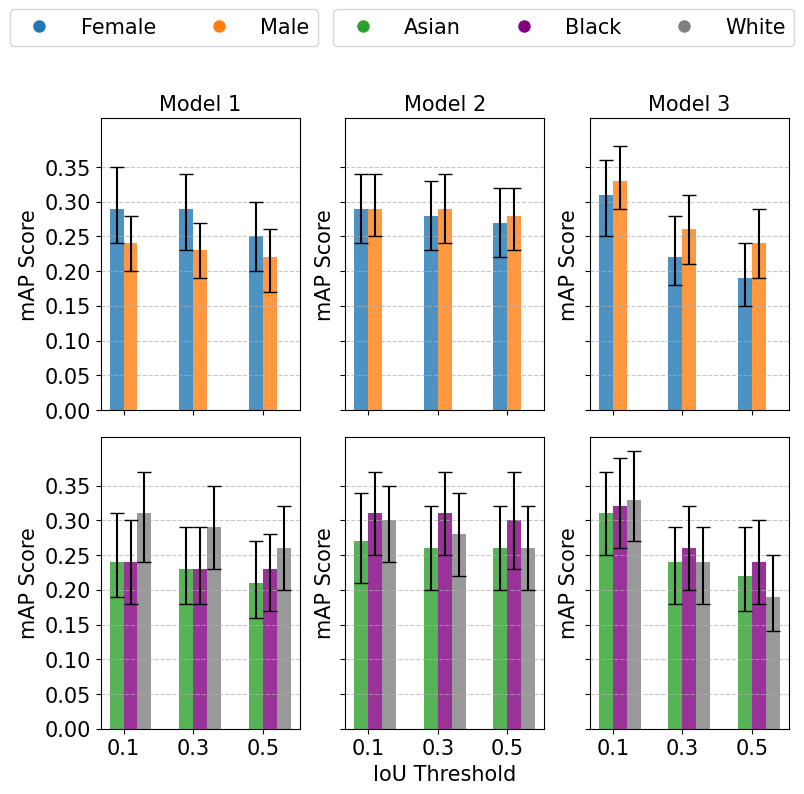

********************************************************************************
Flavour: male_only


dataset      model    flavour                category  iou  \
0  summit  detection  male_only                     all  0.1   
1  summit  detection  male_only  Asian or Asian British  0.1   
2  summit  detection  male_only                   Black  0.1   
3  summit  detection  male_only                   White  0.1   
0  summit  detection  male_only                     all  0.3   
1  summit  detection  male_only  Asian or Asian British  0.3   
2  summit  detection  male_only                   Black  0.3   
3  summit  detection  male_only                   White  0.3   
0  summit  detection  male_only                     all  0.5   
1  summit  detection  male_only  Asian or Asian British  0.5   
2  summit  detection  male_only                   Black  0.5   
3  summit  detection  male_only                   White  0.5   
0  summit     grt123  male_only                     all  0.1   
1  summit     grt123  male_only  Asian or Asian British  0.1   
2  summit     grt123  male_only                   Black  0.1   
3  summit     grt123  male_only                   White  0.1   
0  summit     grt123  male_only                     all  0.3   
1  summit     grt123  male_only  Asian or Asian British  0.3   
2  summit     grt123  male_only                   Black  0.3   
3  summit     grt123  male_only                   White  0.3   
0  summit     grt123  male_only                     all  0.5   
1  summit     grt123  male_only  Asian or Asian British  0.5   
2  summit     grt123  male_only                   Black  0.5   
3  summit     grt123  male_only                   White  0.5   
0  summit     ticnet  male_only                     all  0.1   
1  summit     ticnet  male_only  Asian or Asian British  0.1   
2  summit     ticnet  male_only                   Black  0.1   
3  summit     ticnet  male_only                   White  0.1   
0  summit     ticnet  male_only                     all  0.3   
1  summit     ticnet  male_only  Asian or Asian British  0.3   
2  summit     ticnet  male_only                   Black  0.3   
3  summit     ticnet  male_only                   White  0.3   
0  summit     ticnet  male_only                     all  0.5   
1  summit     ticnet  male_only  Asian or Asian British  0.5   
2  summit     ticnet  male_only                   Black  0.5   
3  summit     ticnet  male_only                   White  0.5   

                       mAP  map_mean  map_lower  map_upper  map_error_lower  \
0  0.35 (CI 95% 0.31-0.39)      0.35       0.31       0.39             0.04   
1  0.28 (CI 95% 0.21-0.35)      0.28       0.21       0.35             0.07   
2  0.41 (CI 95% 0.33-0.49)      0.41       0.33       0.49             0.08   
3  0.37 (CI 95% 0.29-0.44)      0.37       0.29       0.44             0.08   
0  0.35 (CI 95% 0.31-0.39)      0.35       0.31       0.39             0.04   
1  0.28 (CI 95% 0.21-0.35)      0.28       0.21       0.35             0.07   
2  0.41 (CI 95% 0.33-0.49)      0.41       0.33       0.49             0.08   
3  0.36 (CI 95% 0.28-0.44)      0.36       0.28       0.44             0.08   
0  0.33 (CI 95% 0.28-0.37)      0.33       0.28       0.37             0.05   
1  0.27 (CI 95% 0.19-0.34)      0.27       0.19       0.34             0.08   
2  0.39 (CI 95% 0.32-0.48)      0.39       0.32       0.48             0.07   
3   0.32 (CI 95% 0.25-0.4)      0.32       0.25       0.40             0.07   
0  0.32 (CI 95% 0.27-0.36)      0.32       0.27       0.36             0.05   
1   0.3 (CI 95% 0.23-0.37)      0.30       0.23       0.37             0.07   
2  0.31 (CI 95% 0.24-0.38)      0.31       0.24       0.38             0.07   
3  0.34 (CI 95% 0.26-0.41)      0.34       0.26       0.41             0.08   
0   0.3 (CI 95% 0.26-0.34)      0.30       0.26       0.34             0.04   
1  0.29 (CI 95% 0.22-0.36)      0.29       0.22       0.36             0.07   
2  0.31 (CI 95% 0.23-0.38)      0.31       0.23       0.38             0.08   
3  0.31 (CI 95% 0.24-0.39)      0.31       0.24      

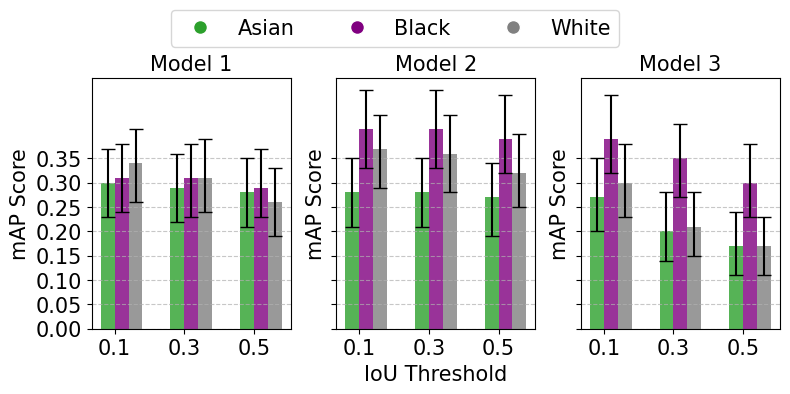

********************************************************************************
Flavour: white_only


dataset      model     flavour category  iou                      mAP  \
0  summit  detection  white_only      all  0.1  0.35 (CI 95% 0.32-0.37)   
1  summit  detection  white_only     MALE  0.1   0.34 (CI 95% 0.3-0.39)   
2  summit  detection  white_only   FEMALE  0.1   0.36 (CI 95% 0.31-0.4)   
0  summit  detection  white_only      all  0.3  0.34 (CI 95% 0.31-0.37)   
1  summit  detection  white_only     MALE  0.3  0.34 (CI 95% 0.29-0.38)   
2  summit  detection  white_only   FEMALE  0.3  0.35 (CI 95% 0.31-0.39)   
0  summit  detection  white_only      all  0.5   0.33 (CI 95% 0.3-0.36)   
1  summit  detection  white_only     MALE  0.5  0.33 (CI 95% 0.29-0.37)   
2  summit  detection  white_only   FEMALE  0.5  0.32 (CI 95% 0.28-0.37)   
0  summit     grt123  white_only      all  0.1   0.3 (CI 95% 0.27-0.34)   
1  summit     grt123  white_only     MALE  0.1  0.29 (CI 95% 0.25-0.33)   
2  summit     grt123  white_only   FEMALE  0.1  0.32 (CI 95% 0.27-0.36)   
0  summit     grt123  white_only      all  0.3  0.29 (CI 95% 0.26-0.32)   
1  summit     grt123  white_only     MALE  0.3  0.28 (CI 95% 0.24-0.32)   
2  summit     grt123  white_only   FEMALE  0.3   0.3 (CI 95% 0.26-0.35)   
0  summit     grt123  white_only      all  0.5  0.26 (CI 95% 0.23-0.29)   
1  summit     grt123  white_only     MALE  0.5   0.25 (CI 95% 0.21-0.3)   
2  summit     grt123  white_only   FEMALE  0.5   0.26 (CI 95% 0.22-0.3)   
0  summit     ticnet  white_only      all  0.1  0.37 (CI 95% 0.34-0.41)   
1  summit     ticnet  white_only     MALE  0.1   0.34 (CI 95% 0.3-0.39)   
2  summit     ticnet  white_only   FEMALE  0.1  0.41 (CI 95% 0.37-0.46)   
0  summit     ticnet  white_only      all  0.3   0.27 (CI 95% 0.24-0.3)   
1  summit     ticnet  white_only     MALE  0.3   0.24 (CI 95% 0.2-0.28)   
2  summit     ticnet  white_only   FEMALE  0.3   0.3 (CI 95% 0.26-0.35)   
0  summit     ticnet  white_only      all  0.5   0.23 (CI 95% 0.2-0.26)   
1  summit     ticnet  white_only     MALE  0.5   0.2 (CI 95% 0.16-0.24)   
2  summit     ticnet  white_only   FEMALE  0.5   0.26 (CI 95% 0.22-0.3)   

   map_mean  map_lower  map_upper  map_error_lower  map_error_upper  
0      0.35       0.32       0.37             0.03             0.02  
1      0.34       0.30       0.39             0.04             0.05  
2      0.36       0.31       0.40             0.05             0.04  
0      0.34       0.31       0.37             0.03             0.03  
1      0.34       0.29       0.38             0.05             0.04  
2      0.35       0.31       0.39             0.04             0.04  
0      0.33       0.30       0.36             0.03             0.03  
1      0.33       0.29       0.37             0.04             0.04  
2      0.32       0.28       0.37             0.04             0.05  
0      0.30       0.27       0.34             0.03             0.04  
1      0.29       0.25       0.33             0.04             0.04  
2      0.32       0.27       0.36             0.05             0.04  
0      0.29       0.26       0.32             0.03             0.03  
1      0.28       0.24       0.32             0.04             0.04  
2      0.30       0.26       0.35             0.04             0.05  
0      0.26       0.23       0.29             0.03             0.03  
1      0.25       0.21       0.30             0.04             0.05  
2      0.26       0.22       0.30             0.04             0.04  
0      0.37       0.34       0.41             0.03             0.04  
1      0.34       0.30       0.39             0.04             0.05  
2      0.41       0.37       0.46             0.04             0.05  
0      0.27       0.24       0.30             0.03             0.03  
1      0.24       0.20       0.28             0.04             0.04  
2      0.30       0.26       0.35             0.04             0.05  
0      0.23       0.20       0.26             0.03             0.03  
1      0.20       0.16       0.24             0.04             0.04  
2      0.26

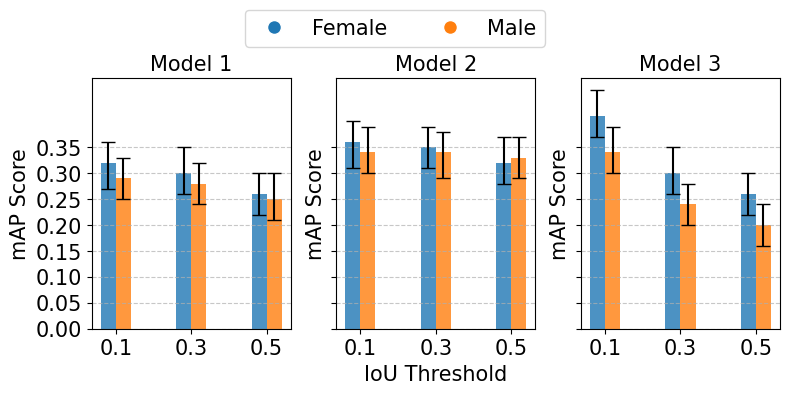

********************************************************************************
Flavour: test_balanced


dataset      model        flavour category  iou                      mAP  \
0    lsut  detection  test_balanced      all  0.1  0.51 (CI 95% 0.45-0.56)   
1    lsut  detection  test_balanced   Female  0.1  0.55 (CI 95% 0.46-0.62)   
2    lsut  detection  test_balanced     Male  0.1  0.48 (CI 95% 0.41-0.54)   
3    lsut  detection  test_balanced    White  0.1  0.49 (CI 95% 0.44-0.55)   
4    lsut  detection  test_balanced    Other  0.1  0.59 (CI 95% 0.46-0.72)   
0    lsut  detection  test_balanced     Male  0.3   0.47 (CI 95% 0.4-0.55)   
1    lsut  detection  test_balanced      all  0.3   0.5 (CI 95% 0.44-0.55)   
2    lsut  detection  test_balanced   Female  0.3  0.53 (CI 95% 0.45-0.62)   
3    lsut  detection  test_balanced    Other  0.3  0.58 (CI 95% 0.45-0.71)   
4    lsut  detection  test_balanced    White  0.3  0.48 (CI 95% 0.42-0.54)   
0    lsut  detection  test_balanced    White  0.5  0.44 (CI 95% 0.38-0.49)   
1    lsut  detection  test_balanced     Male  0.5  0.44 (CI 95% 0.37-0.51)   
2    lsut  detection  test_balanced    Other  0.5  0.55 (CI 95% 0.41-0.69)   
3    lsut  detection  test_balanced   Female  0.5   0.48 (CI 95% 0.4-0.56)   
4    lsut  detection  test_balanced      all  0.5   0.46 (CI 95% 0.4-0.51)   
0    lsut     grt123  test_balanced     Male  0.1  0.37 (CI 95% 0.31-0.45)   
1    lsut     grt123  test_balanced   Female  0.1  0.43 (CI 95% 0.35-0.51)   
2    lsut     grt123  test_balanced    Other  0.1  0.45 (CI 95% 0.31-0.59)   
3    lsut     grt123  test_balanced      all  0.1   0.4 (CI 95% 0.34-0.45)   
4    lsut     grt123  test_balanced    White  0.1  0.39 (CI 95% 0.34-0.44)   
0    lsut     grt123  test_balanced   Female  0.3   0.42 (CI 95% 0.33-0.5)   
1    lsut     grt123  test_balanced    Other  0.3   0.43 (CI 95% 0.3-0.57)   
2    lsut     grt123  test_balanced    White  0.3  0.37 (CI 95% 0.32-0.43)   
3    lsut     grt123  test_balanced      all  0.3  0.38 (CI 95% 0.33-0.44)   
4    lsut     grt123  test_balanced     Male  0.3  0.36 (CI 95% 0.29-0.42)   
0    lsut     grt123  test_balanced    Other  0.5   0.33 (CI 95% 0.2-0.47)   
1    lsut     grt123  test_balanced    White  0.5  0.27 (CI 95% 0.21-0.32)   
2    lsut     grt123  test_balanced      all  0.5  0.27 (CI 95% 0.23-0.33)   
3    lsut     grt123  test_balanced     Male  0.5  0.26 (CI 95% 0.19-0.32)   
4    lsut     grt123  test_balanced   Female  0.5   0.3 (CI 95% 0.23-0.38)   
0    lsut     ticnet  test_balanced    Other  0.1  0.49 (CI 95% 0.36-0.64)   
1    lsut     ticnet  test_balanced   Female  0.1  0.54 (CI 95% 0.46-0.62)   
2    lsut     ticnet  test_balanced      all  0.1  0.47 (CI 95% 0.42-0.52)   
3    lsut     ticnet  test_balanced     Male  0.1  0.42 (CI 95% 0.36-0.49)   
4    lsut     ticnet  test_balanced    White  0.1  0.47 (CI 95% 0.41-0.52)   
0    lsut     ticnet  test_balanced    Other  0.3  0.33 (CI 95% 0.19-0.47)   
1    lsut     ticnet  test_balanced      all  0.3  0.33 (CI 95% 0.28-0.38)   
2    lsut     ticnet  test_balanced   Female  0.3   0.4 (CI 95% 0.31-0.49)   
3    lsut     ticnet  test_balanced    White  0.3  0.33 (CI 95% 0.27-0.38)   
4    lsut     ticnet  test_balanced     Male  0.3  0.28 (CI 95% 0.21-0.35)   
0    lsut     ticnet  test_balanced    White  0.5  0.28 (CI 95% 0.23-0.34)   
1    lsut     ticnet  test_balanced   Female  0.5  0.32 (CI 95% 0.25-0.41)   
2    lsut     ticnet  test_balanced    Other  0.5   0.3 (CI 95% 0.17-0.45)   
3    lsut     ticnet  test_balanced     Male  0.5  0.26 (CI 95% 0.19-0.32)   
4    lsut     ticnet  test_balanced      all  0.5  0.28 (CI 95% 0.23-0.34)   

   map_mean  map_lower  map_upper  map_error_lower  map_error_upper  
0      0.51       0.45       0.56             0.06             0.05  
1      0.55       0.46       0.62             0.09             0.07  
2      0.48       0.41       0.54             0.07             0.06  
3      0.49       0.44       0.55             0.05             0.06  
4      0.59       0.46       0.72             0.13             

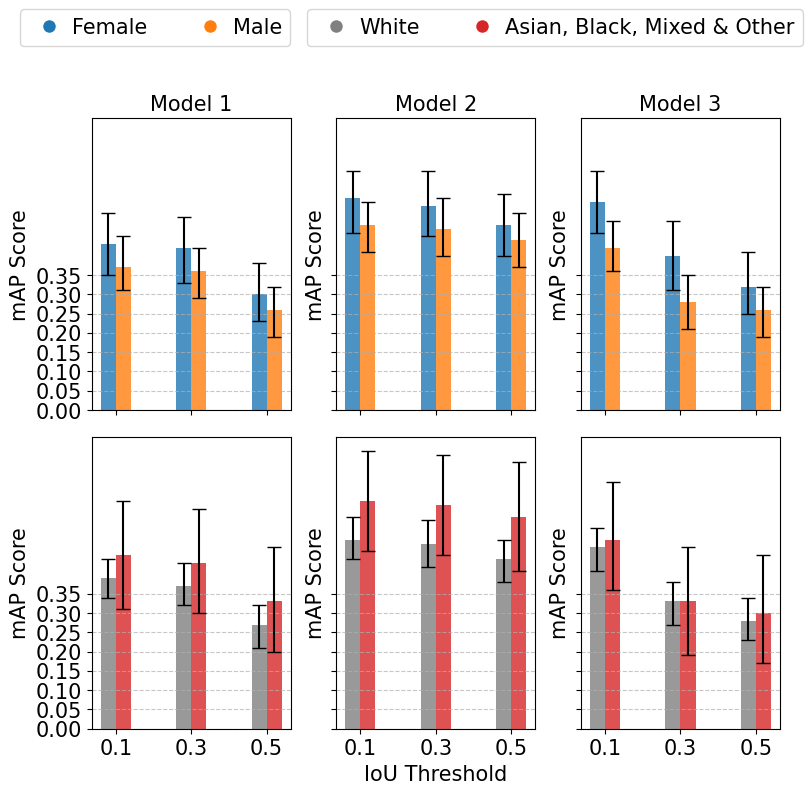

In [417]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
def plot_maps(dataset, map_data, flavour):
      # Example Data (Replace with your actual dataset)
      df = map_data.query('dataset == @dataset and flavour == @flavour').sort_values(['model','iou'])

      display(df)

      # Set up bar plot
      if flavour == 'male_only':
            fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(8, 4), sharey=True, sharex=True)
      elif flavour == 'white_only':
            fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(8, 4), sharey=True, sharex=True)
      else:
            fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(8, 8), sharey=True, sharex=True)

      # Define positions for bars
      bar_width = 0.2
      categories_top = ['FEMALE', 'MALE' ] if dataset == 'summit' else ['Female', 'Male']
      categories_bottom = ['Asian or Asian British', 'Black', 'White'] if dataset == 'summit' else ['White', 'Other']

      model_mappings = {
            'grt123': 'Model 1',
            'detection': 'Model 2',
            'ticnet': 'Model 3'
      }
      fontsize = 15

      # Define color-blind-friendly palette
      colors = {
            'Female': '#1f77b4',  # Blue
            'Male': '#ff7f0e',    # Orange
            'Asian': '#2ca02c',   # Green
            'Black': 'purple',   # Yellow
            'White': 'grey',   # Grey
            'Other': '#d62728'    # Red
      }

      # Plot bars for each model and category
      for i, model in enumerate(['grt123', 'detection', 'ticnet']):
            df_model = df.query('model == @model')

            if flavour != 'male_only':
                    # Top row plots
                    ax_top = axes[0, i] if flavour != 'white_only' else axes[i]
                    for j, category in enumerate(categories_top):
                              subset = df_model.query('category == @category')
                              positions = np.arange(len(subset['iou'].unique()))
                              ax_top.bar(
                                      positions + j * bar_width, 
                                      subset['map_mean'], 
                                      width=bar_width,
                                      yerr=[
                                                subset['map_error_lower'],
                                                subset['map_error_upper']
                                      ],
                                      capsize=5,
                                      label=category.replace('FEMALE','Female').replace('MALE','Male'),
                                      color=colors[category.replace('FEMALE','Female').replace('MALE','Male')],
                                      alpha=0.8
                              )
                              
                    ax_top.set_title(f'{model_mappings[model]}', fontsize=fontsize)
                    ax_top.set_xticks(positions + bar_width / 2)
                    ax_top.set_xticklabels(subset['iou'].unique(), fontsize=fontsize)

                    if flavour == 'white_only' and i == 1:
                              ax_top.set_xlabel("IoU Threshold", fontsize=fontsize)
   
                    ax_top.set_ylabel("mAP Score", fontsize=fontsize)
                    ax_top.set_yticks(np.arange(0, 0.36, 0.05))
                    ax_top.tick_params(axis='y', labelsize=fontsize)

                    ax_top.grid(axis="y", linestyle="--", alpha=0.7)


            if flavour != 'white_only':
                    # Bottom row plots
                    ax_bottom = axes[1, i] if flavour != 'male_only' else axes[i]
                    for j, category in enumerate(categories_bottom):
                              subset = df_model.query('category == @category')
                              positions = np.arange(len(subset['iou'].unique()))
                              ax_bottom.bar(
                                      positions + j * bar_width,
                                      subset['map_mean'],
                                      width=bar_width,
                                      yerr=[
                                                subset['map_error_lower'],
                                                subset['map_error_upper']
                                      ],
                                      capsize=5,
                                      label=category.replace('Asian or Asian British', 'Asian'),
                                      color=colors[category.replace('Asian or Asian British', 'Asian')],
                                      alpha=0.8
                              )
                    ax_bottom.set_xticks(positions + bar_width / 2)
                    ax_bottom.set_xticklabels(subset['iou'].unique(), fontsize=fontsize)

                    if flavour == 'male_only':
                              ax_bottom.set_title(f'{model_mappings[model]}', fontsize=fontsize)                  
                        
                    ax_bottom.set_ylabel("mAP Score", fontsize=fontsize)
                    ax_bottom.set_yticks(np.arange(0, 0.36, 0.05))
                    ax_bottom.tick_params(axis='y', labelsize=fontsize)

                    if i == 1:
                              ax_bottom.set_xlabel("IoU Threshold", fontsize=fontsize)

                    ax_bottom.grid(axis="y", linestyle="--", alpha=0.7)

    # Create legends for sex and ethnic group
      if flavour in ['test_balanced', 'white_only']:
            legend_elements_sex = [
                  Line2D([0], [0], marker='o', color='w', label='Female', markerfacecolor=colors['Female'], markersize=10),
                  Line2D([0], [0], marker='o', color='w', label='Male', markerfacecolor=colors['Male'], markersize=10)
            ]
            

      if flavour in ['test_balanced', 'male_only']:
            if dataset == 'summit':
                  legend_elements_ethnic = [
                        Line2D([0], [0], marker='o', color='w', label='Asian', markerfacecolor=colors['Asian'], markersize=10),
                        Line2D([0], [0], marker='o', color='w', label='Black', markerfacecolor=colors['Black'], markersize=10),
                        Line2D([0], [0], marker='o', color='w', label='White', markerfacecolor=colors['White'], markersize=10)
                  ]
            else:
                  legend_elements_ethnic = [
                        Line2D([0], [0], marker='o', color='w', label='White', markerfacecolor=colors['White'], markersize=10),
                        Line2D([0], [0], marker='o', color='w', label='Asian, Black, Mixed & Other', markerfacecolor=colors['Other'], markersize=10)                        
                  ]


      if flavour == "test_balanced":
            fig.legend(
                    handles=legend_elements_sex,
                    loc='upper center',
                    ncol=len(legend_elements_sex),
                    bbox_to_anchor=(0.20, 1),
                    fontsize=fontsize,
                    frameon=True,
                    handletextpad=0.1 if dataset == 'lsut' else 1
            )

            fig.legend(
                    handles=legend_elements_ethnic,
                    loc='upper center',
                    ncol=len(legend_elements_ethnic),
                    bbox_to_anchor=(0.70, 1),
                    fontsize=fontsize,
                    frameon=True,
                    handletextpad=0.1 if dataset == 'lsut' else 1
            )

      elif flavour == 'white_only':
            fig.legend(handles=legend_elements_sex, loc='upper center', ncol=2, fontsize=fontsize, frameon=True)
      
      elif flavour == 'male_only':
            fig.legend(handles=legend_elements_ethnic, loc='upper center', ncol=3, fontsize=fontsize, frameon=True)


      # Adjust layout to make space for the legend and suptitle
      if flavour in ['male_only', 'white_only']:
            plt.tight_layout(rect=[0, 0, 1, 0.9])  # Leave more space at the top
      else:
            plt.tight_layout(rect=[0, 0, 1, 0.90])

      # plt.savefig(f'results/extension/images/{dataset}_{flavour}_mAP_plot.png', bbox_inches='tight')            
      plt.show()

for flavour in ['test_balanced', 'male_only', 'white_only']:
      print('*'*80)
      print(f"Flavour: {flavour}")
      plot_maps('summit', map_data, flavour)

for flavour in ['test_balanced']:
      print('*'*80)
      print(f"Flavour: {flavour}")
      plot_maps('lsut', map_data, flavour)

Dataset: summit, Model: detection, Flavour: male_only
Dataset: summit, Model: grt123, Flavour: male_only
Dataset: summit, Model: detection, Flavour: white_only
Dataset: summit, Model: ticnet, Flavour: test_balanced
Dataset: summit, Model: ticnet, Flavour: male_only
Dataset: summit, Model: grt123, Flavour: white_only
Dataset: summit, Model: grt123, Flavour: test_balanced
Dataset: summit, Model: detection, Flavour: test_balanced
Dataset: summit, Model: ticnet, Flavour: white_only
Dataset: lsut, Model: ticnet, Flavour: test_balanced
Dataset: lsut, Model: grt123, Flavour: test_balanced
Dataset: lsut, Model: detection, Flavour: test_balanced
********************************************************************************
Flavour: test_balanced


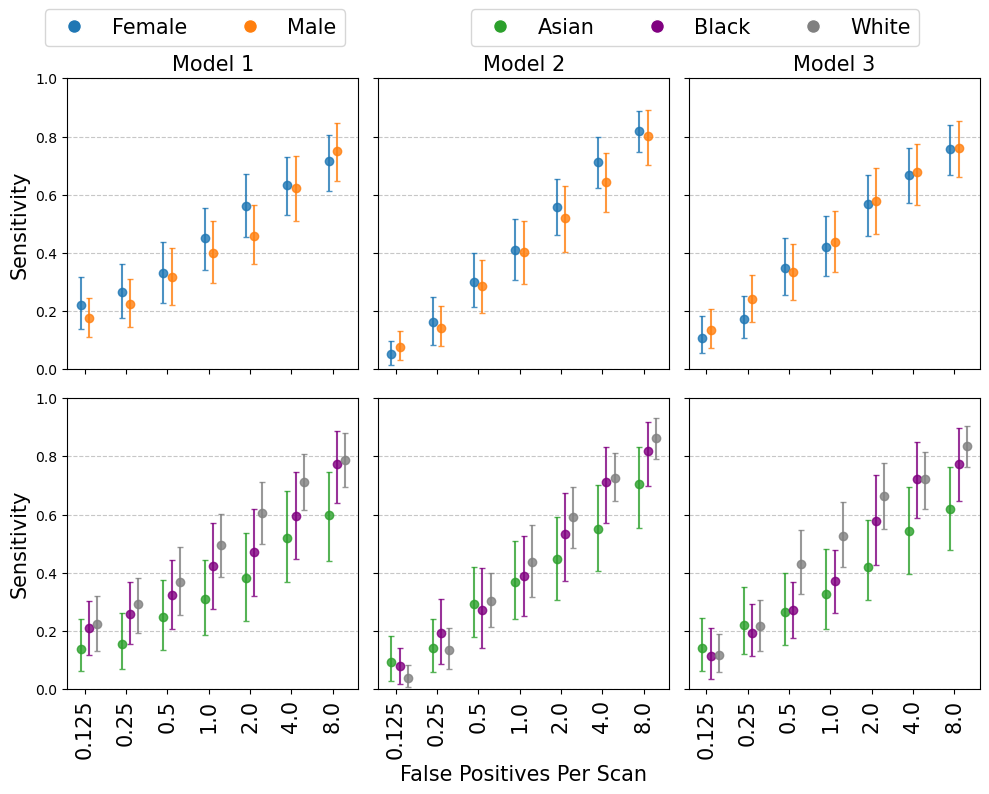

********************************************************************************
Flavour: male_only


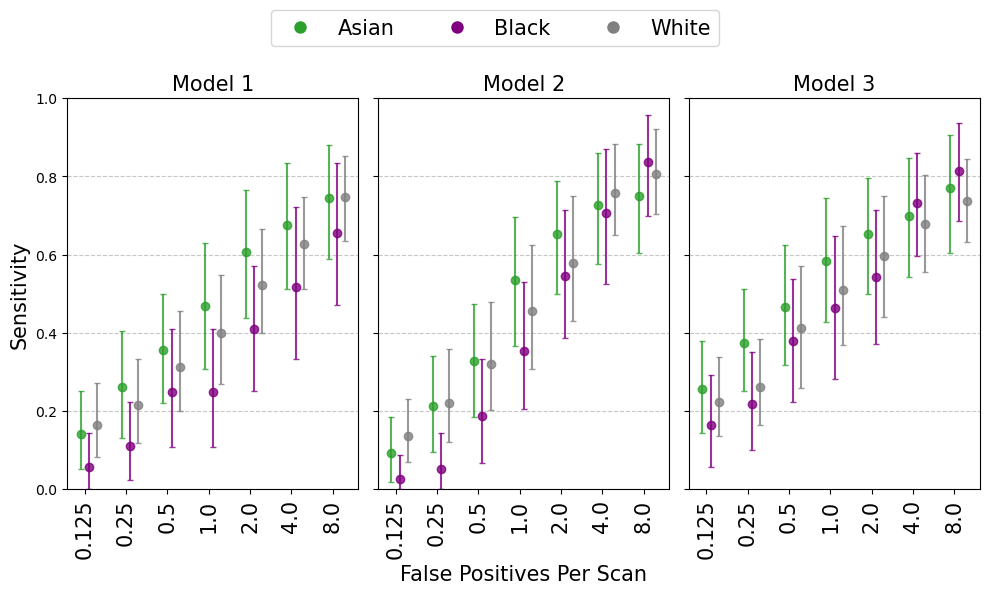

********************************************************************************
Flavour: white_only


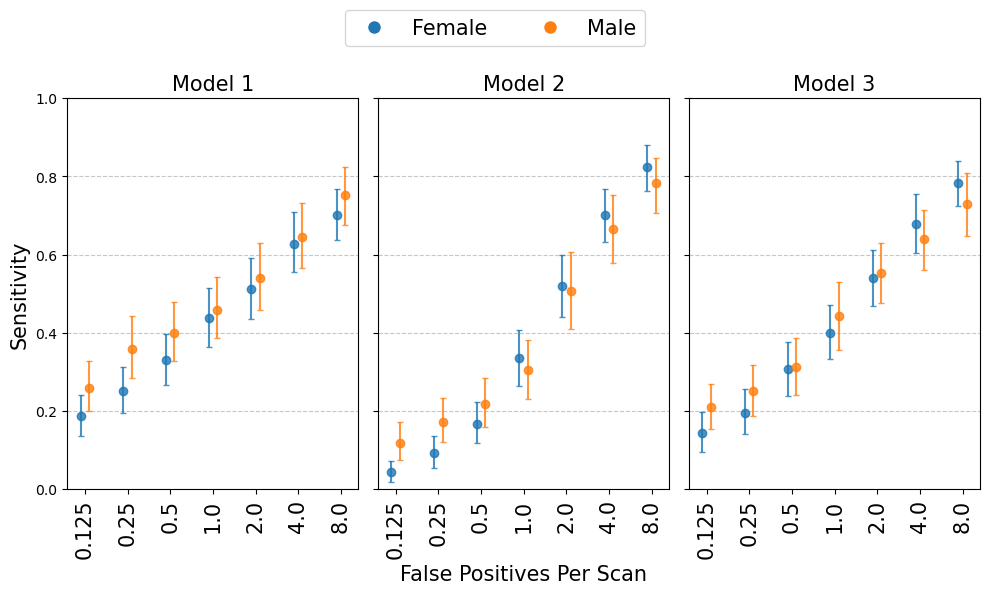

********************************************************************************
Flavour: test_balanced


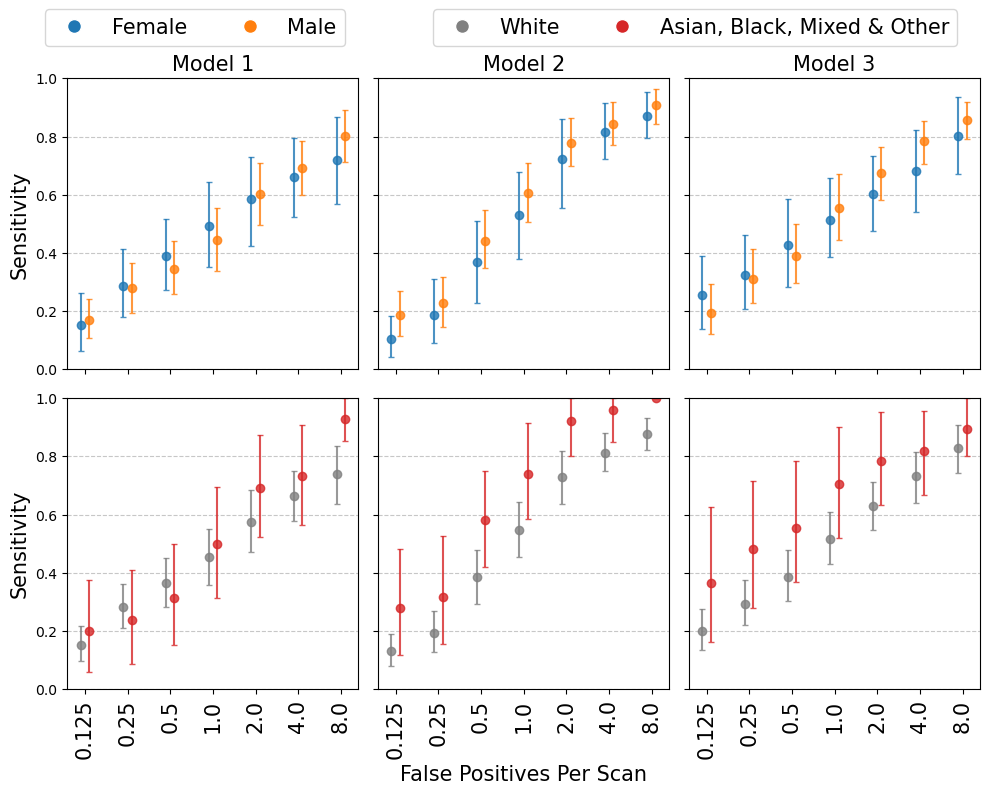

In [311]:
# Combine fixed froc data
from pathlib import Path
import json

p = Path('/Users/john/Projects/SOTAEvaluationNoduleDetection/workflows/FairnessInNoduleDetectionAlgorithms/results/summit/detection_test_balanced_froc_fixed_thresholds.json')
json_data = json.load(p.open())

fpps_recode = {0 : 0.125, 1 : 0.25, 2 : 0.5, 3 : 1, 4 : 2, 5 : 4, 6 : 8}

data_list = []

for path in Path('results').rglob('*_froc_fixed_thresholds.json'):

    path_parts = path.parts
    dataset = path_parts[-2]
    filename = path.stem
    model = filename.split('_')[0]
    flavour = '_'.join(filename.split('_')[1:3])

    print(f"Dataset: {dataset}, Model: {model}, Flavour: {flavour}")

    json_data = json.load(path.open())

    for category, data in json_data.items():
        data_list.append(
            pd.DataFrame.from_dict(data, orient='index')
            .rename(columns={'mean_sens':'mean_sens', 'lower_sens':'low_sens', 'upper_sens':'high_sens'})
            .reset_index().rename(columns={'index':'threshold'})
            .reset_index().rename(columns={'index':'fpps'})
            .assign(fpps=lambda df: df['fpps'].map(fpps_recode))
            .assign(category=category)
            .assign(dataset=dataset)
            .assign(model=model)
            .assign(flavour=flavour)
        )

froc_data = pd.concat(data_list)
froc_data.query('dataset == "summit" and flavour == "test_balanced" and category == "Black" and fpps == 0.125')


for flavour in ['test_balanced', 'male_only', 'white_only']:
      print('*'*80)
      print(f"Flavour: {flavour}")
      plot_frocs('summit', froc_data, flavour)

for flavour in ['test_balanced']:
      print('*'*80)
      print(f"Flavour: {flavour}")
      plot_frocs('lsut', froc_data, flavour)


# Combine the nodule characteristics images

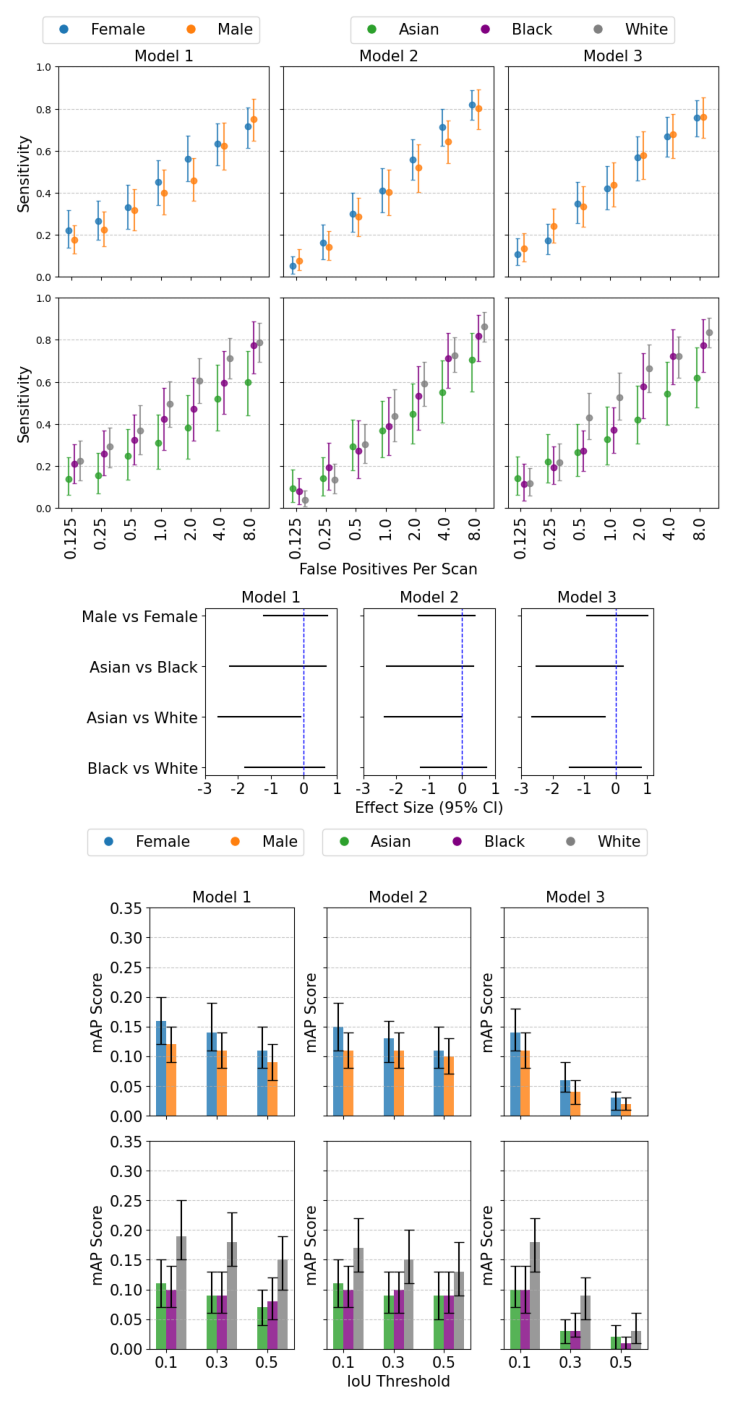

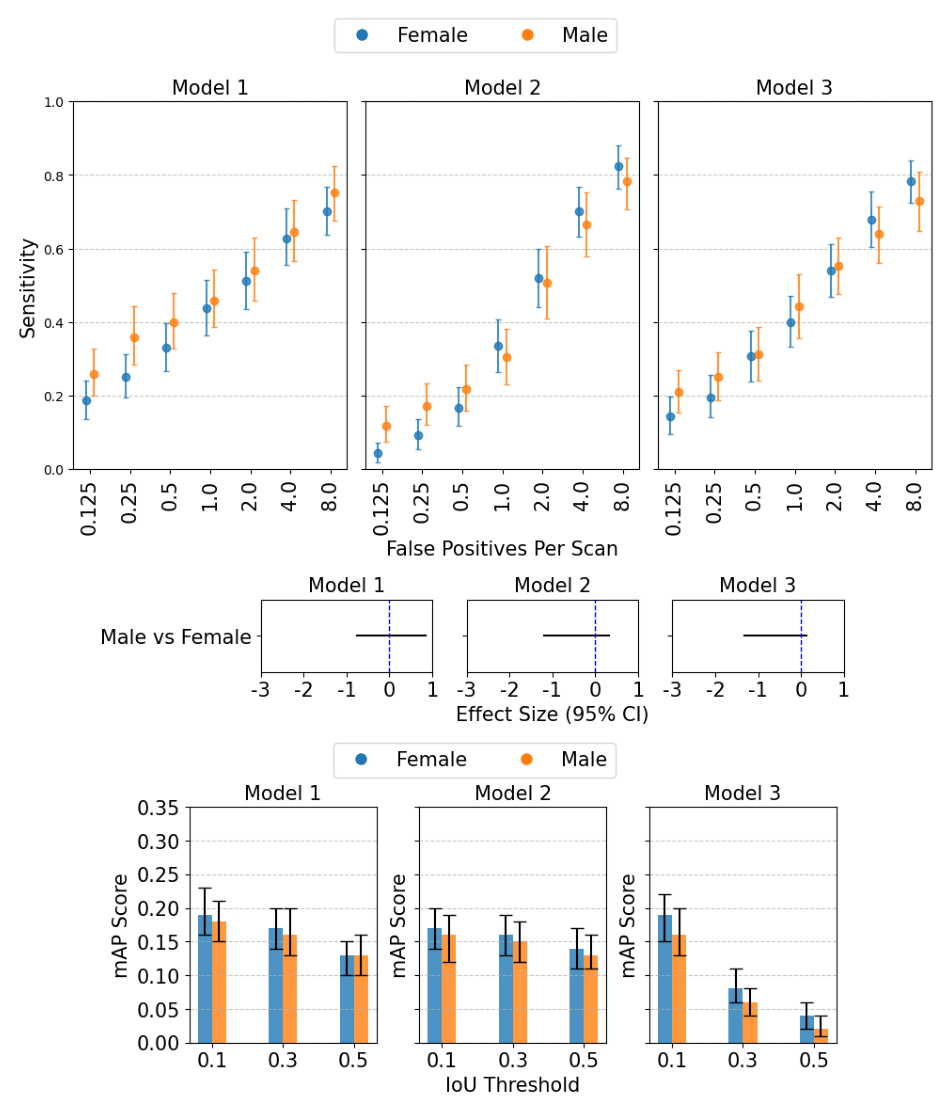

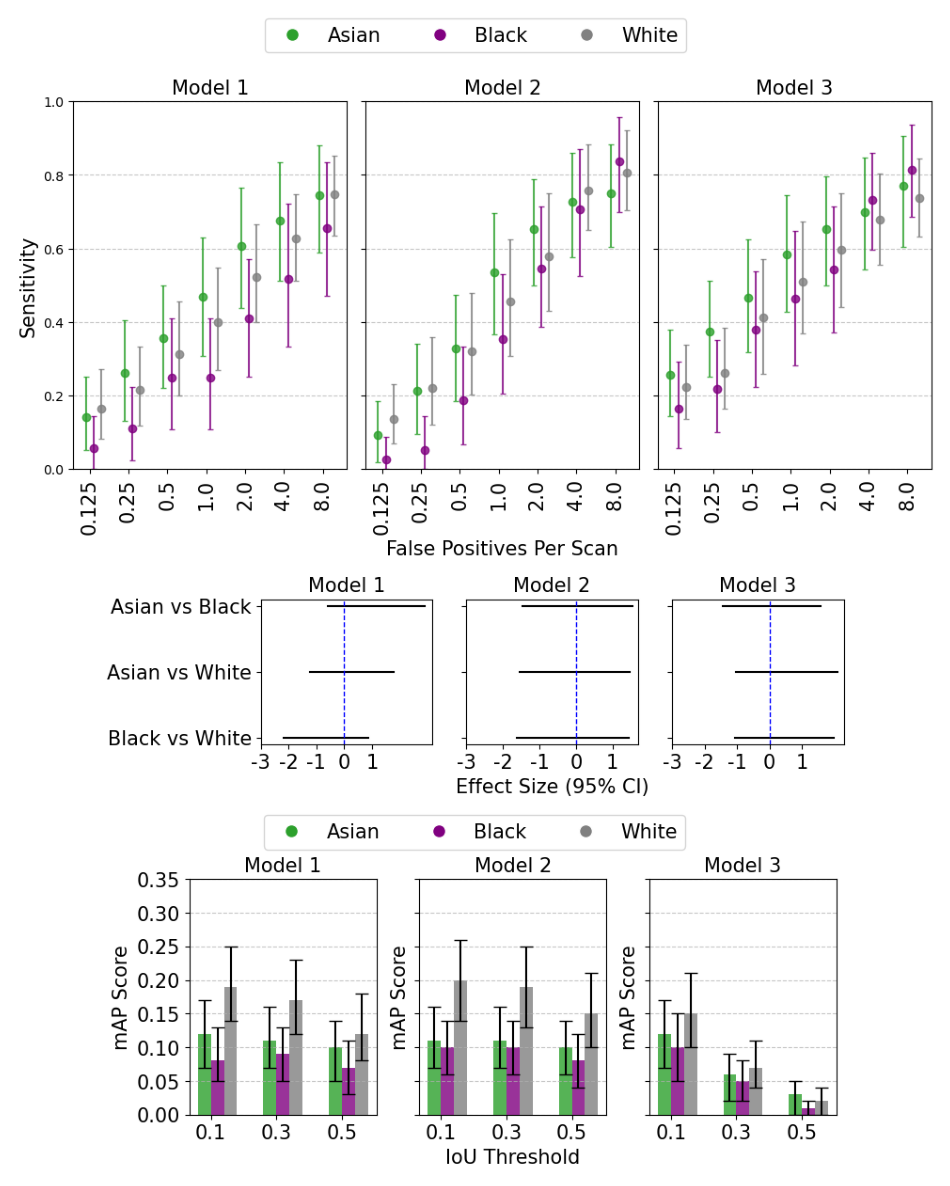

In [312]:
from PIL import Image
import matplotlib.pyplot as plt

dataset = "summit"
for flavour in ['test_balanced', 'white_only', 'male_only']:
    # Load the images
    error_bar_plot = Image.open(f'results/extension/images/{dataset}_{flavour}_error_bar_plot.png')
    ci_plot = Image.open(f'results/extension/images/{dataset}_{flavour}_ci_plot.png')
    mAP_plot = Image.open(f'results/extension/images/{dataset}_{flavour}_mAP_plot.png')

    # Get the dimensions of the images
    width1, height1 = error_bar_plot.size
    width2, height2 = ci_plot.size
    width3, height3 = mAP_plot.size


    padding = 0

    # Centralise and white fill extra space for ci_plot
    if width2 < max(width1, width3):
        new_ci_plot = Image.new("RGBA", (max(width1, width3), height2 + padding), "white")
        new_ci_plot.paste(ci_plot, ((max(width1, width3) - width2) // 2, 0))
        ci_plot = new_ci_plot

    # Centralise and white fill extra space for mAP_plot
    if width3 < max(width1, width2):
        new_mAP_plot = Image.new("RGBA", (max(width1, width2), height3 + padding), "white")
        new_mAP_plot.paste(mAP_plot, ((max(width1, width2) - width3) // 2, 0))
        mAP_plot = new_mAP_plot

    # Create a new image with a size that can fit all three images vertically
    combined_width = max(width1, width2, width3)
    combined_height = height1 + (height2 + padding) + (height3 + padding)
    combined_img = Image.new("RGB", (combined_width, combined_height), "white")

    # Paste the images into the combined image
    combined_img.paste(error_bar_plot, (0, 0))
    combined_img.paste(ci_plot, (0, height1))
    combined_img.paste(mAP_plot, (0, height1 + (height2 + padding)))

    # Save the combined image
    combined_img.save(f'results/extension/images/{dataset}_{flavour}_combined_plot.png')

    # Display the combined image using matplotlib
    fig, ax = plt.subplots(figsize=(12, 18))
    ax.imshow(combined_img)
    ax.axis('off')  # Hide the axis
    plt.show()

# Nodule Characteristics

In [313]:

from pathlib import Path
from tkinter.tix import InputOnly
import pandas as pd

for dataset in ['summit','lsut']:

 

    # Adjust layout to make space for the legend
    plt.tight_layout(rect=[0, 0, 1, 0.9])
    plt.savefig(f'results/extension/images/{dataset}_nodule_type_froc_plot.png', bbox_inches='tight')



<Figure size 640x480 with 0 Axes>

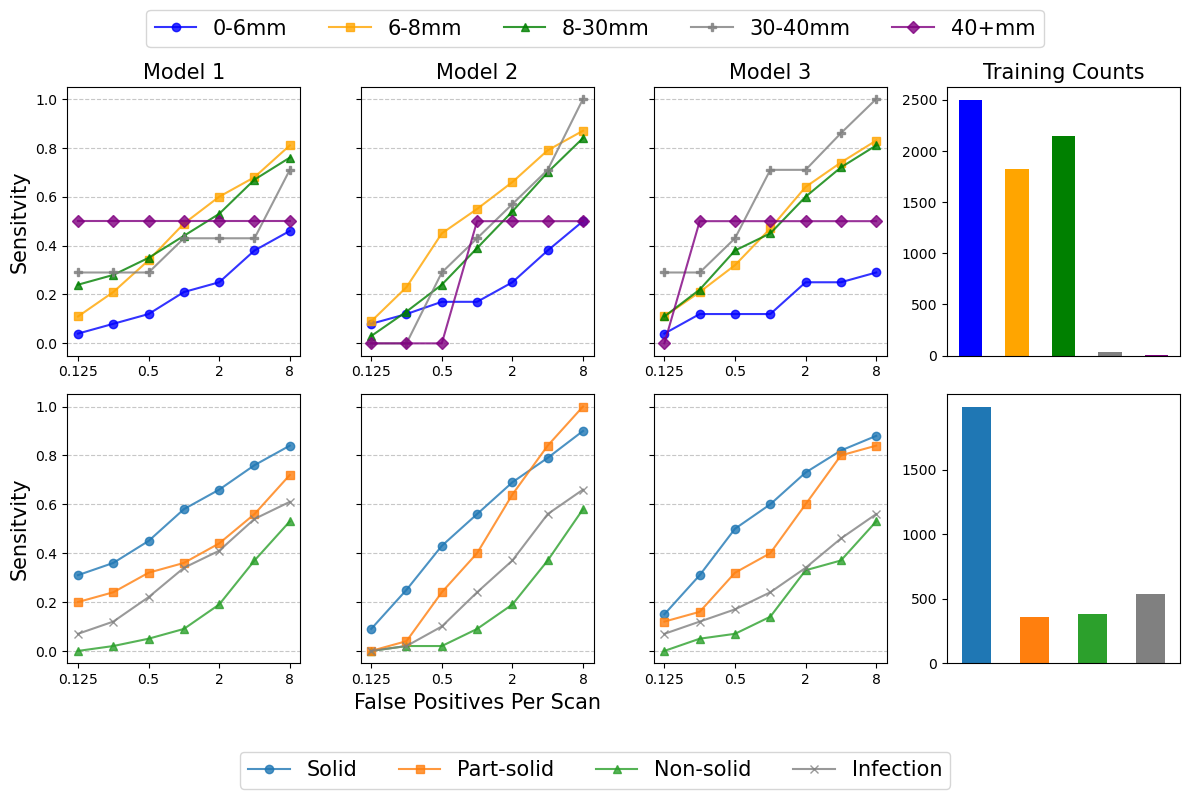

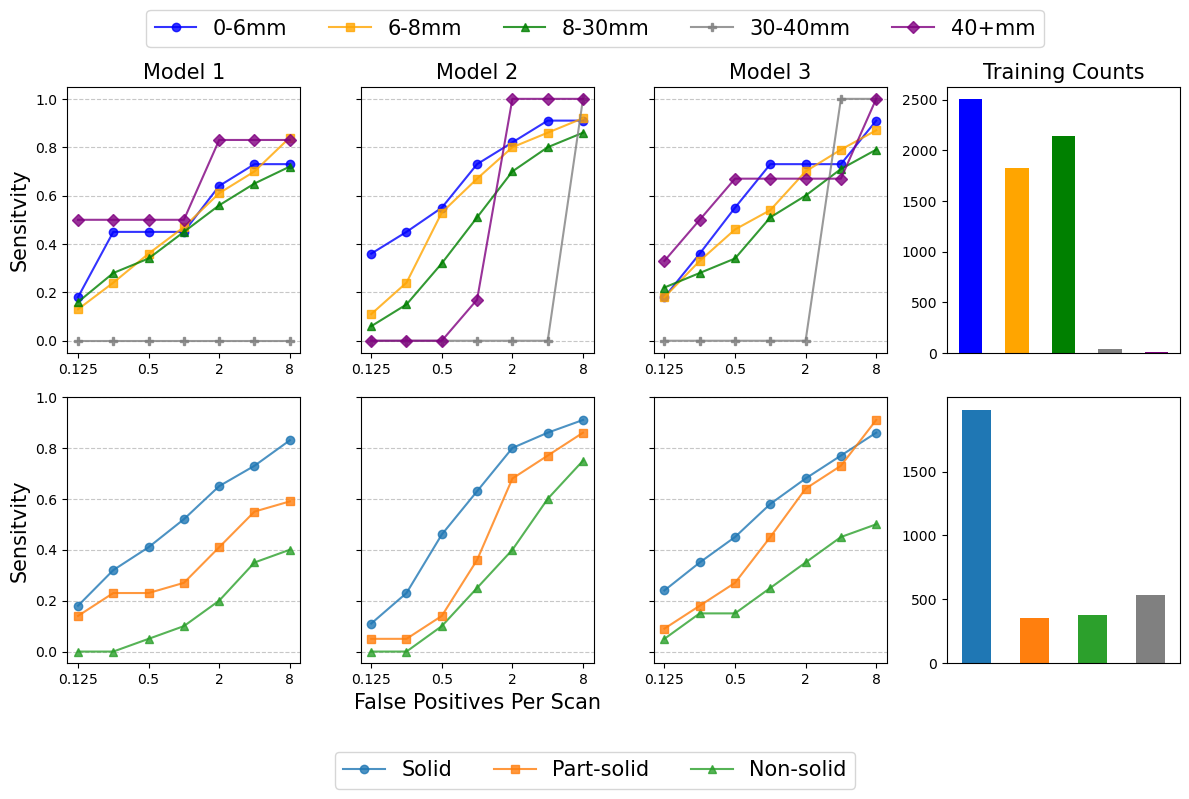

In [314]:
from pathlib import Path
from tkinter.tix import InputOnly
from networkx import diameter
import pandas as pd

diameter_cats = [0, 6, 8, 30, 40, 999]

diameter_lbs = [
    '0-6mm',
    '6-8mm',
    '8-30mm',
    '30-40mm',
    '40+mm'
] 

diameter_colors = {
    '0-6mm' : 'blue', 
    '6-8mm' : 'orange', 
    '8-30mm' : 'green', 
    '30-40mm' : 'grey', 
    '40+mm' : 'purple'
}

diameter_mappings = {
    '0-6mm' : '0-6mm', 
    '6-8mm' : '6-8mm', 
    '8-30mm' : '8-30mm', 
    '30-40mm' : '30-40mm', 
    '40+mm' : '40+mm'
}

diameter_markings = {
    '0-6mm' : 'o',       # Circle
    '6-8mm' : 's',       # Square
    '8-30mm' : '^',      # Triangle
    '30-40mm' : 'P',     # Plus
    '40+mm' : 'D'        # Diamond
}

nodule_colors = {
    'SOLID' : '#1f77b4',  # Blue
    'PART_SOLID' : '#ff7f0e',    # Orange
    'NON_SOLID' : '#2ca02c',   # Green
    'CALCIFIED' : 'grey',    # Purple
}

nodule__mappings = {
    'SOLID' : 'Solid',
    'PART_SOLID' : 'Part-Solid',
    'NON_SOLID' : 'Non-Solid',
    'CALCIFIED' : 'Infection'
}

nodule_markings = {
    'SOLID' : 'o', 
    'PART_SOLID' : 's', 
    'NON_SOLID' : '^', 
    'CALCIFIED' : 'x'
}

for dataset in ['summit','lsut']:

    diameter_data = (
        pd.concat([
            pd.read_csv(f'results/{dataset}/grt123/test_balanced/Actionable/FROC/diameter_cats_nodule_characteristics.csv').assign(model='grt123'),
            pd.read_csv(f'results/{dataset}/detection/test_balanced/Actionable/FROC/diameter_cats_nodule_characteristics.csv').assign(model='detection'),
            pd.read_csv(f'results/{dataset}/ticnet/test_balanced/Actionable/FROC/diameter_cats_nodule_characteristics.csv').assign(model='ticnet')
        ])
        .assign(dataset=dataset)
    )

    nodule_type_data = (
        pd.concat([
            pd.read_csv(f'results/{dataset}/grt123/test_balanced/Actionable/FROC/nodule_type_nodule_characteristics.csv').assign(model='grt123'),
            pd.read_csv(f'results/{dataset}/detection/test_balanced/Actionable/FROC/nodule_type_nodule_characteristics.csv').assign(model='detection'),
            pd.read_csv(f'results/{dataset}/ticnet/test_balanced/Actionable/FROC/nodule_type_nodule_characteristics.csv').assign(model='ticnet')
        ])
        .assign(dataset=dataset)
    )

    if dataset == 'lsut':
        nodule_type_data = nodule_type_data.query('nodule_type != "CALCIFIED"')

    # Generate the plot
    fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(12, 8))

 
    for ix, model in enumerate(['grt123', 'detection', 'ticnet']):

        subset = diameter_data.query('model == @model')
        subset = subset.set_index('diameter_cats').filter(['0.125', '0.25', '0.5', '1', '2', '4', '8'])

        subset.T.plot(
            ax=axes[0, ix], 
            marker='o',  # Default marker
            linestyle='-', 
            alpha=0.8, 
            color=[diameter_colors[diameter_cat] for diameter_cat in subset.index], 
            label=[diameter_mappings[diameter_cat] for diameter_cat in subset.index]
        )

        for line, diameter_cat in zip(axes[0, ix].get_lines(), subset.index):
            line.set_marker(diameter_markings[diameter_cat])  # Update marker for each line
        
        axes[0, ix].set_title(f'{model_mappings[model]}', fontsize=fontsize)

        if ix == 0:
            axes[0, ix].set_ylabel('Sensitvity', fontsize=fontsize)

        axes[0, ix].grid(axis="y", linestyle="--", alpha=0.7)
        axes[0, ix].set_yticks([i * 0.2 for i in range(6)])  # Set yticks from 0 to 1 in 0.2 increments
        axes[0, ix].legend().remove()  # Remove in-axis legend

        subset = nodule_type_data.query('model == @model')
        subset = subset.set_index('nodule_type').filter(['0.125', '0.25', '0.5', '1', '2', '4', '8'])

        subset.T.plot(
            ax=axes[1, ix], 
            marker='o', 
            linestyle='-', 
            alpha=0.8, 
            color=[nodule_colors[nodule_type] for nodule_type in subset.index], 
            label=[nodule__mappings[nodule_type] for nodule_type in subset.index]
        )

        for line, nodule_type in zip(axes[1, ix].get_lines(), subset.index):
            line.set_marker(nodule_markings[nodule_type])  # Update marker for each line

        if ix == 1:
            axes[1, ix].set_xlabel('False Positives Per Scan', fontsize=fontsize)

        if ix == 0:
            axes[1, ix].set_ylabel('Sensitvity', fontsize=fontsize)

        axes[1, ix].grid(axis="y", linestyle="--", alpha=0.7)
        axes[1, ix].set_yticks([i * 0.2 for i in range(6)])  # Set yticks from 0 to 1 in 0.2 increments
        axes[1, ix].legend().remove()  # Remove in-axis legend

        # Set shared y-axis for the top row
        axes[0, 0].get_shared_y_axes().join(axes[0, 0], axes[0, 1], axes[0, 2])

        # Set shared y-axis for the bottom row
        axes[1, 0].get_shared_y_axes().join(axes[1, 0], axes[1, 1], axes[1, 2])

    # Add a single legend above all plots
    nodule_handles, nodule_labels = axes[1,0].get_legend_handles_labels()
    # Reverse the order of handles and labels to match the desired order
    nodule_reversed_order = ['SOLID', 'PART_SOLID', 'NON_SOLID', 'CALCIFIED'] if dataset == 'summit' else ['SOLID', 'PART_SOLID', 'NON_SOLID']
    nodule_handles = [nodule_handles[nodule_labels.index(category)] for category in nodule_reversed_order]
    nodule_labels = nodule_reversed_order

    # Add a single legend above all plots
    diameter_handles, diameter_labels = axes[0,0].get_legend_handles_labels()
    # Reverse the order of handles and labels to match the desired order
    diameter_reversed_order = ['0-6mm', '6-8mm', '8-30mm', '30-40mm', '40+mm']
    diameter_handles = [diameter_handles[diameter_labels.index(category)] for category in diameter_reversed_order]
    diameter_labels = diameter_reversed_order

    fig.legend(
        diameter_handles, 
        diameter_labels,
        loc='upper center',
        ncol=len(diameter_labels),
        fontsize=fontsize,
        frameon=True
    )

    fig.legend(
        nodule_handles, 
        ['Solid', 'Part-solid', 'Non-solid', 'Infection'] if dataset == 'summit' else ['Solid', 'Part-solid', 'Non-solid'],
        loc='lower center',
        ncol=len(nodule_labels),
        fontsize=fontsize,
        frameon=True
    )

    training_nodule_vc = (
        pd.read_csv('../../metadata/summit/test_balanced/training_metadata.csv', usecols=['nodule_type'])
        .query('nodule_type in ["SOLID","PART_SOLID","NON_SOLID","CALCIFIED"]')['nodule_type']
        .value_counts()
        .rename('training')
    )

    training_diameter_vc = (
        pd.read_csv('../../metadata/summit/test_balanced/training_metadata.csv', usecols=['nodule_diameter_mm'])
        .assign(diameter_cats=lambda df: pd.cut(df['nodule_diameter_mm'], bins=diameter_cats,labels=diameter_lbs))['diameter_cats']          
        .value_counts()
        .rename('training')
    )

    # Plot training_diameter_vc as a bar plot on ax[0,4]
    training_diameter_vc = training_diameter_vc.reindex(diameter_mappings.keys())
    training_diameter_vc.plot.bar(ax=axes[0, 3], color=[diameter_colors[cat] for cat in training_diameter_vc.index])
    axes[0, 3].set_xticks([])  # Remove xticks
    axes[0, 3].set_yticks(range(0, training_diameter_vc.max() + 1, 500))  # Add yticks
    axes[0, 3].set_title('Training Counts', fontsize=fontsize)

    # Plot training_nodule_vc as a bar plot on ax[1,4]
    training_nodule_vc = training_nodule_vc.reindex(nodule__mappings.keys())
    training_nodule_vc.plot.bar(ax=axes[1, 3], color=[nodule_colors[cat] for cat in training_nodule_vc.index])
    axes[1, 3].set_xticks([])  # Remove xticks
    axes[1, 3].set_yticks(range(0, training_nodule_vc.max() + 1, 500))  # Add yticks



    # Adjust layout to make space for the legends
    plt.tight_layout(rect=[0, 0.09, 1, 0.94])  # Shift closer to top legend and give more space to bottom legend
    plt.savefig(f'results/extension/images/{dataset}_nodule_characteristics_froc_plot.png', bbox_inches='tight')

training  test
PERIFISSURAL      3292     0
SOLID             1984   121
CALCIFIED          533    41
NON_SOLID          377    43
PART_SOLID         355    25

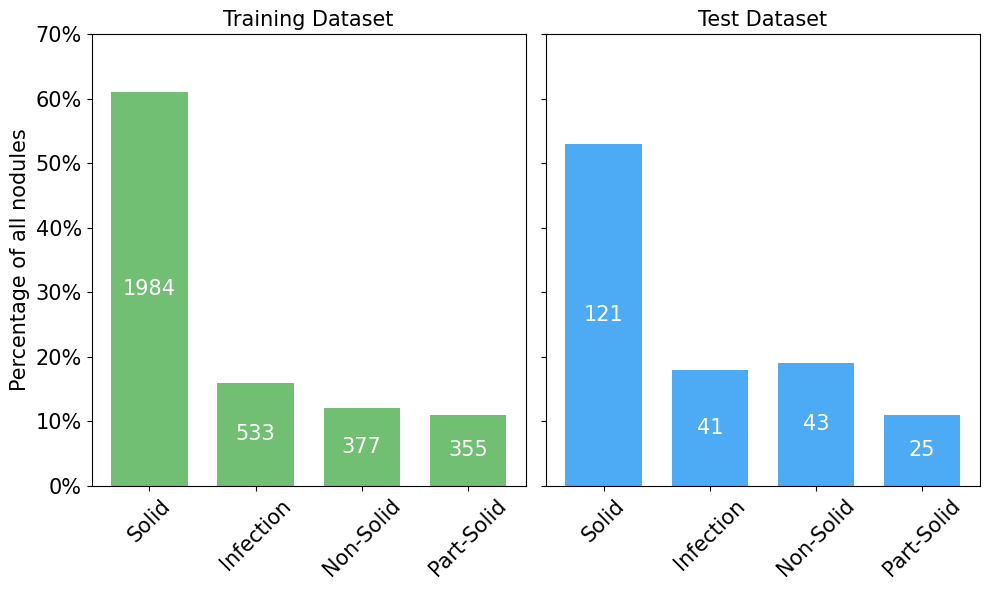

Chi-square Test Results:
Chi2 Statistic: 11.75107490490566
P-value: 0.008286386201001958
Degrees of Freedom: 3
Expected Frequencies:
[[1965.83644725  139.16355275]
 [ 536.05231388   37.94768612]
 [ 392.2334004    27.7665996 ]
 [ 354.87783846   25.12216154]]
There is a statistically significant difference between the training and test datasets.


training  test
PERIFISSURAL      3292     0
SOLID             1984   168
CALCIFIED          533     0
NON_SOLID          377    20
PART_SOLID         355    74

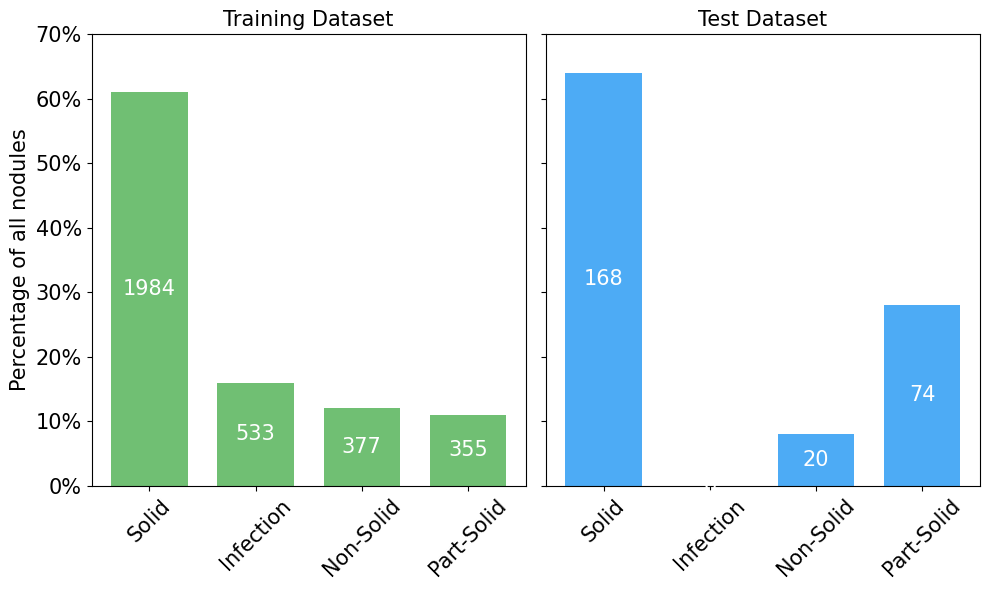

Chi-square Test Results:
Chi2 Statistic: 106.23908155989184
P-value: 7.072785046744214e-23
Degrees of Freedom: 3
Expected Frequencies:
[[1991.4121333   160.5878667 ]
 [ 493.2261464    39.7738536 ]
 [ 367.37482199   29.62517801]
 [ 396.98689832   32.01310168]]
There is a statistically significant difference between the training and test datasets.


In [315]:
from scipy.stats import chi2_contingency
import test

lsut_maps = {
    'CALCIFIED': 'CALCIFIED',
    'NON-SOLID': 'NON_SOLID',
    'PART-SOLID': 'PART_SOLID',
    'SOLID': 'SOLID',
    'PERIFISSURAL': 'PERIFSSURAL'
}


colors = {
    'SOLID' : '#1f77b4',  # Blue
    'PART_SOLID' : '#ff7f0e',    # Orange
    'NON_SOLID' : '#2ca02c',   # Green
    'CALCIFIED' : 'grey',    # Purple
}

category_mappings = {
    'SOLID' : 'Solid',
    'PART_SOLID' : 'Part-Solid',
    'NON_SOLID' : 'Non-Solid',
    'CALCIFIED' : 'Infection'
}

for dataset in ['summit', 'lsut']:
    
    training_nodule_vc = pd.read_csv('../../metadata/summit/test_balanced/training_metadata.csv', usecols=['nodule_type'])['nodule_type'].value_counts().rename('training')

    if dataset == 'summit':
        test_nodule_vc = (
            pd.read_csv('../../metadata/summit/test_balanced/test_metadata.csv', usecols=['management_plan', 'nodule_type'])
            .assign(Actionable=lambda df: df['management_plan'] != 'RANDOMISATION_AT_YEAR_1')
            .query('Actionable == True')['nodule_type']
            .value_counts()
            .rename('test')
        )
    else:
        test_nodule_vc = (
            pd.read_csv('../../metadata/lsut/lsut_metadata.csv',usecols=['actionable', 'nodule_type'])
            .query('actionable == True')['nodule_type']
            .map(lsut_maps)
            .value_counts()
            .rename('test')
        )        





    nodule_vc = pd.concat([training_nodule_vc, test_nodule_vc], axis=1).fillna(0).astype(int)

    display(nodule_vc)

    nodule_vc = nodule_vc[(nodule_vc.index != 'PERIFISSURAL')]
    nodule_vc.index = nodule_vc.index.map(category_mappings)

    nodule_vc['training_percentage'] = np.round((nodule_vc['training'] / nodule_vc['training'].sum()) * 100)
    nodule_vc['test_percentage'] = np.round((nodule_vc['test'] / nodule_vc['test'].sum()) * 100)

    # Define bar width and positions
    bar_width = 0.4
    positions = np.arange(len(nodule_vc.index))

    # Create subplots for training and test data
    fig, axes = plt.subplots(ncols=2, figsize=(10, 6), sharey=True)

    # Define modern colors
    training_color = '#4CAF50'  # Green
    test_color = '#2196F3'      # Blue

    # Plot training percentages
    bars1 = axes[0].bar(positions, nodule_vc['training_percentage'], bar_width * 1.8, label='Training', alpha=0.8, color=training_color)
    for bar, absolute in zip(bars1, nodule_vc['training']):
        axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f'{absolute}', ha='center', va='center', fontsize=15, color='white')

    # Plot test percentages
    bars2 = axes[1].bar(positions, nodule_vc['test_percentage'], bar_width * 1.8, label='Test', alpha=0.8, color=test_color)
    for bar, absolute in zip(bars2, nodule_vc['test']):
        axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f'{absolute}', ha='center', va='center', fontsize=15, color='white')
        # Set labels, titles, and ticks for training axis
        # axes[0].set_xlabel('Nodule Type', fontsize=15)
        axes[0].set_ylabel('Percentage of all nodules', fontsize=15)
        axes[0].set_title('Training Dataset', fontsize=15)
        axes[0].set_xticks(positions)
        axes[0].set_xticklabels(nodule_vc.index, fontsize=15, rotation=45)
        axes[0].set_yticks(range(0, 71, 10))
        axes[0].set_yticklabels([f'{ytick}%' for ytick in range(0, 71, 10)], fontsize=15)

        # Set labels, titles, and ticks for test axis
        # axes[1].set_xlabel('Nodule Type', fontsize=15)
        axes[1].set_title('Test Dataset', fontsize=15)
        axes[1].set_xticks(positions)
        axes[1].set_xticklabels(nodule_vc.index, fontsize=15, rotation=45)
        axes[1].set_yticks(range(0, 71, 10))
        axes[1].set_yticklabels([f'{ytick}%' for ytick in range(0, 71, 10)], fontsize=15)

    # Show the plot
    plt.tight_layout()
    plt.savefig('results/extension/images/summit_nodule_type_distribution.png', bbox_inches='tight')
    plt.show()


    # Perform chi-square test
    chi2, p, dof, expected = chi2_contingency(nodule_vc[['training', 'test']])

    print("Chi-square Test Results:")
    print(f"Chi2 Statistic: {chi2}")
    print(f"P-value: {p}")
    print(f"Degrees of Freedom: {dof}")
    print("Expected Frequencies:")
    print(expected)

    if p < 0.05:
        print("There is a statistically significant difference between the training and test datasets.")
    else:
        print("There is no statistically significant difference between the training and test datasets.")

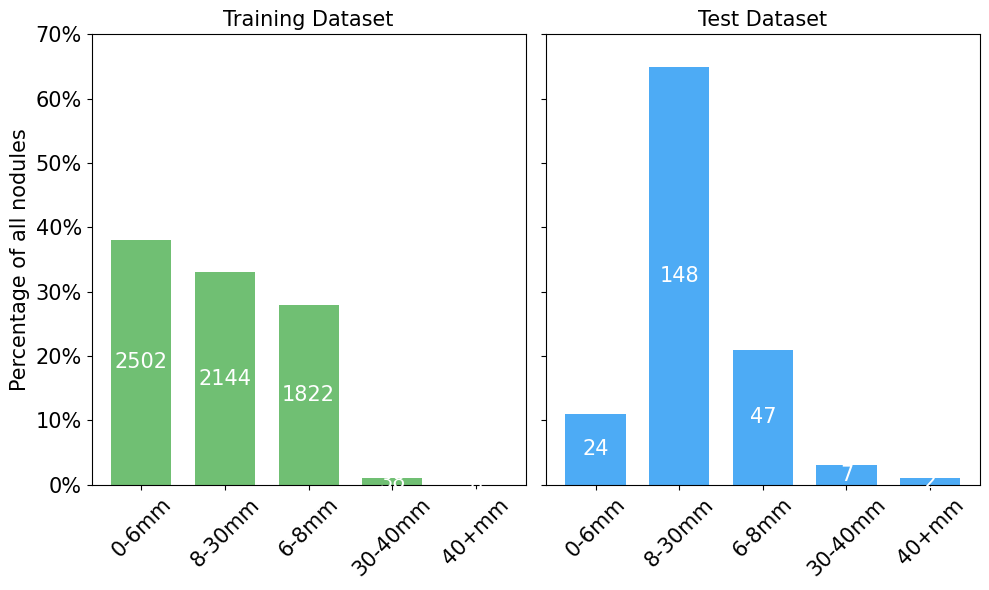

Chi-square Test Results:
Chi2 Statistic: 145.22401951516736
P-value: 2.147600603794828e-30
Degrees of Freedom: 4
Expected Frequencies:
[[2.44057609e+03 8.54239098e+01]
 [2.21448947e+03 7.75105310e+01]
 [1.80579442e+03 6.32055770e+01]
 [4.34781964e+01 1.52180362e+00]
 [9.66182142e+00 3.38178582e-01]]
There is a statistically significant difference between the training and test datasets.


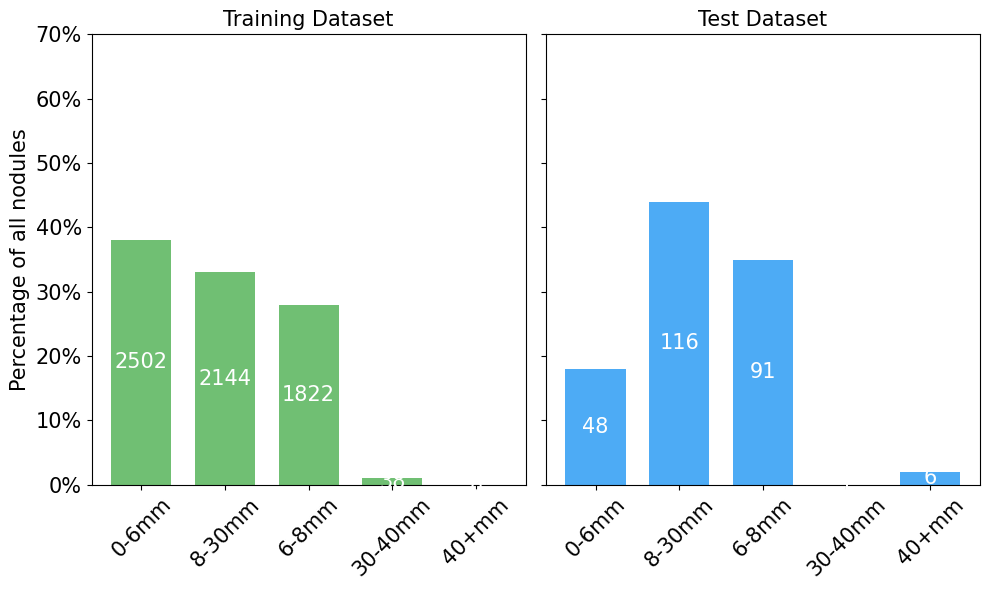

Chi-square Test Results:
Chi2 Statistic: 98.27393830313247
P-value: 2.2921525437503482e-20
Degrees of Freedom: 4
Expected Frequencies:
[[2.45140201e+03 9.85979929e+01]
 [2.17261511e+03 8.73848878e+01]
 [1.83903217e+03 7.39678276e+01]
 [3.74920307e+01 1.50796930e+00]
 [1.34586777e+01 5.41322314e-01]]
There is a statistically significant difference between the training and test datasets.


In [316]:
from scipy.stats import chi2_contingency

colors = {
    '0-6mm' : 'blue', 
    '6-8mm' : 'orange', 
    '8-30mm' : 'green', 
    '30-40mm' : 'grey', 
    '40+mm' : 'purple'
}

category_mappings = {
    '0-6mm' : '0-6mm', 
    '6-8mm' : '6-8mm', 
    '8-30mm' : '8-30mm', 
    '30-40mm' : '30-40mm', 
    '40+mm' : '40+mm'
}

diameter_cats = [0, 6, 8, 30, 40, 999]

diameter_lbs = [
    '0-6mm',
    '6-8mm',
    '8-30mm',
    '30-40mm',
    '40+mm'
] 

for dataset in ['summit', 'lsut']:
    
    training_nodule_vc = (
        pd.read_csv('../../metadata/summit/test_balanced/training_metadata.csv', usecols=['nodule_diameter_mm'])
        .assign(diameter_cats=lambda df: pd.cut(df['nodule_diameter_mm'], bins=diameter_cats,labels=diameter_lbs))['diameter_cats']          
        .value_counts()
        .rename('training')
    )

    if dataset == 'summit':
        test_nodule_vc = (
            pd.read_csv('../../metadata/summit/test_balanced/test_metadata.csv', usecols=['management_plan', 'nodule_diameter_mm'])
            .query('management_plan != "RANDOMISATION_AT_YEAR_1"')
            .assign(diameter_cats=lambda df: pd.cut(df['nodule_diameter_mm'], bins=diameter_cats,labels=diameter_lbs))['diameter_cats']         
            .value_counts()
            .rename('test')
        )

    else:
        test_nodule_vc = (
            pd.read_csv('../../metadata/lsut/lsut_metadata.csv',usecols=['actionable', 'nodule_diameter_mm'])
            .query('actionable == True')
            .assign(diameter_cats=lambda df: pd.cut(df['nodule_diameter_mm'], bins=diameter_cats,labels=diameter_lbs))['diameter_cats']
            .value_counts()
            .rename('test')
        )        

    nodule_vc = pd.concat([training_nodule_vc, test_nodule_vc], axis=1).fillna(0).astype(int)

    nodule_vc['training_percentage'] = np.round((nodule_vc['training'] / nodule_vc['training'].sum()) * 100)
    nodule_vc['test_percentage'] = np.round((nodule_vc['test'] / nodule_vc['test'].sum()) * 100)

    # Define bar width and positions
    bar_width = 0.4
    positions = np.arange(len(nodule_vc.index))

    # Create subplots for training and test data
    fig, axes = plt.subplots(ncols=2, figsize=(10, 6), sharey=True)

    # Define modern colors
    training_color = '#4CAF50'  # Green
    test_color = '#2196F3'      # Blue

    # Plot training percentages
    bars1 = axes[0].bar(positions, nodule_vc['training_percentage'], bar_width * 1.8, label='Training', alpha=0.8, color=training_color)
    for bar, absolute in zip(bars1, nodule_vc['training']):
        axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f'{absolute}', ha='center', va='center', fontsize=15, color='white')

    # Plot test percentages
    bars2 = axes[1].bar(positions, nodule_vc['test_percentage'], bar_width * 1.8, label='Test', alpha=0.8, color=test_color)
    for bar, absolute in zip(bars2, nodule_vc['test']):
        axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f'{absolute}', ha='center', va='center', fontsize=15, color='white')
        # Set labels, titles, and ticks for training axis
        # axes[0].set_xlabel('Nodule Type', fontsize=15)
        axes[0].set_ylabel('Percentage of all nodules', fontsize=15)
        axes[0].set_title('Training Dataset', fontsize=15)
        axes[0].set_xticks(positions)
        axes[0].set_xticklabels(nodule_vc.index, fontsize=15, rotation=45)
        axes[0].set_yticks(range(0, 71, 10))
        axes[0].set_yticklabels([f'{ytick}%' for ytick in range(0, 71, 10)], fontsize=15)

        # Set labels, titles, and ticks for test axis
        # axes[1].set_xlabel('Nodule Type', fontsize=15)
        axes[1].set_title('Test Dataset', fontsize=15)
        axes[1].set_xticks(positions)
        axes[1].set_xticklabels(nodule_vc.index, fontsize=15, rotation=45)
        axes[1].set_yticks(range(0, 71, 10))
        axes[1].set_yticklabels([f'{ytick}%' for ytick in range(0, 71, 10)], fontsize=15)

    # Show the plot
    plt.tight_layout()
    plt.savefig('results/extension/images/summit_nodule_diameter_distribution.png', bbox_inches='tight')
    plt.show()


    # Perform chi-square test
    chi2, p, dof, expected = chi2_contingency(nodule_vc[['training', 'test']])

    print("Chi-square Test Results:")
    print(f"Chi2 Statistic: {chi2}")
    print(f"P-value: {p}")
    print(f"Degrees of Freedom: {dof}")
    print("Expected Frequencies:")
    print(expected)

    if p < 0.05:
        print("There is a statistically significant difference between the training and test datasets.")
    else:
        print("There is no statistically significant difference between the training and test datasets.")

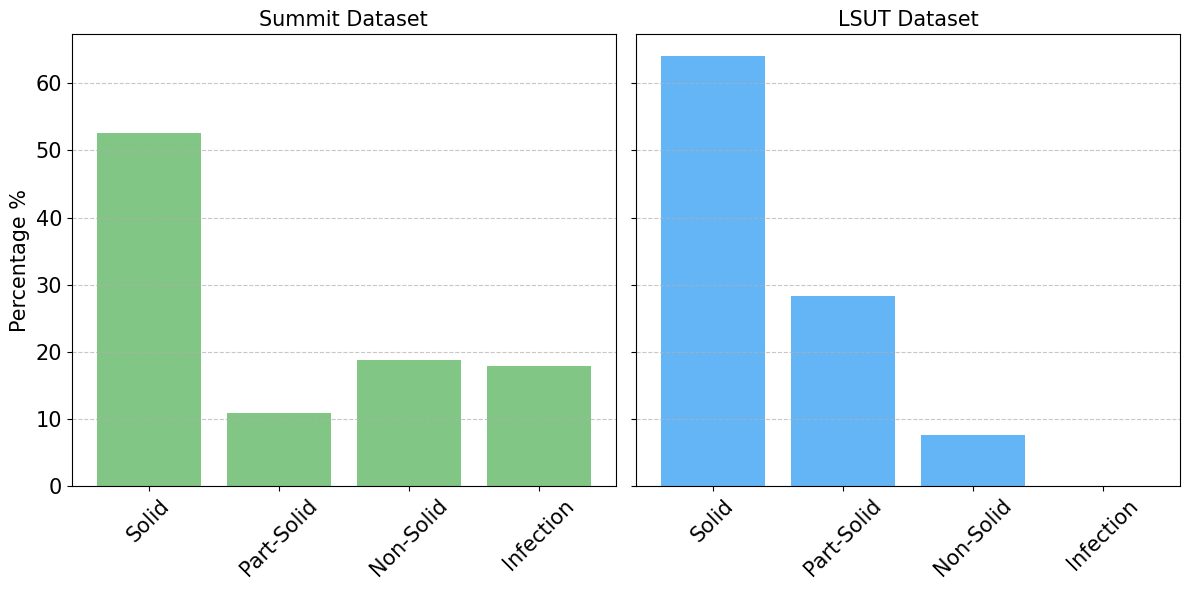

Chi-square Test Results:
Chi2 Statistic: 110.90865913377905
P-value: 9.602696797128949e-20
Degrees of Freedom: 9
Expected Frequencies:
[[134.85273353 153.61485298  58.63162327  58.63162327]
 [ 45.90488903  52.2916562   19.9586474   19.9586474 ]
 [ 29.69035432  33.82118623  12.90884971  12.90884971]
 [ 19.55202312  22.2723046    8.50087962   8.50087962]]
There is a statistically significant difference between the two datasets.


In [317]:
summit_test_nodule_vc = (
    pd.read_csv('../../metadata/summit/test_balanced/test_metadata.csv', usecols=['management_plan', 'nodule_type'])
    .assign(Actionable=lambda df: df['management_plan'] != 'RANDOMISATION_AT_YEAR_1')
    .query('Actionable == True')['nodule_type']
    .value_counts()
    .reindex(['SOLID', 'PART_SOLID', 'NON_SOLID', 'CALCIFIED'])
    .rename('test')
)

lsut_test_nodule_vc = (
    pd.read_csv('../../metadata/lsut/lsut_metadata.csv',usecols=['actionable', 'nodule_type'])
    .query('actionable == True')['nodule_type']
    .map(lsut_maps)
    .value_counts()
    .rename('test')
)  

category_mappings = {
    'SOLID' : 'Solid',
    'PART_SOLID' : 'Part-Solid',
    'NON_SOLID' : 'Non-Solid',
    'CALCIFIED' : 'Infection'
}
# Combine the two series into a DataFrame for chi-square test
combined_vc = pd.concat([summit_test_nodule_vc, lsut_test_nodule_vc], axis=1).fillna(0).astype(int)

combined_vc.rename(index=category_mappings, inplace=True)

combined_vc.columns = ['summit', 'lsut']

# Calculate percentages
combined_vc['summit_percentage'] = (combined_vc['summit'] / combined_vc['summit'].sum()) * 100
combined_vc['lsut_percentage'] = (combined_vc['lsut'] / combined_vc['lsut'].sum()) * 100

# Plot the distributions side by side
fig, axes = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)

# Summit dataset
summit_color = '#4CAF50'  # Green
lsut_color = '#2196F3'    # Blue

# Summit dataset percentages
axes[0].bar(combined_vc.index, combined_vc['summit_percentage'], color=summit_color, alpha=0.7)
axes[0].set_title('Summit Dataset', fontsize=15)
axes[0].set_ylabel('Percentage %', fontsize=15)
# axes[0].set_xlabel('Nodule Types', fontsize=15)
axes[0].set_xticks(range(len(combined_vc.index)))
axes[0].set_xticklabels(combined_vc.index, rotation=45, fontsize=15)
axes[0].tick_params(axis='y', labelsize=15)

# LSUT dataset percentages
axes[1].bar(combined_vc.index, combined_vc['lsut_percentage'], color=lsut_color, alpha=0.7)
axes[1].set_title('LSUT Dataset', fontsize=15)
# axes[1].set_xlabel('Nodule Types', fontsize=15)
axes[1].set_xticks(range(len(combined_vc.index)))
axes[1].set_xticklabels(combined_vc.index, rotation=45, fontsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig('results/extension/images/summit_vs_lsut_nodule_type_distribution.png', bbox_inches='tight')
plt.tight_layout()
plt.show()
# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(combined_vc)

print("Chi-square Test Results:")
print(f"Chi2 Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected)

if p < 0.05:
    print("There is a statistically significant difference between the two datasets.")
else:
    print("There is no statistically significant difference between the two datasets.")

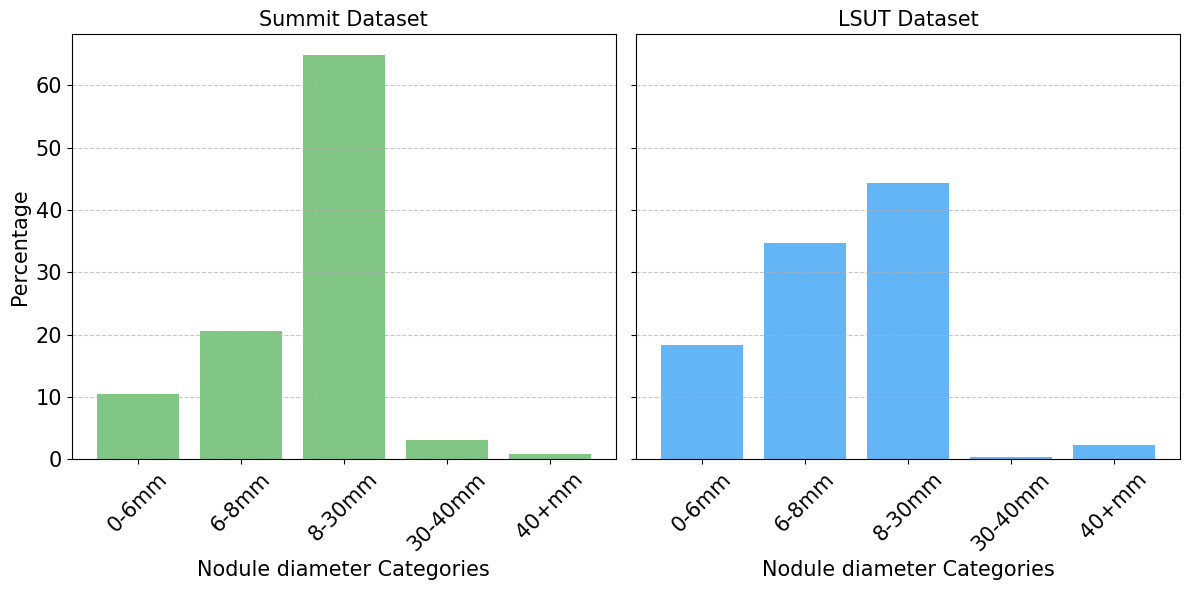

Chi-square Test Results:
Chi2 Statistic: 30.193963397226227
P-value: 4.468981997471203e-06
Degrees of Freedom: 4
Expected Frequencies:
[[ 33.50204082  38.49795918]
 [ 64.2122449   73.7877551 ]
 [122.84081633 141.15918367]
 [  3.72244898   4.27755102]
 [  3.72244898   4.27755102]]
There is a statistically significant difference between the two datasets.


In [318]:
summit_test_nodule_vc = (
    pd.read_csv('../../metadata/summit/test_balanced/test_metadata.csv', usecols=['management_plan', 'nodule_diameter_mm'])
    .query('management_plan != "RANDOMISATION_AT_YEAR_1"')
    .assign(diameter_cats=lambda df: pd.cut(df['nodule_diameter_mm'], bins=diameter_cats, labels=diameter_lbs))['diameter_cats']         
    .value_counts(normalize=True)
    .sort_index()
    .rename('test')
)

lsut_test_nodule_vc = (
    pd.read_csv('../../metadata/lsut/lsut_metadata.csv', usecols=['actionable', 'nodule_diameter_mm'])
    .query('actionable == True')
    .assign(diameter_cats=lambda df: pd.cut(df['nodule_diameter_mm'], bins=diameter_cats, labels=diameter_lbs))['diameter_cats']
    .value_counts(normalize=True)
    .sort_index()
    .rename('test')
)  

# Combine the two series into a DataFrame for chi-square test
combined_vc = pd.concat([summit_test_nodule_vc, lsut_test_nodule_vc], axis=1).fillna(0)
combined_vc.columns = ['summit', 'lsut']

# Plot the distributions side by side
fig, axes = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)

# Summit dataset
summit_color = '#4CAF50'  # Green
lsut_color = '#2196F3'    # Blue

# Summit dataset percentages
axes[0].bar(combined_vc.index, combined_vc['summit'] * 100, color=summit_color, alpha=0.7)
axes[0].set_title('Summit Dataset', fontsize=15)
axes[0].set_ylabel('Percentage', fontsize=15)
axes[0].set_xlabel('Nodule diameter Categories', fontsize=15)
axes[0].set_xticks(range(len(combined_vc.index)))
axes[0].set_xticklabels(combined_vc.index, rotation=45, fontsize=15)
axes[0].tick_params(axis='y', labelsize=15)

# LSUT dataset percentages
axes[1].bar(combined_vc.index, combined_vc['lsut'] * 100, color=lsut_color, alpha=0.7)
axes[1].set_title('LSUT Dataset', fontsize=15)
axes[1].set_xlabel('Nodule diameter Categories', fontsize=15)
axes[1].set_xticks(range(len(combined_vc.index)))
axes[1].set_xticklabels(combined_vc.index, rotation=45, fontsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig('results/extension/images/summit_vs_lsut_nodule_diameter_distribution.png', bbox_inches='tight')
plt.tight_layout()
plt.show()




summit_test_nodule_vc = (
    pd.read_csv('../../metadata/summit/test_balanced/test_metadata.csv', usecols=['management_plan', 'nodule_diameter_mm'])
    .query('management_plan != "RANDOMISATION_AT_YEAR_1"')
    .assign(diameter_cats=lambda df: pd.cut(df['nodule_diameter_mm'], bins=diameter_cats, labels=diameter_lbs))['diameter_cats']         
    .value_counts()
    .sort_index()
    .rename('test')
)

lsut_test_nodule_vc = (
    pd.read_csv('../../metadata/lsut/lsut_metadata.csv', usecols=['actionable', 'nodule_diameter_mm'])
    .query('actionable == True')
    .assign(diameter_cats=lambda df: pd.cut(df['nodule_diameter_mm'], bins=diameter_cats, labels=diameter_lbs))['diameter_cats']
    .value_counts()
    .sort_index()
    .rename('test')
)  

# Combine the two series into a DataFrame for chi-square test
combined_vc = pd.concat([summit_test_nodule_vc, lsut_test_nodule_vc], axis=1).fillna(0)
combined_vc.columns = ['summit', 'lsut']

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(combined_vc)

print("Chi-square Test Results:")
print(f"Chi2 Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected)

if p < 0.05:
    print("There is a statistically significant difference between the two datasets.")
else:
    print("There is no statistically significant difference between the two datasets.")

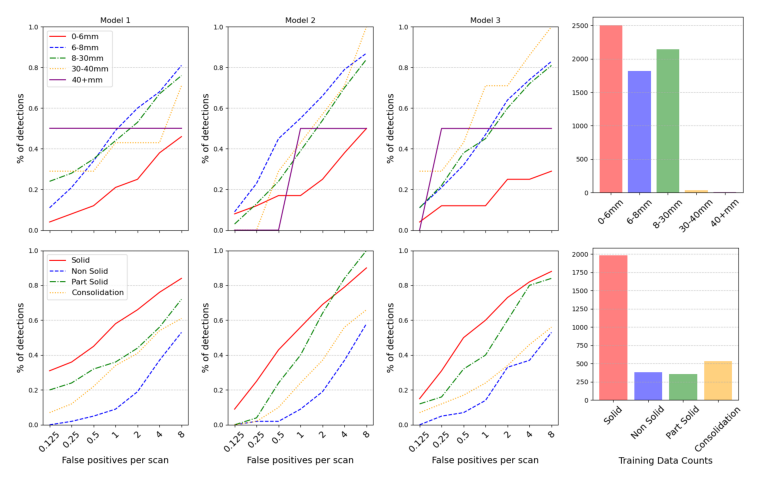

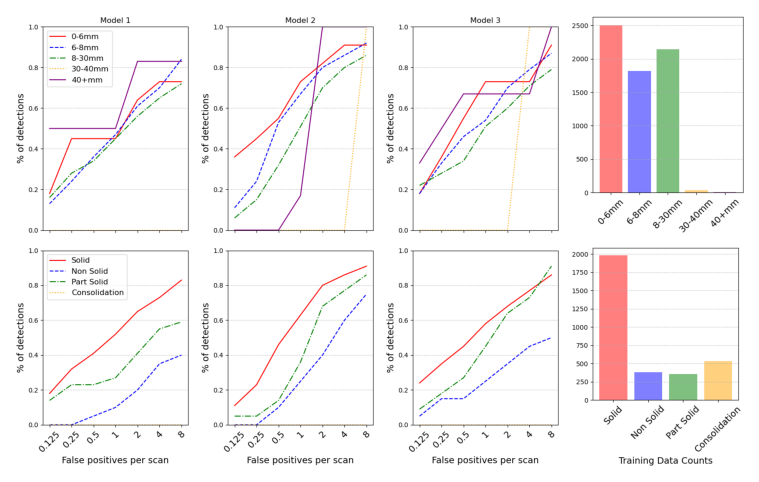

In [319]:


for dataset in ['summit', 'lsut']:

    # Read the saved images
    img1 = Image.open(f'results/{dataset}/grt123/test_balanced/Actionable/FROC/images/grt123_nodule_characteristics_diameter_cats.png')
    img2 = Image.open(f'results/{dataset}/detection/test_balanced/Actionable/FROC/images/detection_nodule_characteristics_diameter_cats.png')
    img3 = Image.open(f'results/{dataset}/ticnet/test_balanced/Actionable/FROC/images/ticnet_nodule_characteristics_diameter_cats.png')
    img4 = Image.open(f'results/{dataset}/grt123/test_balanced/Actionable/FROC/images/grt123_nodule_characteristics_nodule_type.png')
    img5 = Image.open(f'results/{dataset}/detection/test_balanced/Actionable/FROC/images/detection_nodule_characteristics_nodule_type.png')
    img6 = Image.open(f'results/{dataset}/ticnet/test_balanced/Actionable/FROC/images/ticnet_nodule_characteristics_nodule_type.png')
    img7 = Image.open(f'results/{dataset}/grt123/test_balanced/Actionable/FROC/images/grt123_nodule_characteristics_total_diameter_cats.png')
    img8 = Image.open(f'results/{dataset}/grt123/test_balanced/Actionable/FROC/images/grt123_nodule_characteristics_total_nodule_type.png')

    # Get the size of the images
    width1, height1 = img1.size
    width2, height2 = img2.size
    width3, height3 = img3.size
    width4, height4 = img4.size
    width5, height5 = img5.size
    width6, height6 = img6.size
    width7, height7 = img7.size
    width8, height8 = img8.size


    # Create a new image with a size that can fit both images side by side
    combined_width = width1 + width2 + width3 + width7
    combined_height = max(height1, height2, height3, height7) + max(height4, height5, height6, height8)
    combined_img = Image.new("RGB", (combined_width, combined_height))

    # Paste the images into the combined image
    combined_img.paste(img1, (0, 0))
    combined_img.paste(img2, (width1, 0))
    combined_img.paste(img3, (width1 + width2, 0))
    combined_img.paste(img7, (width1 + width2 + width3, 0))
    combined_img.paste(img4, (0, height1))
    combined_img.paste(img5, (width1, height2))
    combined_img.paste(img6, (width1 + width2, height3))
    combined_img.paste(img8, (width1 + width2 + width3, height7))

    # Save the combined image
    combined_img.save(f'results/extension/images/{dataset}_nodule_characteristics.png')

    # Display the combined image using matplotlib
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.imshow(combined_img)
    ax.axis('off')  # Hide the axis
    plt.show()

In [320]:
# Scan acquistion information
import numpy as np

summit_lung_metadata = pd.read_csv('../../data/summit/lung_metadata.csv')
lsut_lung_metadata = pd.read_csv('../../data/lsut/lung_metadata.csv')

print(lsut_lung_metadata['x-spacing'].describe())
print(lsut_lung_metadata['z-spacing'].describe())


summit_lung_metadata['z-spacing'].value_counts(normalize=True).sort_index()


count    732.000000
mean       0.676806
std        0.065008
min        0.512000
25%        0.625000
50%        0.665000
75%        0.723000
max        0.976000
Name: x-spacing, dtype: float64
count    732.000000
mean       0.745928
std        0.155219
min        0.299999
25%        0.800000
50%        0.800000
75%        0.800000
max        0.800000
Name: z-spacing, dtype: float64


0.625000    0.999454
0.626310    0.000032
0.627790    0.000032
0.642641    0.000032
0.649655    0.000032
0.665126    0.000032
0.686141    0.000032
0.698775    0.000032
0.705735    0.000032
0.706395    0.000032
0.861667    0.000032
1.000000    0.000225
Name: z-spacing, dtype: float64

# Statistical Analysis

In [321]:
import numpy as np
import cv2
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter
from scipy import stats

def hist_comparison(data1, cat1, data2, cat2, bins, title, variable, density=True):

    hist1, bins1 = np.histogram(data1[variable], bins=bins, density=True)
    hist2, bins2 = np.histogram(data2[variable], bins=bins, density=True)

    hist1 = cv2.normalize(hist1, hist1).astype(np.float32)
    hist2 = cv2.normalize(hist2, hist2).astype(np.float32)

    print(f'Histogram comparison for {variable} for {title}')
    print(f'Correlation between {variable} and nodule diameter for {title} is {cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)}')

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].hist(data1[variable], bins=bins, density=density, alpha=0.6, color='red')
    ax[0].set_title(f'{variable} for {cat1} ppts')
    if density:
        ax[0].set_xlim(0, 80)
        ax[0].set_ylim(0, 0.2)


    ax[1].hist(data2[variable], bins=bins, density=density, alpha=0.6, color='blue')
    ax[1].set_title(f'{variable} for {cat2} ppts')
    if density:
        ax[1].set_xlim(0, 80)
        ax[1].set_ylim(0, 0.2)
    

    fig.suptitle(title)
    plt.show()

def differences_bar_chart(data1, cat1, data2, cat2, variable, title):

    values1 = data1[variable].value_counts(normalize=True).sort_index().rename(f'{variable}_{cat1}').to_frame()
    values2 = data2[variable].value_counts(normalize=True).sort_index().rename(f'{variable}_{cat2}').to_frame()

    values = values1.merge(values2, left_index=True, right_index=True, how='outer').fillna(0)

    # Calculate differences
    differences = values[f'{variable}_{cat1}'] - values[f'{variable}_{cat2}']

    display(differences)

    # Create the bar chart
    fig, ax = plt.subplots(figsize=(10, 5))
    bars = ax.bar(differences.index, differences, color=['blue' if value < 0 else 'red' for value in differences])


    # Add labels and title
    ax.set_xticklabels(differences.index, rotation=45)
    ax.set_ylim(-0.1, 0.1)
    ax.set_xlabel('Categories')
    ax.set_ylabel('Difference')
    ax.set_title(f'Difference Bar Chart: {variable}')
    # Function to format y-tick labels as percentages with sign
    def percentage_with_sign(x, pos):
        return f'{np.abs(x)*100:.0f}%'

    # Apply the formatter to the y-axis
    ax.yaxis.set_major_formatter(FuncFormatter(percentage_with_sign))


    positive_patch = Patch(color='red', label=f'{cat1} greater than {cat2}')
    negative_patch = Patch(color='blue', label=f'{cat2} greater than {cat1}')
    ax.legend(handles=[positive_patch, negative_patch])

    # Show the plot
    plt.show()

def chi_square_test(data1, cat1, data2, cat2, variable):
    # Create the crosstab with absolutes
    xabs = (
        pd.DataFrame(
            data1[variable]
            .value_counts()
            .sort_index()
        )
        .merge(
            pd.DataFrame(
                data2[variable]
                .value_counts()
                .sort_index()
            ),
            left_index=True,
            right_index=True,
            how='outer',
            suffixes=('_'+cat1, '_'+cat2))
        .fillna(0)
    ).astype(int)

    # Calculate the chi-square test
    chi2, p, dof, expected = stats.chi2_contingency(xabs)

    print(f'Chi-square test for {variable} between {cat1} and {cat2}')
    print(f'Chi2: {chi2}')
    print(f'p-value: {p}')
    print(f'Degrees of freedom: {dof}')
    print(f'Expected frequencies table:')
    # display(pd.DataFrame(expected, index=xabs.index, columns=xabs.columns))

    return chi2, p, dof, expected

nodule_type             CALCIFIED  NON_SOLID  PART_SOLID     SOLID  All
ethnic_group                                                           
Asian or Asian British   0.104651   0.093023    0.069767  0.232558  0.5
Black                    0.094595   0.108108    0.027027  0.270270  0.5
White                    0.054878   0.103659    0.030488  0.310976  0.5
All                      0.077160   0.101852    0.040123  0.280864  0.5

nodule_type             CALCIFIED  NON_SOLID  PART_SOLID     SOLID  All
ethnic_group                                                           
Asian or Asian British   0.076923   0.146154    0.046154  0.230769  0.5
Black                    0.080645   0.088710    0.032258  0.298387  0.5
White                    0.101942   0.063107    0.072816  0.262136  0.5
All                      0.089130   0.093478    0.054348  0.263043  0.5

Chi-square test results:
Chi2: 13.744180865300782
p-value: 0.5450128854167515
Degrees of freedom: 15
Expected frequencies table:
[[  7.85204082  11.14795918]
 [ 11.15816327  15.84183673]
 [  4.95918367   7.04081633]
 [ 20.66326531  29.33673469]
 [  7.0255102    9.9744898 ]
 [  7.85204082  11.14795918]
 [  2.47959184   3.52040816]
 [ 23.55612245  33.44387755]
 [ 12.39795918  17.60204082]
 [ 12.39795918  17.60204082]
 [  8.26530612  11.73469388]
 [ 43.39285714  61.60714286]
 [ 27.2755102   38.7244898 ]
 [ 31.40816327  44.59183673]
 [ 15.70408163  22.29591837]
 [ 87.6122449  124.3877551 ]]


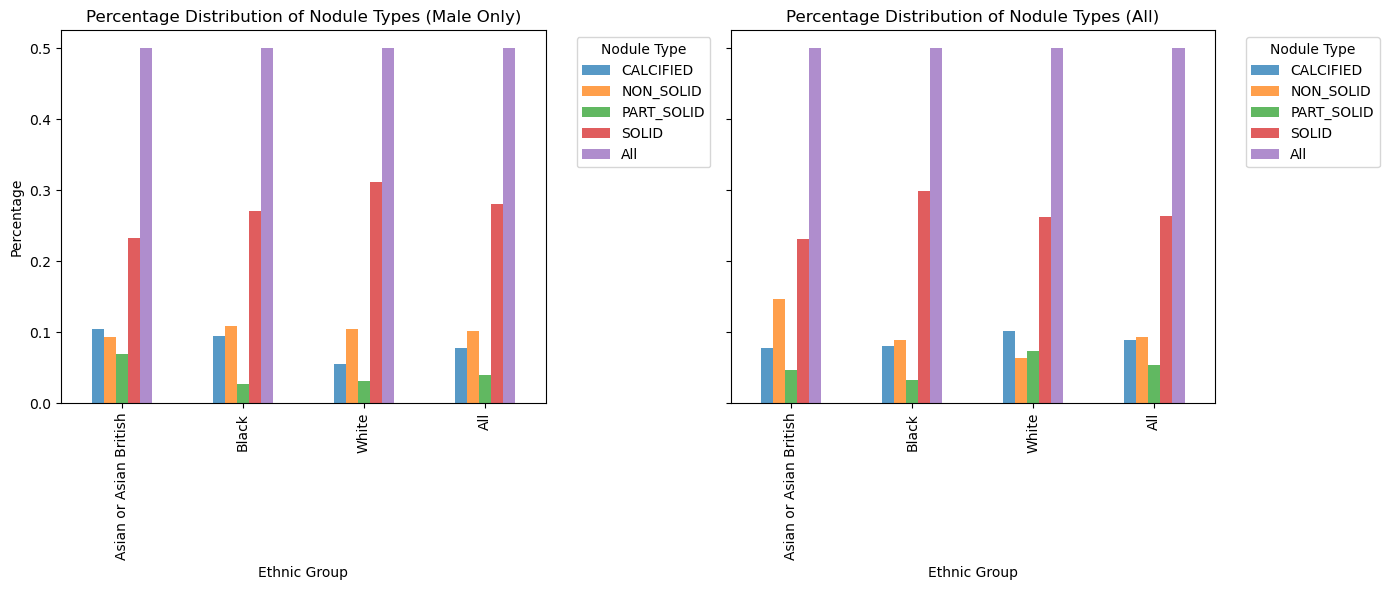

In [322]:
import matplotlib.pyplot as plt

def get_xtab(data):
    crosstab = pd.crosstab(
        data['ethnic_group'],
        data['nodule_type'],
        margins="index",
    )
    crosstab_percentage = crosstab.div(crosstab.sum(axis=1), axis=0)

    crosstab_combined = crosstab.astype(str) + ' (' + crosstab_percentage.astype(str) + ')' 

    return crosstab, crosstab_percentage, crosstab_combined

data = pd.read_csv('/Users/john/Projects/SOTAEvaluationNoduleDetection/metadata/summit/male_only/test_metadata.csv')
data = data.query('management_plan != "RANDOMISATION_AT_YEAR_1"')
mo_abs, mo_perc, mo_combined = get_xtab(data)

data = pd.read_csv('/Users/john/Projects/SOTAEvaluationNoduleDetection/metadata/summit/test_balanced/test_metadata.csv')
data = data.query('management_plan != "RANDOMISATION_AT_YEAR_1"')
all_abs, all_perc, all_combined = get_xtab(data)

display(mo_perc)
display(all_perc)

# Unravel mo_abs and all_abs
mo_abs_unravel = mo_abs.drop('All', axis=1).stack().reset_index().rename(columns={0: 'count'}).assign(ethnic_grp_and_subtype=lambda df: df.ethnic_group + '_' + df.nodule_type).drop(columns=['ethnic_group', 'nodule_type'])
all_abs_unravel = all_abs.drop('All', axis=1).stack().reset_index().rename(columns={0: 'count'}).assign(ethnic_grp_and_subtype=lambda df: df.ethnic_group + '_' + df.nodule_type).drop(columns=['ethnic_group', 'nodule_type'])

combined_long = pd.merge(mo_abs_unravel, all_abs_unravel, on='ethnic_grp_and_subtype', suffixes=('_mo', '_all'))

# Run chi-square test
chi2, p, dof, expected = stats.chi2_contingency(combined_long[['count_mo', 'count_all']])

print(f'Chi-square test results:')
print(f'Chi2: {chi2}')
print(f'p-value: {p}')
print(f'Degrees of freedom: {dof}')
print(f'Expected frequencies table:')
print(expected)

# Plotting side by side bar plots for mo_perc and all_perc

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=True)

# Plot for mo_perc
mo_perc.plot(kind='bar', ax=axes[0], alpha=0.75)
axes[0].set_title('Percentage Distribution of Nodule Types (Male Only)')
axes[0].set_xlabel('Ethnic Group')
axes[0].set_ylabel('Percentage')
axes[0].legend(title='Nodule Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot for all_perc
all_perc.plot(kind='bar', ax=axes[1], alpha=0.75)
axes[1].set_title('Percentage Distribution of Nodule Types (All)')
axes[1].set_xlabel('Ethnic Group')
axes[1].legend(title='Nodule Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


# Collate Fairness Metrics

In [37]:
import pandas as pd
import json
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
fontsize = 15


model_mappings = {
      'grt123': 'Model 1',
      'detection': 'Model 2',
      'ticnet': 'Model 3'
}

# Define color-blind-friendly palette
colors = {
      'Female': '#1f77b4',  # Blue
      'Male': '#ff7f0e',    # Orange
      'Asian': '#2ca02c',   # Green
      'Black': 'purple',   # Yellow
      'White': 'grey',   # Grey
      'Other': '#d62728'    # Red
}

metric_mappings = {
      'tpr': 'True Positive Rate',
      'fpr': 'False Positive Rate',
      'ppv': 'Positive Predictive Value',
      'pred_rate': 'Prediction Rate'
}


In [38]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

fair_paths = Path('results').rglob('*bootstrap_data.csv')

fair_data = pd.concat([
    (
        pd.read_csv(fair_path)
        .assign(
            dataset=fair_path.parts[-2],
            model=fair_path.parts[-1].split('_')[0],
            flavour=fair_path.parts[-1].split('_')[1] + '_' + fair_path.parts[-1].split('_')[2]
        )
    )
    for fair_path in fair_paths
])

bootstrapped_fair_metric_data = pd.concat([
    (
        fair_data[['bootstrap_id', 'counts', 'group', 'cat', 'fpps_rate', 'threshold', 'dataset', 'model', 'flavour'] + [metric]]
        .assign(metric_type=metric)
        .rename(columns={metric: 'metric_value'})
    )
    for metric in ['tpr','fpr','ppv','pred_rate']
])

bootstrapped_fair_metric_data.group.unique()

array(['gender', 'all', 'ethnic_group'], dtype=object)

In [34]:
fpps_mean_bootstrapped_fair_metric_data = bootstrapped_fair_metric_data.groupby([
    'bootstrap_id', 
    'dataset', 
    'model', 
    'flavour', 
    'group', 
    'cat', 
    'metric_type'
]).agg(
    metric_value_fpps_mean=('metric_value', 'mean')
).reset_index()



fpps_mean_bootstrapped_fair_metric_data = fpps_mean_bootstrapped_fair_metric_data.groupby([
    'dataset', 
    'model', 
    'flavour', 
    'group', 
    'cat', 
    'metric_type'
]).agg(
    mean=('metric_value_fpps_mean', 'mean'),
    lower=('metric_value_fpps_mean', lambda x: np.percentile(x, 2.5)),
    upper=('metric_value_fpps_mean', lambda x: np.percentile(x, 97.5))
).reset_index()

fpps_mean_bootstrapped_fair_metric_data

dataset      model        flavour         group     cat metric_type  \
0      lsut  detection  test_balanced           all     all         fpr   
1      lsut  detection  test_balanced           all     all         ppv   
2      lsut  detection  test_balanced           all     all   pred_rate   
3      lsut  detection  test_balanced           all     all         tpr   
4      lsut  detection  test_balanced  ethnic_group   Other         fpr   
..      ...        ...            ...           ...     ...         ...   
187  summit     ticnet     white_only        gender  FEMALE         tpr   
188  summit     ticnet     white_only        gender    MALE         fpr   
189  summit     ticnet     white_only        gender    MALE         ppv   
190  summit     ticnet     white_only        gender    MALE   pred_rate   
191  summit     ticnet     white_only        gender    MALE         tpr   

         mean     lower     upper  
0    0.444754  0.408716  0.481561  
1    0.499607  0.420990  0.572512  
2    0.526238  0.494456  0.556518  
3    0.689590  0.641183  0.735716  
4    0.406019  0.301573  0.511563  
..        ...       ...       ...  
187  0.544614  0.495868  0.591847  
188  0.536273  0.504988  0.566665  
189  0.268010  0.220537  0.315179  
190  0.534314  0.507340  0.563212  
191  0.529688  0.471889  0.591288  

[192 rows x 9 columns]

# Fairness Plots

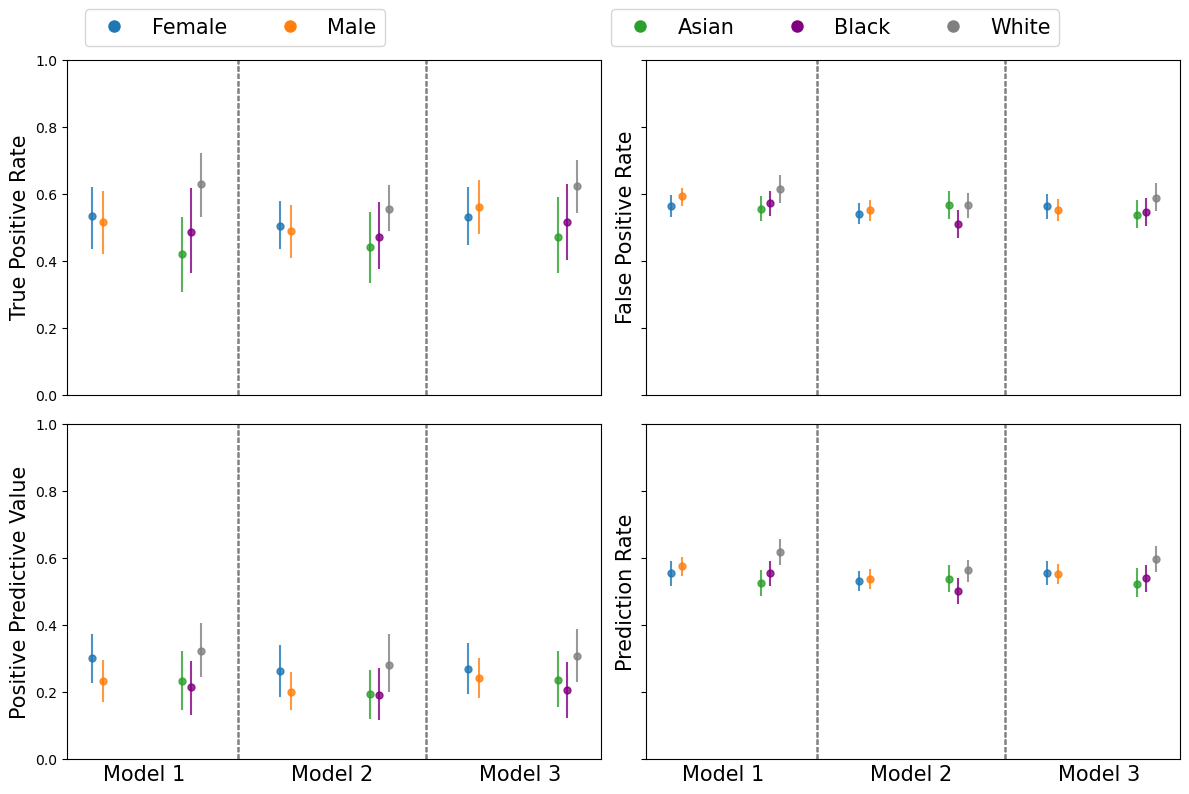

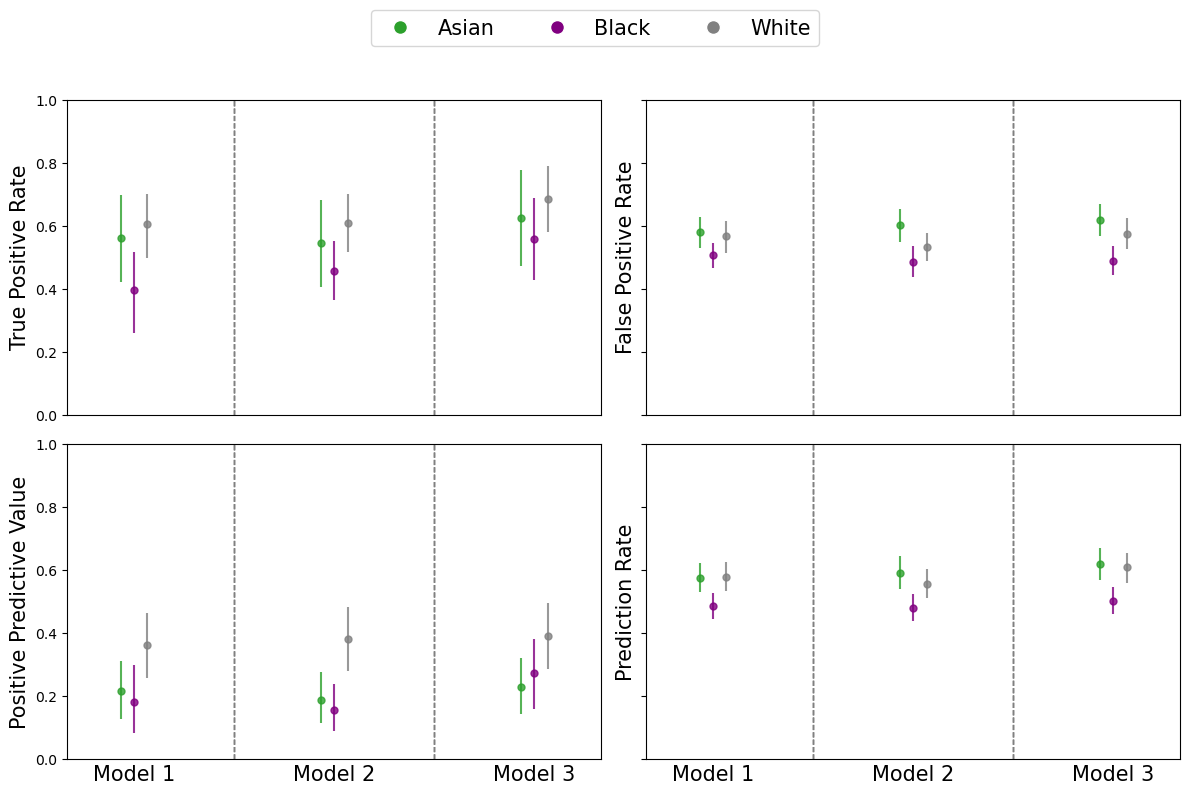

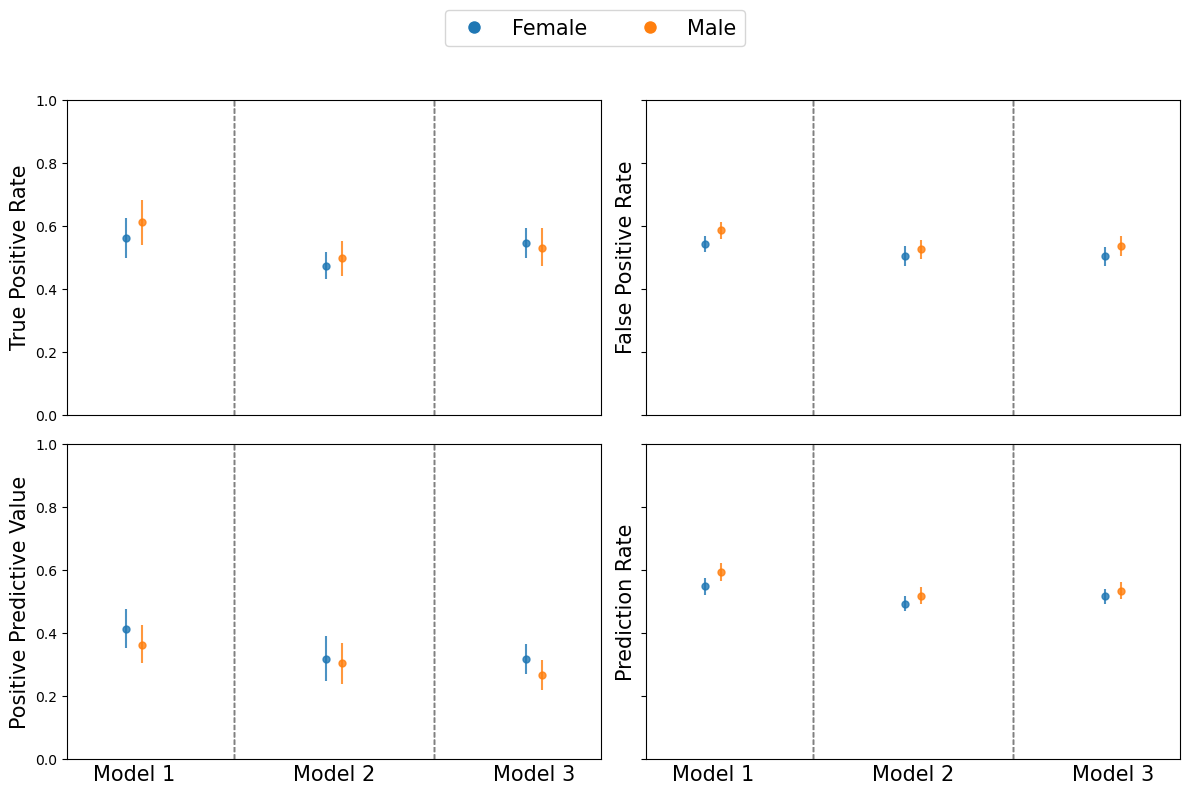

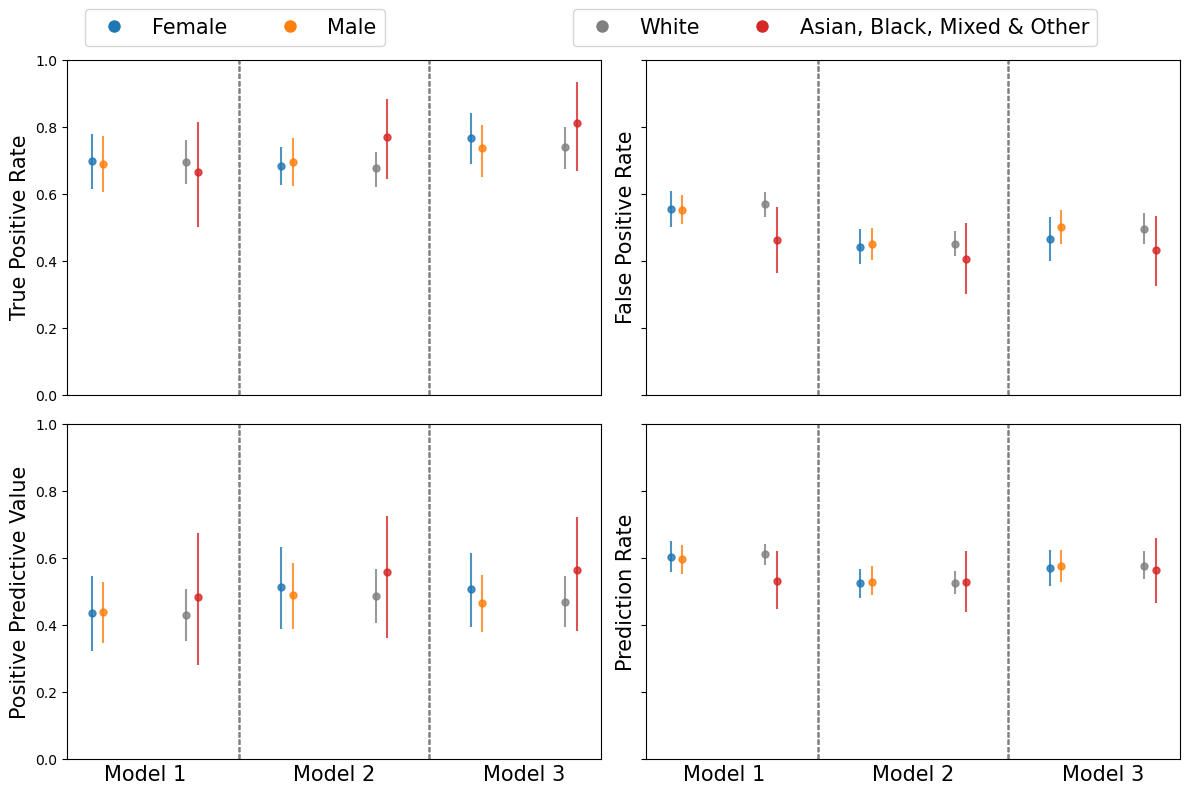

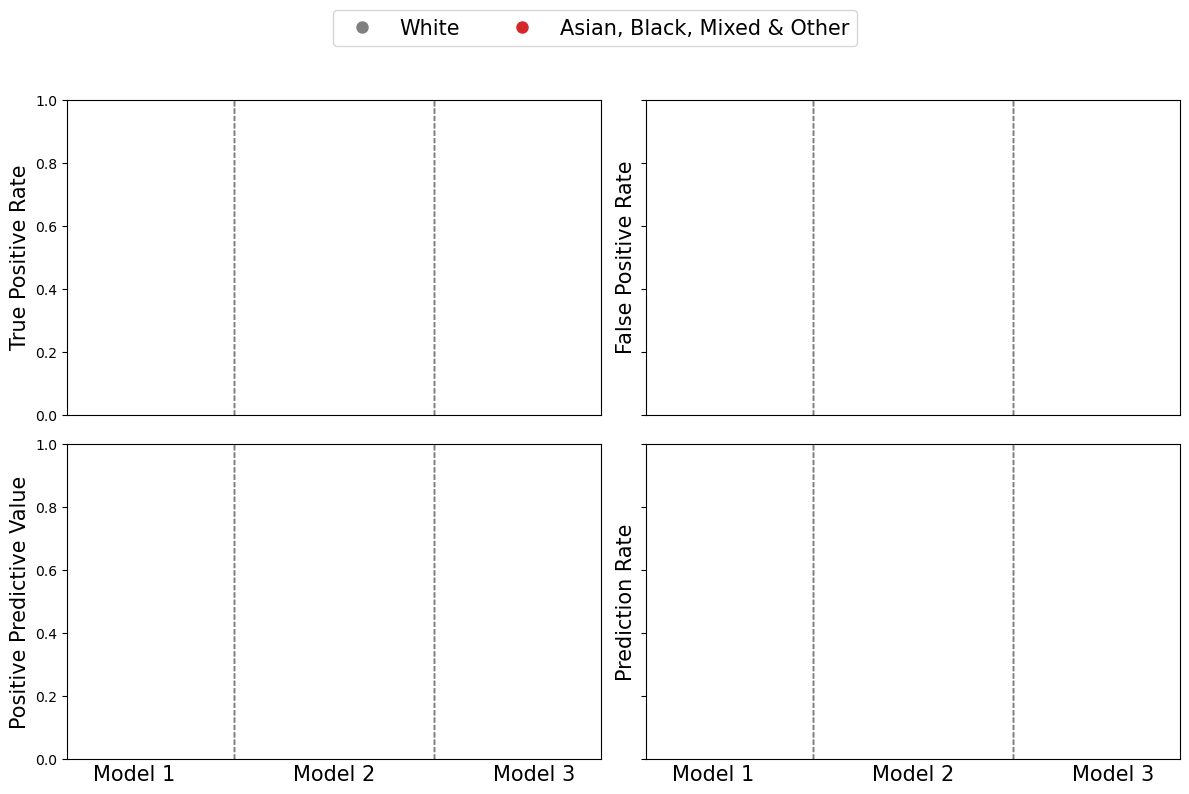

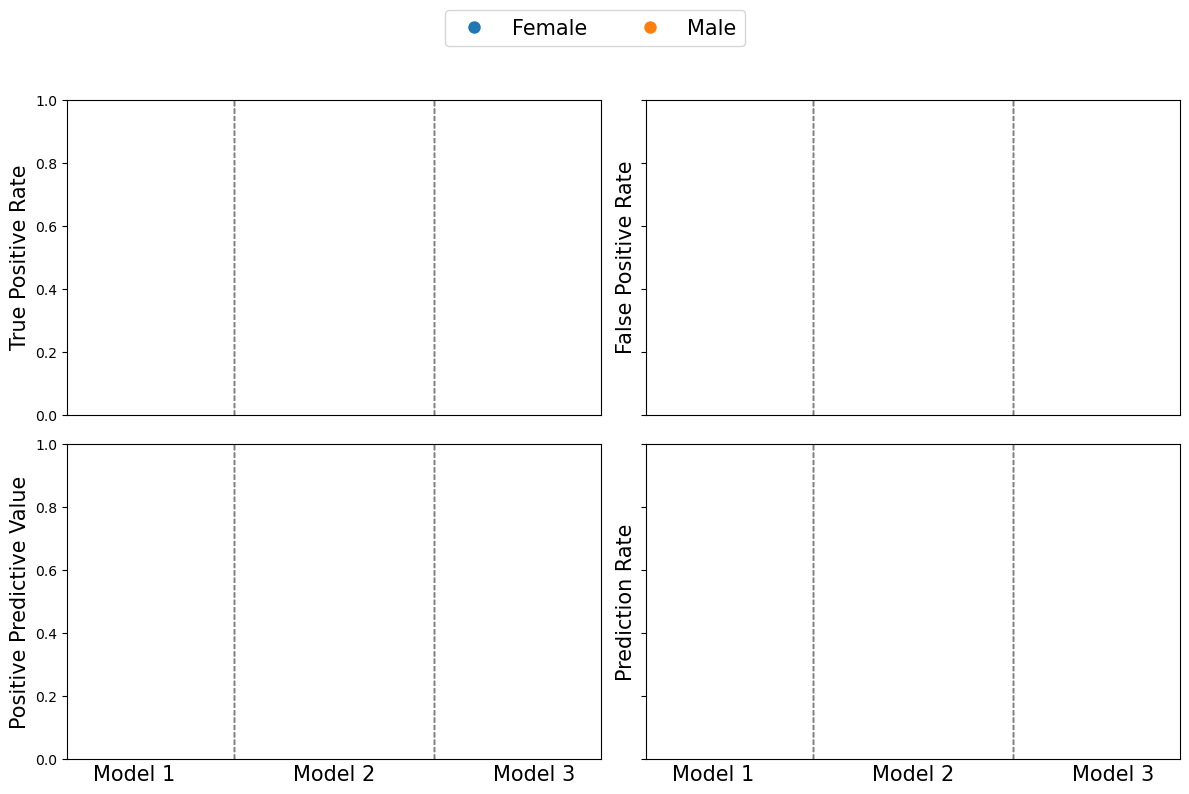

In [39]:
import numpy as np

import matplotlib.pyplot as plt

def display_fair_metric_plots(data, dataset, flavour):

    data = data.query('dataset == @dataset and flavour == @flavour')

    model_mappings = {
        'grt123': 'Model 1',
        'detection': 'Model 2',
        'ticnet': 'Model 3'
    }

    # Define color-blind-friendly palette
    colors = {
        'Female': '#1f77b4',  # Blue
        'Male': '#ff7f0e',    # Orange
        'Asian': '#2ca02c',   # Green
        'Black': 'purple',   # Yellow
        'White': 'grey',   # Grey
        'Other': '#d62728'    # Red
    }

    cat_mappings = {
        "summit" : 
        {
            "gender" : {
                'FEMALE' : {
                    "jitter" : {'test_balanced' : -0.3, 'white_only' : -0.3}, 
                    "color" : '#1f77b4', 
                    'flavours' : ['test_balanced', 'white_only']
                },
                'MALE' : {
                    "jitter" : {'test_balanced' : 0.3, 'white_only' : 0.3},
                    "color" : '#ff7f0e', 
                    'flavours' : ['test_balanced', 'white_only']
                }
            },
            "ethnic_group" : {
                'Asian or Asian British' : {
                    "jitter" : {'test_balanced' : -0.5, 'male_only' : -0.5}, 
                    "color" : '#2ca02c', 
                    'flavours' : ['test_balanced', 'male_only']
                }, 
                'Black' : {
                    "jitter" : {'test_balanced' : 0.0, 'male_only' : 0.0}, 
                    "color" : 'purple', 
                    'flavours' : ['test_balanced', 'male_only']
                }, 
                'White' : {
                    "jitter" : {'test_balanced' : 0.5, 'male_only' : 0.5},  
                    "color" : 'grey', 
                    'flavours' : ['test_balanced', 'male_only']
                }
            }
        },
        "lsut" : 
        {
            "gender" : {
                "Female" : {"jitter" : {"test_balanced" : -0.3}, "color" : '#1f77b4', 'flavours' : ['test_balanced']},
                "Male" : {"jitter" : {"test_balanced" : 0.3}, "color" : '#ff7f0e', 'flavours' : ['test_balanced']},
            },
            "ethnic_group" : {
                "White" : {"jitter" : {"test_balanced" : -0.3}, "color" : 'grey', 'flavours' : ['test_balanced']},
                "Other" : {"jitter" : {"test_balanced" : 0.3}, "color" : '#d62728', 'flavours' : ['test_balanced']}
            }
        }
    }

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), sharey=True, sharex=True)

    bar_width = 0.2
    ax = ax.flatten()
    for i, metric in enumerate(['tpr', 'fpr', 'ppv', 'pred_rate']):

        for mx, model in enumerate(['grt123', 'detection', 'ticnet']):

            if flavour == "test_balanced":
                groups = ['gender', 'ethnic_group']
            elif flavour == "white_only":
                groups = ['gender']
            elif flavour == "male_only":
                groups = ['ethnic_group']

            for gx, group in enumerate(groups):

                group_subset = data.query('model == @model and metric_type == @metric and group == @group')

                cats = [cat for cat in cat_mappings[dataset][group].keys() if flavour in cat_mappings[dataset][group][cat]['flavours']]
                for cat in cats:
                    # Get the jitter value for the current category
                    jitter = cat_mappings[dataset][group][cat]['jitter'][flavour]

                    if flavour in ["white_only","male_only"]:
                        if model == 'grt123':
                            adjusted_pos = 0.5
                        elif model == 'detection':
                            adjusted_pos = 0
                        elif model == 'ticnet':
                            adjusted_pos = -0.5
                        
                    else:
                        adjusted_pos = 0

                    subset = group_subset.query('cat == @cat')

                    ax[i].errorbar(
                        gx + (mx * 2) + (jitter * bar_width) + adjusted_pos,
                        subset['mean'],
                        yerr=[
                            subset['mean'] - subset['lower'],
                            subset['upper'] - subset['mean']
                        ],
                        fmt='o',
                        label=cat,
                        alpha=0.8,
                        color=cat_mappings[dataset][group][cat]["color"],
                        markersize=5
                    )
                
                # Set xticks and labels
                if flavour == "test_balanced":
                    ax[i].set_xticks([0.5, 2.5, 4.5])
                    ax[i].set_xticklabels(['Model 1', 'Model 2', 'Model 3'], fontsize=15)
                    # Add dashed vertical lines between models
                    for pos in [1.5, 3.5]:
                        ax[i].axvline(x=pos, color='gray', linestyle='--', linewidth=1)                


                elif flavour in ["white_only", "male_only"]:
                    ax[i].set_xlim([0,4])
                    ax[i].set_xticks([0.5, 2, 3.5])
                    ax[i].set_xticklabels(['Model 1', 'Model 2', 'Model 3'], fontsize=15)
                    # Add dashed vertical lines between models
                    for pos in [1.25, 2.75]:
                        ax[i].axvline(x=pos, color='gray', linestyle='--', linewidth=1)                

                ax[i].set_ylim(0, 1.0)
                ax[i].set_ylabel(f"{metric_mappings[metric]}", fontsize=fontsize)
                # ax[i].set_title(f"{metric_mappings[metric]}", fontsize=15)


    for a in ax.flat:  # axs is your array of axes
        a.tick_params(axis='x', length=0)  # Set tick length to 0 on x-axis

    # Create legends for sex and ethnic group
    if flavour in ['test_balanced', 'white_only']:
        legend_elements_sex = [
                Line2D([0], [0], marker='o', color='w', label='Female', markerfacecolor=colors['Female'], markersize=10),
                Line2D([0], [0], marker='o', color='w', label='Male', markerfacecolor=colors['Male'], markersize=10)
        ]
        
    if flavour in ['test_balanced', 'male_only']:
        if dataset == 'summit':
                legend_elements_ethnic = [
                    Line2D([0], [0], marker='o', color='w', label='Asian', markerfacecolor=colors['Asian'], markersize=10),
                    Line2D([0], [0], marker='o', color='w', label='Black', markerfacecolor=colors['Black'], markersize=10),
                    Line2D([0], [0], marker='o', color='w', label='White', markerfacecolor=colors['White'], markersize=10)
                ]
        else:
                legend_elements_ethnic = [
                    Line2D([0], [0], marker='o', color='w', label='White', markerfacecolor=colors['White'], markersize=10),
                    Line2D([0], [0], marker='o', color='w', label='Asian, Black, Mixed & Other', markerfacecolor=colors['Other'], markersize=10)                        
                ]

    if flavour == "test_balanced":
        fig.legend(
                handles=legend_elements_sex,
                loc='upper center',
                ncol=len(legend_elements_sex),
                bbox_to_anchor=(0.20, 1),
                fontsize=fontsize,
                frameon=True
        )

        fig.legend(
                handles=legend_elements_ethnic,
                loc='upper center',
                ncol=len(legend_elements_ethnic),
                bbox_to_anchor=(0.70, 1),
                fontsize=fontsize,
                frameon=True
        )

    elif flavour == 'white_only':
        fig.legend(handles=legend_elements_sex, loc='upper center', ncol=2, fontsize=fontsize, frameon=True)
    
    elif flavour == 'male_only':
        fig.legend(handles=legend_elements_ethnic, loc='upper center', ncol=3, fontsize=fontsize, frameon=True)

    # Adjust layout to make space for the legend and suptitle
    if flavour in ['male_only', 'white_only']:
        plt.tight_layout(rect=[0, 0, 1, 0.9])  # Leave more space at the top
    else:
        plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f'results/extension/images/{dataset}_{flavour}_scan_error_bar_plot.png', bbox_inches='tight')
    plt.show()


for dataset in ['summit','lsut']:

    for flavour in ['test_balanced', 'male_only', 'white_only']:

        display_fair_metric_plots(
            fpps_mean_bootstrapped_fair_metric_data,
            dataset,
            flavour
        )

In [45]:
# fpps_mean_bootstrapped_fair_metric_data['model'] = fpps_mean_bootstrapped_fair_metric_data['model'].map(model_mappings)
fpps_mean_bootstrapped_fair_metric_data.query('dataset == "summit" and flavour == "test_balanced" and group == "ethnic_group" and metric_type == "fpr" and model == "Model 2"')

dataset    model        flavour         group                     cat  \
76  summit  Model 2  test_balanced  ethnic_group  Asian or Asian British   
80  summit  Model 2  test_balanced  ethnic_group                   Black   
84  summit  Model 2  test_balanced  ethnic_group                   White   

   metric_type      mean     lower     upper   modeln  
76         fpr  0.566581  0.525601  0.606487  Model 2  
80         fpr  0.508323  0.469118  0.550277  Model 2  
84         fpr  0.566397  0.528376  0.601202  Model 2

## Cross dataset fairness metric comparison

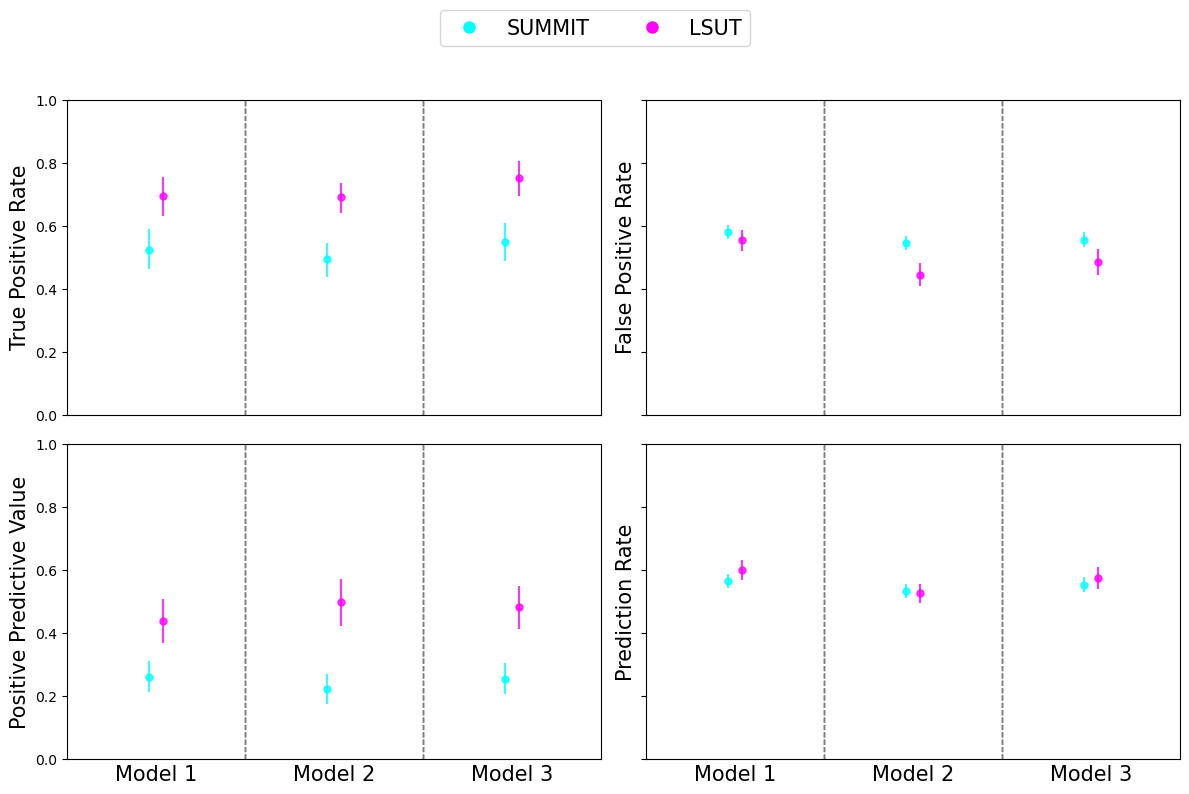

In [86]:
from torch import mode


def display_fair_metric_plots_x_dataset(data, flavour):

    data = data.query('flavour == @flavour')

    bar_width = 0.3
    colors = {
        'summit': 'cyan',
        'lsut': 'magenta'
    }

    model_mappings = {
        'grt123': 'Model 1',
        'detection': 'Model 2',
        'ticnet': 'Model 3'
    }

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), sharey=True, sharex=True)

    bar_width = 0.2
    ax = ax.flatten()
    for i, metric in enumerate(['tpr', 'fpr', 'ppv', 'pred_rate']):

        for mx, model in enumerate(['grt123', 'detection', 'ticnet']):

            for gx, dataset in enumerate(['summit','lsut']):

                ds_subset = data.query('model == @model and metric_type == @metric and dataset == @dataset')

            
                # Get the jitter value for the current category
            

                if model == 'grt123':
                    adjusted_pos = 0.25
                elif model == 'detection':
                    adjusted_pos = 0
                elif model == 'ticnet':
                    adjusted_pos = -0.25
        
                jitter = -0.2 if dataset == 'summit' else 0.2

                ax[i].errorbar(
                    mx + (jitter * bar_width),
                    ds_subset['mean'],
                    yerr=[
                        ds_subset['mean'] - ds_subset['lower'],
                        ds_subset['upper'] - ds_subset['mean']
                    ],
                    fmt='o',
                    label=dataset,
                    alpha=0.8,
                    color=colors[dataset],
                    markersize=5
                )
            
            # Set xticks and labels
            # if flavour == "test_balanced":
            ax[i].set_xlim([-0.5,2.5])
            ax[i].set_xticks([0.0, 1.0, 2.0])
            ax[i].set_xticklabels(['Model 1', 'Model 2', 'Model 3'], fontsize=15)
            # Add dashed vertical lines between models
            for pos in [0.5, 1.5]:
                ax[i].axvline(x=pos, color='gray', linestyle='--', linewidth=1)                


            # elif flavour in ["white_only", "male_only"]:
            # ax[i].set_xlim([0,4])
            # ax[i].set_xticks([0.5, 2, 3.5])
            # ax[i].set_xticklabels(['Model 1', 'Model 2', 'Model 3'], fontsize=15)
            # # Add dashed vertical lines between models
            # for pos in [1.25, 2.75]:
            #     ax[i].axvline(x=pos, color='gray', linestyle='--', linewidth=1)                

            ax[i].set_ylim(0, 1.0)
            ax[i].set_ylabel(f"{metric_mappings[metric]}", fontsize=fontsize)
            # ax[i].set_title(f"{metric_mappings[metric]}", fontsize=15)


    for a in ax.flat:  # axs is your array of axes
        a.tick_params(axis='x', length=0)  # Set tick length to 0 on x-axis

    
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='SUMMIT', markerfacecolor=colors['summit'], markersize=10),
        Line2D([0], [0], marker='o', color='w', label='LSUT', markerfacecolor=colors['lsut'], markersize=10)                        
    ]


    fig.legend(
            handles=legend_elements,
            loc='upper center',
            ncol=len(legend_elements),
            fontsize=fontsize,
            frameon=True
    )

    plt.tight_layout(rect=[0, 0, 1, 0.90])
    plt.savefig(f'results/extension/images/dataset_comparison_scan_level_error_bar_plot.png', bbox_inches='tight')
    plt.show()



fpps_mean_bootstrapped_fair_metric_data.query('group == "all"')

display_fair_metric_plots_x_dataset(
    fpps_mean_bootstrapped_fair_metric_data.query('group == "all"'),
    'test_balanced'
)


## Error Bars

In [327]:
error_plot_data = bootstrapped_fair_metric_data.groupby(['dataset', 'model', 'flavour', 'metric_type', 'cat', 'fpps_rate']).agg(
    mean=('metric_value', 'mean'),
    lower=('metric_value', lambda x: np.percentile(x, 2.5)),
    upper=('metric_value', lambda x: np.percentile(x, 97.5))
).reset_index().sort_values(['dataset', 'model', 'flavour', 'metric_type', 'cat', 'fpps_rate'])

********************************************************************************


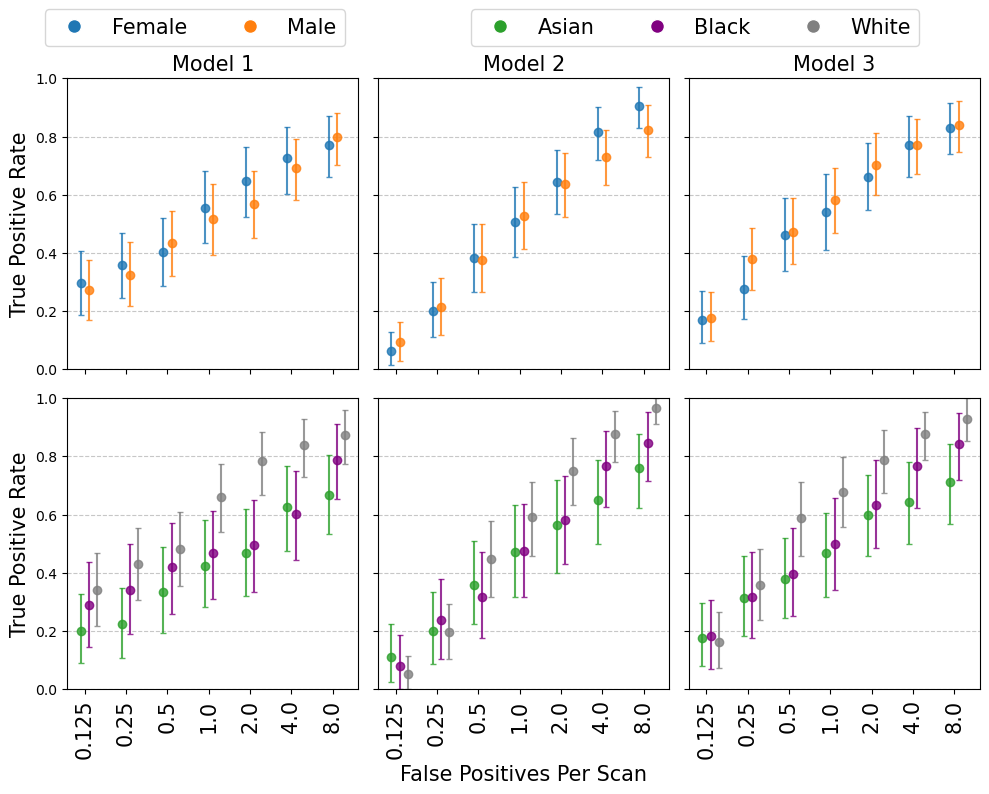

********************************************************************************


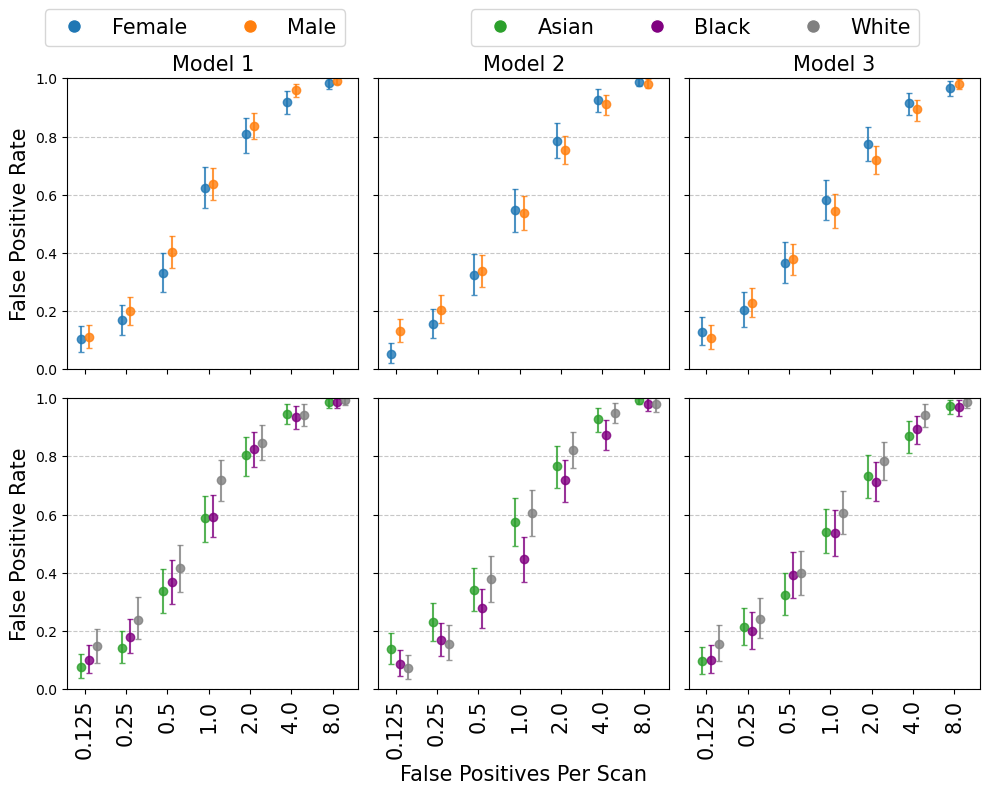

********************************************************************************


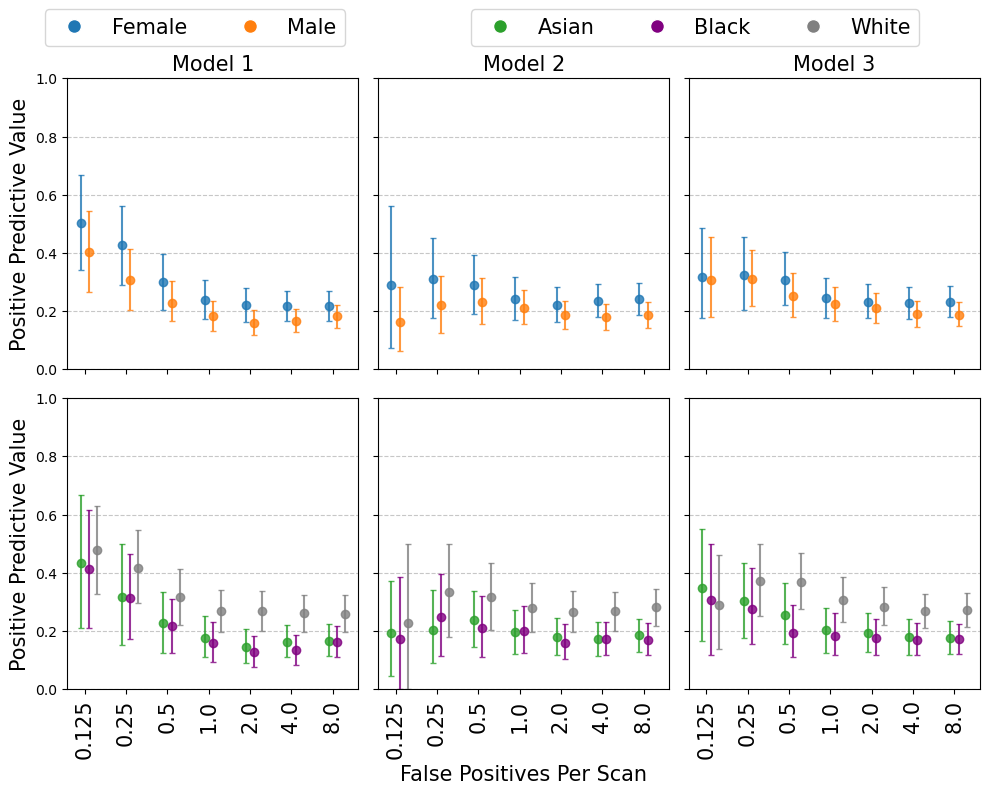

********************************************************************************


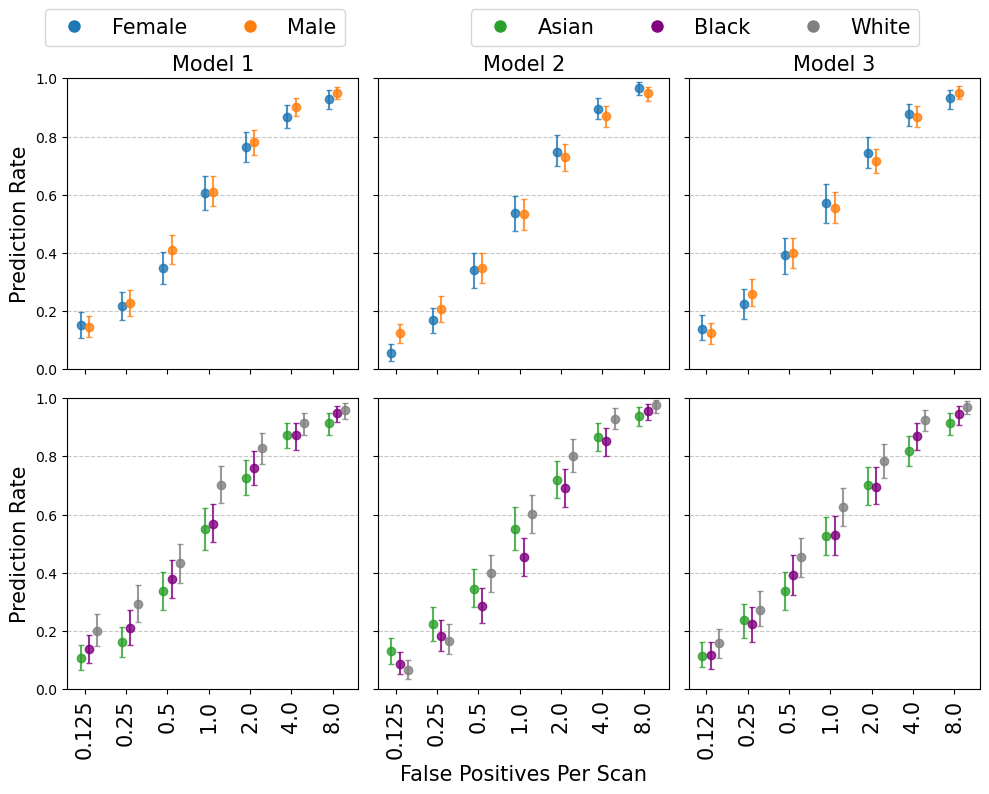

In [328]:

# Extract unique metrics
def plot_bootstrapped_fairness(dataset, map_data, flavour, metric):

      df = map_data.query('dataset == @dataset and flavour == @flavour and metric_type == @metric')

      if flavour == 'male_only':
            fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(10, 6), sharey=True, sharex=True)
      elif flavour == 'white_only':
            fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(10, 6), sharey=True, sharex=True)
      else:
            fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(10, 8), sharey=True, sharex=True)

      bar_width = 0.2
      categories_top = ['FEMALE', 'MALE'] if dataset == 'summit' else ['Female', 'Male']
      categories_bottom = ['Asian or Asian British', 'Black', 'White'] if dataset == 'summit' else ['White', 'Other']

      for i, model in enumerate(['grt123', 'detection', 'ticnet']):
            df_model = df.query('model == @model')

            if flavour != 'male_only':
                  ax_top = axes[0, i] if flavour != 'white_only' else axes[i]
                  for j, category in enumerate(categories_top):
                        subset = df_model.query('cat == @category')
                        subset = subset.sort_values(by='fpps_rate')
                        positions = np.arange(len(subset['fpps_rate'].unique()))
                        ax_top.errorbar(
                              positions + j * bar_width,
                              subset['mean'],
                              yerr=[
                                    subset['mean'] - subset['lower'],
                                    subset['upper'] - subset['mean']
                              ],
                              fmt='o',
                              label=category.replace('FEMALE', 'Female').replace('MALE', 'Male'),
                              capsize=2,
                              alpha=0.8,
                              color=colors[category.replace('FEMALE', 'Female').replace('MALE', 'Male')]
                        )
                        ax_top.set_title(f'{model_mappings[model]}', fontsize=fontsize)
                        ax_top.set_xticks(positions + bar_width / 2)
                        ax_top.set_xticklabels(subset['fpps_rate'].unique(), fontsize=fontsize, rotation=90)
                        ax_top.grid(axis="y", linestyle="--", alpha=0.7)
                        ax_top.set_ylim(0, 1)  # Ensure y-axis runs from 0 to 1

                        if i == 0:
                              ax_top.set_ylabel(metric_mappings[metric], fontsize=fontsize)

                        if i == 1 and flavour == 'white_only':
                              ax_top.set_xlabel('False Positives Per Scan', fontsize=fontsize)                              

            if flavour != 'white_only':
                  ax_bottom = axes[1, i] if flavour != 'male_only' else axes[i]
                  for j, category in enumerate(categories_bottom):
                        subset = df_model.query('cat == @category')
                        subset = subset.sort_values(by='fpps_rate')
                        positions = np.arange(len(subset['fpps_rate'].unique()))
                        ax_bottom.errorbar(
                              positions + j * bar_width,
                              subset['mean'],
                              yerr=[
                                    subset['mean'] - subset['lower'],
                                    subset['upper'] - subset['mean']
                              ],
                              fmt='o',
                              label=category.replace('Asian or Asian British', 'Asian'),
                              capsize=2,
                              alpha=0.8,
                              color=colors[category.replace('Asian or Asian British', 'Asian')]
                        )
                        ax_bottom.set_xticks(positions + bar_width / 2)
                        ax_bottom.set_xticklabels(subset['fpps_rate'].unique(), fontsize=fontsize, rotation=90)
                        ax_bottom.grid(axis="y", linestyle="--", alpha=0.7)
                        ax_bottom.set_ylim(0, 1)  # Ensure y-axis runs from 0 to 1

                  if i == 0:
                        ax_bottom.set_ylabel(metric_mappings[metric], fontsize=fontsize)

                  if i == 1:
                        ax_bottom.set_xlabel('False Positives Per Scan', fontsize=fontsize)

                  if flavour == 'male_only':
                        ax_bottom.set_title(f'{model_mappings[model]}', fontsize=fontsize)

      # Create legends for sex and ethnic group
      if flavour in ['test_balanced', 'white_only']:
            legend_elements_sex = [
                  Line2D([0], [0], marker='o', color='w', label='Female', markerfacecolor=colors['Female'], markersize=10),
                  Line2D([0], [0], marker='o', color='w', label='Male', markerfacecolor=colors['Male'], markersize=10)
            ]
            
      if flavour in ['test_balanced', 'male_only']:
            if dataset == 'summit':
                  legend_elements_ethnic = [
                        Line2D([0], [0], marker='o', color='w', label='Asian', markerfacecolor=colors['Asian'], markersize=10),
                        Line2D([0], [0], marker='o', color='w', label='Black', markerfacecolor=colors['Black'], markersize=10),
                        Line2D([0], [0], marker='o', color='w', label='White', markerfacecolor=colors['White'], markersize=10)
                  ]
            else:
                  legend_elements_ethnic = [
                        Line2D([0], [0], marker='o', color='w', label='White', markerfacecolor=colors['White'], markersize=10),
                        Line2D([0], [0], marker='o', color='w', label='Other', markerfacecolor=colors['Other'], markersize=10)                        
                  ]

      if flavour == "test_balanced":
            fig.legend(
                    handles=legend_elements_sex,
                    loc='upper center',
                    ncol=len(legend_elements_sex),
                    bbox_to_anchor=(0.20, 1),
                    fontsize=fontsize,
                    frameon=True
            )

            fig.legend(
                    handles=legend_elements_ethnic,
                    loc='upper center',
                    ncol=len(legend_elements_ethnic),
                    bbox_to_anchor=(0.70, 1),
                    fontsize=fontsize,
                    frameon=True
            )

      elif flavour == 'white_only':
            fig.legend(handles=legend_elements_sex, loc='upper center', ncol=2, fontsize=fontsize, frameon=True)
      
      elif flavour == 'male_only':
            fig.legend(handles=legend_elements_ethnic, loc='upper center', ncol=3, fontsize=fontsize, frameon=True)

      # Adjust layout to make space for the legend and suptitle
      if flavour in ['male_only', 'white_only']:
            plt.tight_layout(rect=[0, 0, 1, 0.9])  # Leave more space at the top
      else:
            plt.tight_layout(rect=[0, 0, 1, 0.95])
      plt.savefig(f'results/extension/images/{dataset}_{flavour}_error_bar_plot.png', bbox_inches='tight')
      plt.show()

for metric in ['tpr', 'fpr', 'ppv', 'pred_rate']:
      print('*'*80)
      plot_bootstrapped_fairness('summit', error_plot_data, 'test_balanced', metric)

In [329]:
test_data = fair_metric_data.query('dataset == "summit" and flavour == "test_balanced" and metric_type == "tpr"')
test_data.cat.value_counts()

FEMALE                    21
White                     21
MALE                      21
Black                     21
Asian or Asian British    21
Name: cat, dtype: int64

## CI

In [44]:
from ensurepip import bootstrap
import warnings
warnings.filterwarnings('ignore')


avg_fair_metric_data = (
    bootstrapped_fair_metric_data.groupby(['bootstrap_id', 'dataset', 'model', 'flavour', 'metric_type', 'cat'])
    .agg(mean_metric=('metric_value', 'mean'))
    .reset_index()
)

pivot_fair_metric_data = (
    avg_fair_metric_data.pivot_table(
        index=['bootstrap_id', 'dataset', 'model', 'flavour', 'metric_type'],
        columns='cat',
        values='mean_metric'
    )
    .reset_index()
)

summit_pivot_fair_metric_data = pivot_fair_metric_data.query('dataset == "summit"')

lsut_pivot_fair_metric_data = pivot_fair_metric_data.query('dataset == "lsut"')

summit_pivot_fair_metric_data['MALEVsFEMALE'] = summit_pivot_fair_metric_data['MALE'] - summit_pivot_fair_metric_data['FEMALE'] 
summit_pivot_fair_metric_data['AsianVsBlack'] = summit_pivot_fair_metric_data['Asian or Asian British'] - summit_pivot_fair_metric_data['Black'] 
summit_pivot_fair_metric_data['AsianVsWhite'] = summit_pivot_fair_metric_data['Asian or Asian British'] - summit_pivot_fair_metric_data['White'] 
summit_pivot_fair_metric_data['BlackVsWhite'] = summit_pivot_fair_metric_data['Black'] - summit_pivot_fair_metric_data['White']

lsut_pivot_fair_metric_data['MaleVsFemale'] = lsut_pivot_fair_metric_data['Male'] - lsut_pivot_fair_metric_data['Female'] 
lsut_pivot_fair_metric_data['WhiteVsOther'] = lsut_pivot_fair_metric_data['White'] - lsut_pivot_fair_metric_data['Other'] 

summit_male_vs_female_ci=(
    summit_pivot_fair_metric_data.groupby(['dataset', 'model', 'flavour', 'metric_type'])
    .agg(
        mean=('MALEVsFEMALE', 'mean'),
        lower=('MALEVsFEMALE', lambda x: np.quantile(x, 0.025)),
        upper=('MALEVsFEMALE', lambda x: np.quantile(x, 0.975))
    )
    .assign(comparison='MaleVsFemale')
    .reset_index()
)

summit_asian_vs_black_ci=(
    summit_pivot_fair_metric_data.groupby(['dataset', 'model', 'flavour', 'metric_type'])
    .agg(
        mean=('AsianVsBlack', 'mean'),
        lower=('AsianVsBlack', lambda x: np.quantile(x, 0.025)),
        upper=('AsianVsBlack', lambda x: np.quantile(x, 0.975))
    )
    .assign(comparison='AsianVsBlack')
    .reset_index()
)

display(summit_asian_vs_black_ci.query('flavour == "test_balanced" and metric_type == "pred_rate"'))

summit_asian_vs_white_ci=(
    summit_pivot_fair_metric_data.groupby(['dataset', 'model', 'flavour', 'metric_type'])
    .agg(
        mean=('AsianVsWhite', 'mean'),
        lower=('AsianVsWhite', lambda x: np.quantile(x, 0.025)),
        upper=('AsianVsWhite', lambda x: np.quantile(x, 0.975))
    )
    .assign(comparison='AsianVsWhite')
    .reset_index()
)

summit_black_vs_white_ci=(
    summit_pivot_fair_metric_data.groupby(['dataset', 'model', 'flavour', 'metric_type'])
    .agg(
        mean=('BlackVsWhite', 'mean'),
        lower=('BlackVsWhite', lambda x: np.quantile(x, 0.025)),
        upper=('BlackVsWhite', lambda x: np.quantile(x, 0.975))
    )
    .assign(comparison='BlackVsWhite')
    .reset_index()
)

lsut_male_vs_female_ci=(
    lsut_pivot_fair_metric_data.groupby(['dataset', 'model', 'flavour', 'metric_type'])
    .agg(
        mean=('MaleVsFemale', 'mean'),
        lower=('MaleVsFemale', lambda x: np.quantile(x, 0.025)),
        upper=('MaleVsFemale', lambda x: np.quantile(x, 0.975))
    )
    .assign(comparison='MaleVsFemale')
    .reset_index()
)

lsut_white_vs_other_ci=(
    lsut_pivot_fair_metric_data.groupby(['dataset', 'model', 'flavour', 'metric_type'])
    .agg(
        mean=('MaleVsFemale', 'mean'),
        lower=('MaleVsFemale', lambda x: np.quantile(x, 0.025)),
        upper=('MaleVsFemale', lambda x: np.quantile(x, 0.975))
    )
    .assign(comparison='WhiteVsOther')
    .reset_index()
)

ci_summary_data = pd.concat([
    summit_male_vs_female_ci,
    summit_asian_vs_black_ci,
    summit_asian_vs_white_ci,
    summit_black_vs_white_ci,
    lsut_male_vs_female_ci,
    lsut_white_vs_other_ci
], axis=0, ignore_index=True)

# print(ci_summary_data.shape[0])
# ci_summary_data = ci_summary_data.query('mean.notnull()')


# display(ci_summary_data)

ci_summary_data.query('flavour == "male_only" and mean.notnull()').to_clipboard()

dataset      model        flavour metric_type      mean     lower  \
6   summit  detection  test_balanced   pred_rate  0.037830 -0.013709   
18  summit     grt123  test_balanced   pred_rate -0.029711 -0.082973   
30  summit     ticnet  test_balanced   pred_rate -0.017429 -0.075054   

       upper    comparison  
6   0.095256  AsianVsBlack  
18  0.024531  AsianVsBlack  
30  0.036075  AsianVsBlack

********************************************************************************
Dataset: summit
Metric pred_rate
********************************************************************************
Flavour: test_balanced


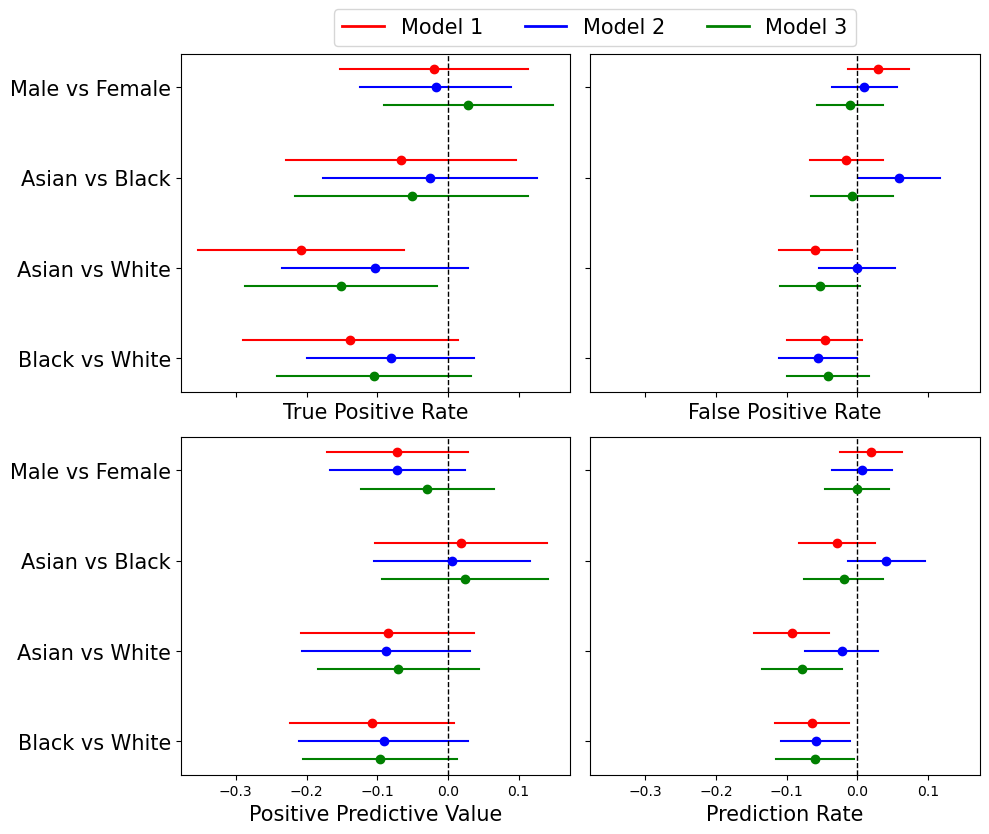

********************************************************************************
Dataset: summit
Metric pred_rate
********************************************************************************
Flavour: male_only


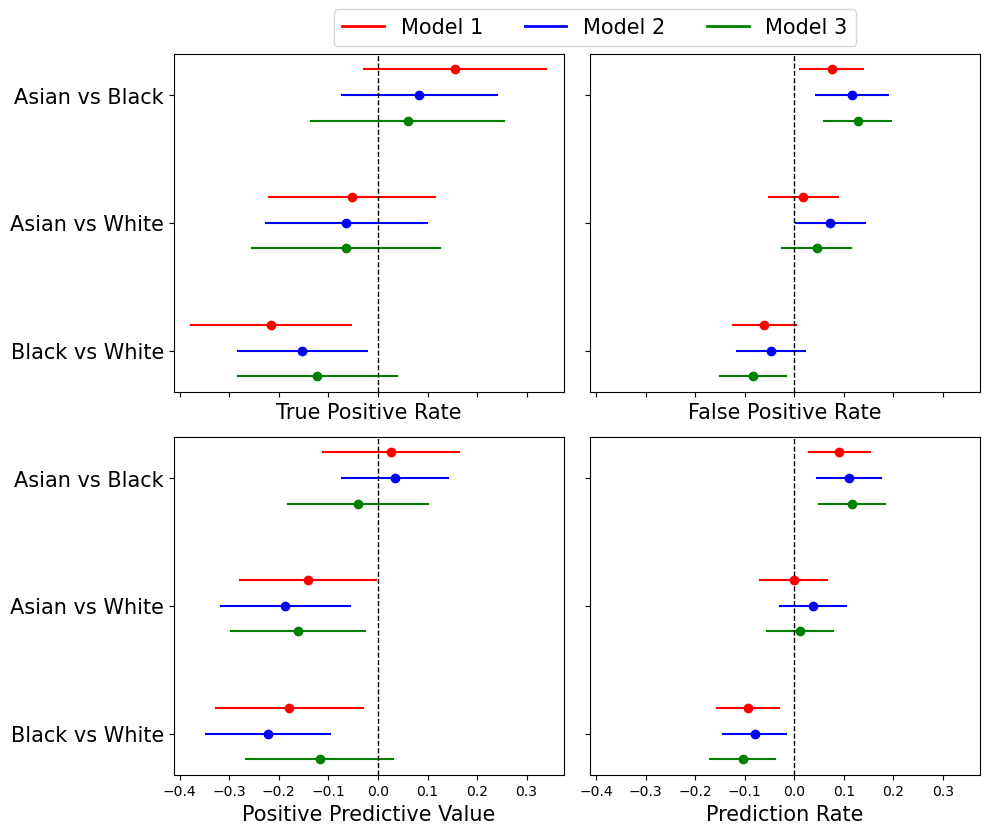

********************************************************************************
Dataset: summit
Metric pred_rate
********************************************************************************
Flavour: white_only


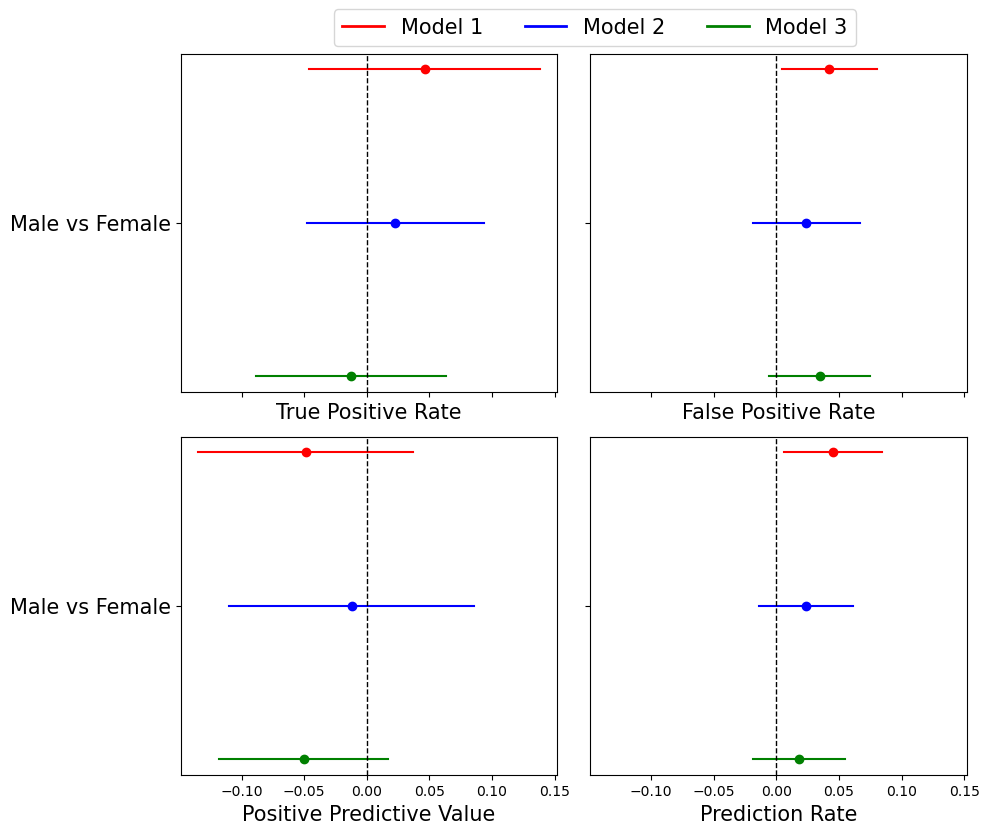

********************************************************************************
Dataset: lsut
Metric pred_rate
********************************************************************************
Flavour: test_balanced


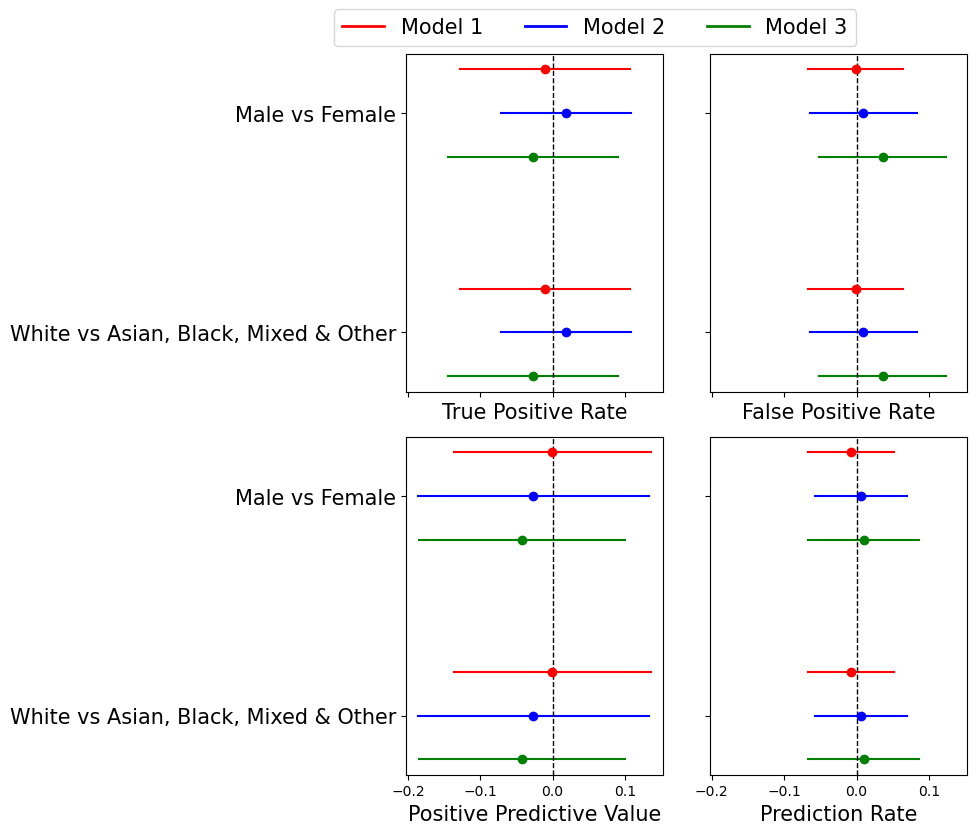

In [334]:
# Plot the confidence intervals for each dataset, model, flavour and metric type

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from sympy import plot


def plot_cix_data(dataset, ci_summary_data, flavour):
    print('*' * 80)
    print(f"Flavour: {flavour}")

    df = ci_summary_data.query('dataset == @dataset and flavour == @flavour')

    if dataset == 'summit':        
        mappings = {
            'test_balanced' : {
                'BlackVsWhite': 'Black vs White',
                'AsianVsWhite': 'Asian vs White',
                'AsianVsBlack': 'Asian vs Black',
                'MaleVsFemale': 'Male vs Female'
            },
            'male_only' : {
                'BlackVsWhite': 'Black vs White',
                'AsianVsWhite': 'Asian vs White',
                'AsianVsBlack': 'Asian vs Black',
            },
            'white_only' : {
                'MaleVsFemale': 'Male vs Female'
            },
        }

    else:
        mappings = {
            'test_balanced' : {
                'WhiteVsOther': 'White vs Asian, Black, Mixed & Other',
                'MaleVsFemale': 'Male vs Female'
            }
        }                

    mappings = mappings[flavour]

    # Update order to align with mappings keys
    order = list(mappings.keys())

    # Filter and sort data for each model
    df_detection = df.query('model == "detection"').sort_values('comparison', key=lambda x: x.map({k: i for i, k in enumerate(order)}))
    df_grt123 = df.query('model == "grt123"').sort_values('comparison', key=lambda x: x.map({k: i for i, k in enumerate(order)}))
    df_ticnet = df.query('model == "ticnet"').sort_values('comparison', key=lambda x: x.map({k: i for i, k in enumerate(order)}))

    # Combine data for all models
    combined_df = pd.concat([
        df_grt123.assign(model_name='Model 1', jitter=+0.2, color='red'),
        df_detection.assign(model_name='Model 2', jitter=0, color='blue'),
        df_ticnet.assign(model_name='Model 3', jitter=-0.2, color='green')
    ])

    # Create a single plot
    metrics = ['tpr', 'fpr', 'ppv', 'pred_rate']
    fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey=True, sharex=True)
    axes = axes.flatten()

    for idx, metric in enumerate(metrics):
        ax = axes[idx]

        df_metric = combined_df.query('metric_type == @metric')

        for i, category in enumerate(order):
            subset = df_metric.query('comparison == @category')

            if subset.shape[0] > 0:
                for _, row in subset.iterrows():
                    adjusted_jitter = row['jitter'] * 0.5 if flavour == 'white_only' else row['jitter']
                    ax.plot(
                        [row['lower'], row['upper']],
                        [i + adjusted_jitter, i + adjusted_jitter],
                        color=row['color'],
                        lw=1.5
                    )
                    ax.scatter(
                        (row['lower'] + row['upper']) / 2,
                        i + adjusted_jitter,
                        color=row['color'],
                        zorder=3
                    )

        # Add a vertical line at x=0
        ax.axvline(x=0, color='black', linestyle='--', lw=1)

        # Set y-ticks and labels
        ax.set_yticks(range(len(order)))
        ax.set_yticklabels([mappings[category] for category in order], fontsize=fontsize)

        # Set labels and title
        ax.set_xlabel(f"{metric_mappings[metric]}", fontsize=fontsize)
        # ax.set_title(f"{metric_mappings[metric]}", fontsize=fontsize)

    # Adjust layout and add a single legend above the plots
    legend_elements = [
        Line2D([0], [0], color='red', lw=2, label='Model 1'),
        Line2D([0], [0], color='blue', lw=2, label='Model 2'),
        Line2D([0], [0], color='green', lw=2, label='Model 3')
    ]
    fig.legend(handles=legend_elements, fontsize=fontsize, title_fontsize=fontsize, loc='upper center', bbox_to_anchor=(0.6, 1.05), ncol=3)
    plt.tight_layout()
    plt.show()



for dataset in ['summit', 'lsut']:
    for flavour in ['test_balanced', 'male_only', 'white_only'] if dataset == 'summit' else ['test_balanced']:
        print('*' * 80, flush=True)
        print(f"Dataset: {dataset}", flush=True)
        print('Metric', metric, flush=True)
        plot_cix_data(dataset, ci_summary_data, flavour)


# Nodule Counts across Ethnic Groups

## SUMMIT - Nodule Count Calculations

In [2]:
import pandas as pd
import numpy as np
import re

scans = []
for flavour in ['test_balanced','male_only', 'white_only']:
    for ds in ['training', 'validation', 'test']:
        scans.append(
            pd.read_csv(f'/Users/john/Projects/SOTAEvaluationNoduleDetection/metadata/summit/{flavour}/{ds}_scans.csv')
            .assign(
                dataset=ds,
                flavour=flavour
            )
        )

scans = pd.concat(scans, axis=0, ignore_index=True)

experiment_scans = pd.crosstab(
    scans.scan_id,
    [
        scans.flavour,
        scans.dataset
    ]
)

experiment_scans.columns = ['-'.join(col).strip() for col in experiment_scans.columns.values]
experiment_scans


male_only-test  male_only-training  \
scan_id                                                             
summit-2223-yts_Y0_BASELINE_A               0                   0   
summit-2224-gak_Y0_BASELINE_A               0                   1   
summit-2224-jcz_Y0_BASELINE_A               0                   0   
summit-2224-jgv_Y0_BASELINE_A               0                   0   
summit-2225-fhj_Y0_BASELINE_A               0                   0   
...                                       ...                 ...   
summit-9992-dxs_Y0_BASELINE_A               0                   0   
summit-9993-gxc_Y0_BASELINE_A               0                   1   
summit-9993-zmr_Y0_BASELINE_A               0                   0   
summit-9996-mmm_Y0_BASELINE_A               0                   0   
summit-9999-kkb_Y0_BASELINE_A               0                   0   

                               male_only-validation  test_balanced-test  \
scan_id                                                                   
summit-2223-yts_Y0_BASELINE_A                     0                   0   
summit-2224-gak_Y0_BASELINE_A                     0                   1   
summit-2224-jcz_Y0_BASELINE_A                     0                   0   
summit-2224-jgv_Y0_BASELINE_A                     0                   0   
summit-2225-fhj_Y0_BASELINE_A                     0                   0   
...                                             ...                 ...   
summit-9992-dxs_Y0_BASELINE_A                     0                   0   
summit-9993-gxc_Y0_BASELINE_A                     0                   0   
summit-9993-zmr_Y0_BASELINE_A                     0                   0   
summit-9996-mmm_Y0_BASELINE_A                     0                   0   
summit-9999-kkb_Y0_BASELINE_A                     0                   0   

                               test_balanced-training  \
scan_id                                                 
summit-2223-yts_Y0_BASELINE_A                       1   
summit-2224-gak_Y0_BASELINE_A                       0   
summit-2224-jcz_Y0_BASELINE_A                       1   
summit-2224-jgv_Y0_BASELINE_A                       1   
summit-2225-fhj_Y0_BASELINE_A                       1   
...                                               ...   
summit-9992-dxs_Y0_BASELINE_A                       1   
summit-9993-gxc_Y0_BASELINE_A                       1   
summit-9993-zmr_Y0_BASELINE_A                       1   
summit-9996-mmm_Y0_BASELINE_A                       1   
summit-9999-kkb_Y0_BASELINE_A                       1   

                               test_balanced-validation  white_only-test  \
scan_id                                                                    
summit-2223-yts_Y0_BASELINE_A                         0                0   
summit-2224-gak_Y0_BASELINE_A                         0                0   
summit-2224-jcz_Y0_BASELINE_A                         0                0   
summit-2224-jgv_Y0_BASELINE_A                         0                0   
summit-2225-fhj_Y0_BASELINE_A                         0                0   
...                                                 ...              ...   
summit-9992-dxs_Y0_BASELINE_A                         0                1   
summit-9993-gxc_Y0_BASELINE_A                         0                1   
summit-9993-zmr_Y0_BASELINE_A                         0                0   
summit-9996-mmm_Y0_BASELINE_A                         0                1   
summit-9999-kkb_Y0_BASELINE_A                         0                0   

                               white_only-training  white_only-validation  
scan_id                                                                    
summit-2223-yts_Y0_BASELINE_A                    1                      0  
summit-2224-gak_Y0_BASELINE_A                    0                      0  
summit-2224-jcz_Y0_BASELINE_A                    0                      0  
summit-2224-jgv_Y0_BASELINE_A                 

In [3]:
nodule_data = (
    pd.read_csv('/Users/john/Projects/SOTAEvaluationNoduleDetection/data/summit/data/nodule_data.csv')
    .assign(scan_id=lambda x: x.participant_id + '_Y0_BASELINE_A')
    .query('radiology_report_management_plan != "RANDOMISATION_AT_YEAR_1"')
    .groupby(['scan_id'])
    .size()
    .rename('nodule_count')
    .to_frame()
)
nodule_data

nodule_count
scan_id                                    
summit-2222-djr_Y0_BASELINE_A             1
summit-2223-sbv_Y0_BASELINE_A             1
summit-2226-bxt_Y0_BASELINE_A             1
summit-2227-zzp_Y0_BASELINE_A             1
summit-2229-szw_Y0_BASELINE_A             1
...                                     ...
summit-9987-vft_Y0_BASELINE_A             1
summit-9992-dxs_Y0_BASELINE_A             3
summit-9996-mmm_Y0_BASELINE_A             1
summit-9999-rfq_Y0_BASELINE_A             5
summit-9999-ssp_Y0_BASELINE_A             1

[2971 rows x 1 columns]

In [4]:
person_data = (
    pd.read_csv(
        '/Users/john/Projects/SOTAEvaluationNoduleDetection/data/summit/data/person_data.csv',
        usecols=[
            'LDCT_RADIOLOGY_REPORT_main_participant_id',
            'participant_details_gender',
            'lung_health_check_demographics_race_ethnicgroup'
        ]
    )
    .assign(scan_id=lambda x: x['LDCT_RADIOLOGY_REPORT_main_participant_id'] + '_Y0_BASELINE_A')
    .merge(
        nodule_data,
        on='scan_id',
        how='outer'
    )
    .assign(
        nodule_count=lambda x: x['nodule_count'].fillna(0).astype(int)
    )
    .assign(
        nodule_count_cats=lambda x: pd.cut(
            x['nodule_count'],
            bins=[-1, 0, 1, np.inf],
            labels=['0 Nodules', '1 Nodule', '2+ Nodules']
        )
    )    
    .merge(
        experiment_scans,
        left_on='scan_id',
        right_index=True,
        how='left'
    )
    .rename(columns={
        'participant_details_gender' : 'gender',
        'lung_health_check_demographics_race_ethnicgroup' : 'ethnic_group'
    })
    .filter(
        ['scan_id', 'gender', 'ethnic_group', 'nodule_count_cats'] + experiment_scans.columns.tolist()
    )
    .replace({'ethnic_group': {'Asian or Asian British': 'Asian'}})
)

person_data.head(50)

scan_id  gender ethnic_group nodule_count_cats  \
0   summit-2222-djr_Y0_BASELINE_A    MALE        White          1 Nodule   
1   summit-2222-zmd_Y0_BASELINE_A    MALE        White         0 Nodules   
2   summit-2223-rvs_Y0_BASELINE_A  FEMALE        White         0 Nodules   
3   summit-2223-sbv_Y0_BASELINE_A    MALE        White          1 Nodule   
4   summit-2223-vaw_Y0_BASELINE_A    MALE        White         0 Nodules   
5   summit-2223-ypu_Y0_BASELINE_A  FEMALE        White         0 Nodules   
6   summit-2223-yts_Y0_BASELINE_A    MALE        White         0 Nodules   
7   summit-2224-eju_Y0_BASELINE_A    MALE        White         0 Nodules   
8   summit-2224-gak_Y0_BASELINE_A    MALE        Black         0 Nodules   
9   summit-2224-jcz_Y0_BASELINE_A  FEMALE        Black         0 Nodules   
10  summit-2224-jgv_Y0_BASELINE_A  FEMALE        Mixed         0 Nodules   
11  summit-2224-nrh_Y0_BASELINE_A  FEMALE        White         0 Nodules   
12  summit-2225-dep_Y0_BASELINE_A    MALE        White         0 Nodules   
13  summit-2225-fhj_Y0_BASELINE_A  FEMALE        White         0 Nodules   
14  summit-2225-jhm_Y0_BASELINE_A  FEMALE        White         0 Nodules   
15  summit-2225-stn_Y0_BASELINE_A    MALE        White         0 Nodules   
16  summit-2226-bxt_Y0_BASELINE_A    MALE        White          1 Nodule   
17  summit-2226-kgh_Y0_BASELINE_A  FEMALE        White         0 Nodules   
18  summit-2227-ecr_Y0_BASELINE_A    MALE        White         0 Nodules   
19  summit-2227-nuf_Y0_BASELINE_A  FEMALE        White         0 Nodules   
20  summit-2227-pjw_Y0_BASELINE_A    MALE        White         0 Nodules   
21  summit-2227-xuz_Y0_BASELINE_A  FEMALE        White         0 Nodules   
22  summit-2227-zzp_Y0_BASELINE_A  FEMALE        White          1 Nodule   
23  summit-2228-mtd_Y0_BASELINE_A  FEMALE        White         0 Nodules   
24  summit-2228-qqa_Y0_BASELINE_A    MALE        White         0 Nodules   
25  summit-2229-szw_Y0_BASELINE_A  FEMALE        White          1 Nodule   
26  summit-2229-tqc_Y0_BASELINE_A    MALE        White         0 Nodules   
27  summit-2229-yyv_Y0_BASELINE_A  FEMALE        White         0 Nodules   
28  summit-2232-jnk_Y0_BASELINE_A  FEMALE        White         0 Nodules   
29  summit-2232-jyn_Y0_BASELINE_A  FEMALE        White         0 Nodules   
30  summit-2233-qhu_Y0_BASELINE_A    MALE        White         0 Nodules   
31  summit-2233-uty_Y0_BASELINE_A  FEMALE        White         0 Nodules   
32  summit-2233-vpt_Y0_BASELINE_A    MALE        White        2+ Nodules   
33  summit-2233-vtf_Y0_BASELINE_A  FEMALE        White         0 Nodules   
34  summit-2234-ape_Y0_BASELINE_A  FEMALE        White        2+ Nodules   
35  summit-2234-kvj_Y0_BASELINE_A    MALE        White         0 Nodules   
36  summit-2234-ucs_Y0_BASELINE_A    MALE        White         0 Nodules   
37  summit-2235-atn_Y0_BASELINE_A  FEMALE        White         0 Nodules   
38  summit-2235-kdm_Y0_BASELINE_A  FEMALE        White         0 Nodules   
39  summit-2236-krr_Y0_BASELINE_A    MALE        White         0 Nodules   
40  summit-2236-xuq_Y0_BASELINE_A  FEMALE        White         0 Nodules   
41  summit-2237-bdf_Y0_BASELINE_A    MALE        White         0 Nodules   
42  summit-2237-pmp_Y0_BASELINE_A  FEMALE        White         0 Nodules   
43  summit-2237-wky_Y0_BASELINE_A  FEMALE        White         0 Nodules   
44  summit-2238-bba_Y0_BASELINE_A    MALE        White         0 Nodules   
45  summit-2238-gpp_Y0_BASELINE_A    MALE        White         0 Nodules   
46  summit-2238-gsp_Y0_BASELINE_A  FEMALE        White         0 Nodules   
47  summit-2238-kac_Y0_BASELINE_A  FEMALE        White         0 Nodules   
48  summit-2239-fcu_Y0_BASELINE_A  FEMALE        White          1 Nodule   
49  summit-2239-nqd_Y0_BASELINE_A    MALE        White         0 Nodules   

    male_only-test  male_only-training  male_only-validation  \
0              NaN                 NaN                   NaN   
1              NaN   

In [5]:
person_data.fillna(0, inplace=True)
person_data.columns

Index(['scan_id', 'gender', 'ethnic_group', 'nodule_count_cats',
       'male_only-test', 'male_only-training', 'male_only-validation',
       'test_balanced-test', 'test_balanced-training',
       'test_balanced-validation', 'white_only-test', 'white_only-training',
       'white_only-validation'],
      dtype='object')

In [10]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

def create_standardized_residuals_table(contingency_table):
    """
    Create a standardized residuals table and combine it with the contingency table.

    Args:
        contingency_table (pd.DataFrame): A contingency table with absolute values.

    Returns:
        pd.DataFrame: A table with absolutes and standardized residuals in brackets.
    """
    # Perform chi-square test to get expected frequencies
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Calculate standardized residuals
    residuals = (contingency_table - expected) / np.sqrt(expected)

    # Combine absolutes and residuals into a single table
    combined_table = contingency_table.copy()
    for row in combined_table.index:
        for col in combined_table.columns:
            absolute = combined_table.loc[row, col]
            residual = residuals.loc[row, col]
            combined_table.loc[row, col] = f"{absolute} ({residual:.2f})"

    return combined_table


In [ ]:

# Example usage
data = person_data.query("`white_only-test` == 1")

print(data.shape[0] / 3)

# ethnic_contig_table = pd.crosstab(
#     data['ethnic_group'],
#     data['nodule_count_cats']
# )

# ethnic_group_result_table = create_standardized_residuals_table(ethnic_contig_table)


gender_contig_table = pd.crosstab(
    data['gender'],
    data['nodule_count_cats']
)

gender_result_table = create_standardized_residuals_table(gender_contig_table)

# pd.concat([
#     gender_result_table,
#     ethnic_group_result_table
# ]).to_clipboard()

gender_result_table.to_clipboard()

## LSUT - Nodule Count Calculations

In [19]:
import pandas as pd
import numpy as np

lsut_scan_metadata = (
    pd.read_csv(
        '/Users/john/Projects/SOTAEvaluationNoduleDetection/metadata/lsut/lsut_scans_metadata.csv',
        usecols=[
            'ScananonID',
            'clinic_gender',
            'clinic_ethnicity'
        ])
        .assign(
            ethnic_grp_cats=lambda x: x['clinic_ethnicity'].replace({
                'White' : 'White',
                'Other ethnic group' : 'Other',
                'Black/ African/ Caribbean/ Black British' : 'Other',
                'Asian or Asian British' : 'Other',
                'Mixed or multiple ethnic groups' : 'Other'                
            })
        )        
)

lsut_metadata = (
    pd.read_csv('/Users/john/Projects/SOTAEvaluationNoduleDetection/metadata/lsut/lsut_metadata.csv')
    .query('actionable == True')
    .groupby(['scan_id'])
    .size()
    .rename('nodule_count')
    .to_frame()
)

lsut_nodule_counts = (
    pd.merge(
        lsut_scan_metadata,
        lsut_metadata,
        left_on='ScananonID',
        right_on='scan_id',
        how='left'
    )
    .fillna(0)
    .assign(
        nodule_count_cats=lambda x: pd.cut(
            x['nodule_count'],
            bins=[-1, 0, 1, np.inf],
            labels=['0 Nodules', '1 Nodule', '2+ Nodules']
        )
    )
)

gender_contig = pd.crosstab(
    lsut_nodule_counts['clinic_gender'],
    lsut_nodule_counts['nodule_count_cats']
)

gender_std_resids = create_standardized_residuals_table(gender_contig)
gender_std_resids


ethnic_contig = pd.crosstab(
    lsut_nodule_counts['ethnic_grp_cats'],
    lsut_nodule_counts['nodule_count_cats']
)

ethnic_std_resids = create_standardized_residuals_table(ethnic_contig)

pd.concat(
    [
        gender_std_resids,
        ethnic_std_resids
    ]
).to_clipboard()
